# Imports

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
import os
from tqdm import tqdm

# Config

In [2]:
reference_countries = [
    { 'country': 'Poland', 'province' : None },
    { 'country': 'China', 'province': 'Hubei'},
    { 'country': 'Korea, South', 'province': None },
    { 'country': 'Italy', 'province': None },
    { 'country': 'Germany', 'province': None },
    { 'country': 'Spain', 'province': None },
    { 'country': 'France', 'province': None },
    { 'country': 'US', 'province': 'New York' },
    { 'country': 'Japan', 'province': None },
    { 'country': 'Belarus', 'province': None },
]
other_countries = [
    { 'country': 'Czechia', 'province': None },
    { 'country': 'Slovakia', 'province': None },  
    { 'country': 'US', 'province': None},
    { 'country': 'US', 'province': 'New Jersey' },
    { 'country': 'Austria', 'province': None },
    { 'country': 'Switzerland', 'province': None },
    { 'country': 'Belgium', 'province': None },
    { 'country': 'Australia', 'province': None },
    { 'country': 'Canada', 'province': None },
    { 'country': 'Israel', 'province': None },
    { 'country': 'South Africa', 'province': None },
    { 'country': 'Turkey', 'province': None },
    { 'country': 'Iran', 'province': None },
    { 'country': 'Russia', 'province': None },
    { 'country': 'Belarus', 'province': None }
]

countries = reference_countries + other_countries
main_output_folder = 'output/covid/'
os.makedirs(main_output_folder, exist_ok=True)

str_format = '%Y-%m-%d'
kaggle_str_format = '%m/%d/%y'

# Read data & do basic preprocessing

In [3]:
def get_all_countries(folder='kaggle'):
    df = pd.read_csv(f"data\\{folder}\\time_series_covid_19_confirmed.csv")
    return df['Country/Region'].unique()

def get_all_country_provinces(country='Poland',folder='manual', file='time_series_covid_19_confirmed'):
    df = pd.read_csv(f"data\\{folder}\\{file}.csv")
    country_col = [c for c in ['Country/Region', 'Country_Region'] if c in df.columns][0]
    province_col = [c for c in ['Province/State', 'Province_State'] if c in df.columns][0]
    df = df[(df[country_col] == country) & df[province_col].notnull()]
    return df[province_col].unique()

def get_mask(df, country, province=None):
    country_col = [c for c in ['Country/Region', 'Country_Region'] if c in df.columns][0]
    province_col = [c for c in ['Province/State', 'Province_State'] if c in df.columns][0]
    
    mask = df[country_col] == country
    if province is None:
        no_province_mask = (df[country_col] == country) & df[province_col].isnull()
        if no_province_mask.sum() == 1:
            mask = no_province_mask
    else:
        mask = mask & (df[province_col] == province)
    return mask
    

def parse_data(country, province=None, 
               folder='kaggle', filename='time_series_covid_19_confirmed'):
    df = pd.read_csv(f"data\\{folder}\\{filename}.csv")
    mask = get_mask(df, country, province)
    if mask.sum() == 0:
        return None
    drop_cols_count = 0
    for col in df.columns:
        try:
            date = datetime.datetime.strptime(col, kaggle_str_format)
            break
        except ValueError:
            drop_cols_count = drop_cols_count + 1
    country_series = df[mask].sum()[drop_cols_count:]
    country_series = country_series[country_series > 0]
    df = pd.DataFrame({'count' : country_series.values, 'date' : country_series.index})
    df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, kaggle_str_format))
    df['date'] = df['date'].apply(lambda x: datetime.datetime.strftime(x, str_format))
    return df

def get_population(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    return df[mask]['Population'].sum()

def get_density(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    df = df[mask]
    density = df['Population'].sum() / (df['Population']/df['Density (people/km2)']).sum()
    return density

def get_gdp_ppp(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    df = df[mask]
    gdp = (df['Population'] * df['GDP per capita ($) (PPP)']).sum() / df['Population'].sum()
    return gdp

def get_gdp_nominal(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    df = df[mask]
    gdp = (df['Population'] * df['GDP per capita ($) (nominal)']).sum() / df['Population'].sum()
    return gdp

def get_temperature(country, province=None):
    df = pd.read_excel(f"data\\population.xlsx")
    mask = get_mask(df, country, province)
    df = df[mask]
    temperature = df['average yearly temperature (degree Celsius)'].mean()
    return temperature
    

def preprocess_data(df, population, min_count=100, min_count_per_million=10):
    if df.shape[0] == 0:
        return None
    df = df.reset_index(drop=True)
    df = pd.concat([df, pd.DataFrame([[np.nan] * df.shape[1]] * 14, columns=df.columns)], ignore_index=True)
    df['count_per_million'] = df['count'] / (population / 10**6)
    
    if df['count'].max() < min_count or df['count_per_million'].max() < min_count_per_million:
        return None
    day_100 = df[df['count'] >= min_count].index[0]
    df = df.reset_index(drop=True)
    df['day_100'] = df.index - day_100
    day_1_per_million = df[df['count_per_million'] >= min_count_per_million].index[0]
    df['day_1_per_million'] = df.index - day_1_per_million
    return df

def read_preprocess_data(country, province, min_count=100, min_count_per_million=10, min_population=10**6):
    file_kwargs_list = [
        {'folder': 'manual'},
        {'folder': 'kaggle'},
        {'folder' : 'kaggle', 'filename' : 'time_series_covid_19_confirmed_US'}
    ]
    for file_kwargs in file_kwargs_list:
        df = parse_data(country, province, **file_kwargs)
        if df is not None:
            break
    population = get_population(country, province)
    if population < min_population:
        return None
    df = preprocess_data(df, population, min_count=min_count, min_count_per_million=min_count_per_million)
    return df

# Methods for analysis

In [4]:
def tau_2_grow_rate(tau):
    return math.pow(2, 1/tau) - 1
def grow_rate_2_tau(grow_rate):
    return 1 / (math.log(1 + grow_rate, 2) + 10**(-6))
def get_exp_func(df, day, tau):
    N_day = df.loc[day]['count']
    N_0 = N_day / math.pow(2, day/tau)
    return pd.Series(df.index.map(lambda x: N_0 * math.pow(2, x/tau)), index=df.index)
def add_exp_func(df, day, tau, info):
    grow_rate = tau_2_grow_rate(tau)
    col_prefix = f'doubles every {tau} days (daily increase {100*grow_rate:.0f}%)'
    col = f'{col_prefix} d={day}'
    if info:
        col = f'{col}\n({info})'
    df[col] = get_exp_func(df, day, tau)
    return col_prefix, col

def get_week_end_day(day):
    return (math.floor(day/7) + 1) * 7 - 1

def analyze_df(df, index_col='day_100', min_count=100):
    df.index = df[index_col]
    df.index.name = 'day'
    df['week'] = df.index.map(lambda x: math.floor(x / 7))
    df['increase'] = df['count'] - df['count'].shift(1)
    for i in [1,2,3,4,5,6,7,14]:
        df[f'grow_rate_{i}'] = np.power(df['count'] / df['count'].shift(i), 1/i) - 1
    grow_rate_cols = [f'grow_rate_{i}' for i in range(7,0,-1)]
    df[f'grow_rate_by_week'] = df[df['count'].notnull()]['week'].apply(
        lambda x: df[(df['week'] == x) & df['count'].notnull()].tail(1)).apply(
        lambda x: x[[f'grow_rate_{i}' for i in range(x.index[0] % 7 + 1,0,-1)]].values[0] if x.shape[0] > 0 else []).apply(
        lambda x: [y for y in x if not np.isnan(y)]).apply(
        lambda x: x[0] if len(x) > 0 else np.nan
    )
    tau_cols = []
    tau_cols_prefixes = []
    day_last = df[df['count'].notnull()].index[-1]
    day_prev = df[df['count'].notnull()].index[-2]
    day_100 =df[df['count'] >= min_count].index[0]
    day_100_3 = day_100 + 3
    tau_35_grow_rate = round(grow_rate_2_tau(0.35), 2)
    shift = 7
    day = day_100_3
    day_tau_list = []
    prev_grow_rate = None
    while day < day_prev - shift or day == day_100_3:
        grow_rate = df['grow_rate_3'].loc[day]
        if prev_grow_rate is None or abs(prev_grow_rate - grow_rate) >= 0.01:
            prev_grow_rate = grow_rate
            tau =  round(grow_rate_2_tau(grow_rate),2)
            day_tau_list.append((day, tau,'smoothened over 3 days'))
        day = day + shift
    prev_tau_3 = round(grow_rate_2_tau(df['grow_rate_3'].loc[day_prev]), 2)
    day_tau_list.append((day_prev, prev_tau_3,f'smoothened over 3 days, upto {df.loc[day_prev]["date"]}'))
    if df['increase'].loc[day_last] > 0:
        curr_tau = round(grow_rate_2_tau(df['grow_rate_1'].loc[day_last]),2)
        curr_tau_3 = round(grow_rate_2_tau(df['grow_rate_3'].loc[day_last]),2)
        day_tau_list.extend([
            (day_last, curr_tau_3,f'smoothened over 3 days, upto {df.loc[day_last]["date"]}'),
            (day_last, curr_tau,f'smoothened over 1 day, upto {df.loc[day_last]["date"]}'),
        ])
    for day, tau, info in day_tau_list:
            col_prefix, col = add_exp_func(df, day, tau, info)
            tau_cols.append(col)
            tau_cols_prefixes.append(col_prefix)
    return df, tau_cols, tau_cols_prefixes

# Methods for plotting

In [5]:
def get_label(country, province, separator=', '):
    label = country
    if province is not None:
        label = f"{province}{separator}{label}"
    label = label.replace('*','')
    return label
def reduce_xticks(ax, data_points_count):
    if data_points_count < 30:
        return
    elif data_points_count < 50:
        n = 5
    else:
        n = 10
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    offset = (n - (int(ticklabels[0]) % n))
    ax.xaxis.set_ticks(ticks[offset::n])
    ax.xaxis.set_ticklabels(ticklabels[offset::n])

def plot_daily_increase(df, ax):
    df = df[df['increase'].notnull()]
    df['increase'].plot(kind='bar', 
                                              ax=ax, 
                                              label='new cases count')
    add_day_labels(df, ax, offset=-df.index[0])
    ax.set_ylabel('count')
    reduce_xticks(ax, df.shape[0])
    ax.legend()  
    ax.set_title('New cases count - daily increase count (linear scale)')

def plot_count(df, ax):
    df = df[df['count'].notnull()]
    df['count'].plot(kind='bar', 
                                              ax=ax, 
                                              label='infected count')
    add_day_labels(df, ax, offset=-df.index[0])
    ax.set_ylabel('count')
    reduce_xticks(ax, df.shape[0])
    ax.legend()  
    ax.set_title('Infected count (linear scale)')    

def add_day_labels(df, ax, offset=0):
    day_100_date_str = df[df['count'] >= 100]['date'].iloc[0]
    day_100_label = f'{day_100_date_str}, day 0, 100 cases reached'
    ax.axvline(0 + offset, label=day_100_label, color='black', alpha=0.7)
    
    day_last_date_str = df[df['count'].notnull()]['date'].iloc[-1]
    day_count = df[df['count'].notnull()].index[-1]
    day_last_label = f'{day_last_date_str}, day {day_count}, current date'
    ax.axvline(day_count + offset, label=day_last_label, color='black', alpha=0.7)
    
def plot_grow_rate(df, ax, day_offset=0):
    df = df[day_offset:]
    for i in [1, 3]:
        (df[f'grow_rate_{i}'] * 100).plot(ax=ax, 
                                          label=f'daily increase (%) (smoothened over {i} days)',
                                          marker='o',# if i is 1 else None,
                                          grid=True
                                         )
    add_day_labels(df, ax)
    ax.set_ylabel('daily increase %')
    ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], min(ylim[1], df['grow_rate_3'].max() * 100 + 10))
    ax.set_title('daily increase %')

def plot_log_count(df, ax, tau_cols, tau_cols_prefixes):
    df[['count']].plot(ax=ax, logy=True, lw=4, marker='o', markersize=8, grid=True)
    cmap = plt.get_cmap('jet_r')
    i = 0
    colors = ['orange', 'purple', 'green', 'red', 'cyan', 'magenta']
    if tau_cols is not None:
        for prefix in tau_cols_prefixes:
            color = colors[i % len(colors)]
            i = i + 1
            cols = [c for c in tau_cols if c.startswith(prefix)]
            df[cols].plot(ax=ax, logy=True, style=['--', ':'], color=color, grid=True)
    add_day_labels(df, ax)
    ax.set_ylim((1, df['count'].max() * 10**2))
    ax.set_ylabel('count')
    ax.legend(loc='best')
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Infected count (logarithmic scale)')

markers = ['o', 'v', '^', 's', '*']

def plot_log_count_all(countries, ax, max_days=None):
    for i, country in enumerate(countries):
        label = get_label(country['country'], country['province']) 
        df = country['df']
        day_offset=df.index.get_loc(0)
        df = df[day_offset:]
        if max_days is not None:
            df = df[:max_days]
        df['count_per_million'].plot(
            ax=ax, 
            logy=True, 
            lw=2, 
            markersize=8, 
            grid=True,
            label=label,
            marker=markers[int(i/5) % len(markers)]
        )
    
    max_day = int(ax.get_xlim()[1])
    ticks =[t for t in range(max_day) if t % 7 == 0]
    ax.set_xticks(ticks)
    ax.set_ylabel('count per million inhabitants')
    title = 'Infected count per million inhabitants (logarithmic scale)'
    if max_days is not None:
        title = f'{title} - days 0-{max_days}'
    ax.set_title(title)
    ax.legend()
    
def plot_grow_rate_all(countries, ax, max_days=None):
    for i, country in enumerate(countries):
        df = country['df']
        day_offset=df.index.get_loc(0)
        df = df[day_offset:]
        if max_days is not None:
            df = df[:max_days]
        label = get_label(country['country'], country['province'])
        (df['grow_rate_by_week'] * 100).plot(
            ax=ax, 
            label=label,
            grid=True,
            lw=2,
            markersize=8, 
            marker=markers[int(i/5) % len(markers)]
        )
    ax.set_ylabel('daily increase %')
    max_day = int(ax.get_xlim()[1])
    ticks =[t for t in range(max_day) if t % 7 == 0]
    ax.set_xticks(ticks)
    
    ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], min(ylim[1], 100))
    title = f'daily increase (%) (week by week)'
    if max_days is not None:
        title = f'{title} - days 0-{max_days}'
    ax.set_title(title)
    
def plot_country_report(df, country, province, tau_cols, tau_cols_prefixes):
    fig = plt.figure(figsize=(16,24))
    title = 'COVID-19 in ' + get_label(country, province)
    fig.suptitle(title, fontsize=20)
    gs = fig.add_gridspec(5,2)

    ax = fig.add_subplot(gs[0, 0])
    plot_count(df, ax)
    
    ax = fig.add_subplot(gs[0, 1])
    plot_daily_increase(df, ax)
    
    ax = fig.add_subplot(gs[1:3, :])
    plot_log_count(df, ax, tau_cols, tau_cols_prefixes)
    
    ax = fig.add_subplot(gs[3:4,:])
    plot_grow_rate(df, ax, day_offset=df.index.get_loc(0))
    return fig
    
def plot_all_country_report(countries, smooth_period, max_days=None, title=None):
    fig = plt.figure(figsize=(16,24))
    if title is None:
        title = 'COVID-19 around the world'
    fig.suptitle(title, fontsize=20)
    gs = fig.add_gridspec(4,2)
    ax = fig.add_subplot(gs[0:2, :])
    plot_log_count_all(countries, ax,  max_days=max_days)
    ax = fig.add_subplot(gs[2:4,:])
    plot_grow_rate_all(countries, ax,  max_days=max_days)
    return fig

def read_data_plot_country(country, province, output_folder='by_country/'):
    output_folder = f'{main_output_folder}{output_folder}'
    os.makedirs(output_folder, exist_ok=True)
    print(country, province)
    df = read_preprocess_data(country, province)
    df, tau_cols, tau_cols_prefixes = analyze_df(df, index_col='day_100')
    label = get_label(country, province, separator='_')
    file_name = f'{output_folder}{label}_covid_analysis.xlsx'
    df.to_excel(file_name)
    print(f'Saved analysis to: {file_name}')
    fig = plot_country_report(df, country, province, tau_cols, tau_cols_prefixes)
    plt.show()
    fig_file_name = f'{output_folder}{label}_covid_plot.jpeg'
    fig.savefig(fig_file_name)
    print(f'Saved analysis to: {fig_file_name}')
    
def get_country_info(df, country, province, smooth_period, min_count_per_million=10):
    df = df[df['count'].notnull()]
    country_info = {
    'infected count' : int(df['count'].iloc[-1]),
    'infected count per million' : int(df['count_per_million'].iloc[-1]),
    'current date':df['date'].iloc[-1],
    f'daily increase % (smoothened over last {smooth_period} days)': round(df[f'grow_rate_{smooth_period}'].iloc[-2],3),
    'doubles every ... days': round(grow_rate_2_tau(df[f'grow_rate_{smooth_period}'].iloc[-2]),2),
    'days since at least 1 per million infected': df.index[-1],
    f'days between 1st case and at least {min_count_per_million} per million infected': -df.index[0],
    'population (million)': round(get_population(country, province)/10**6,1),
    'density (people per km2)': round(get_density(country, province),1),
    'GDP per capita ($) (PPP)': round(get_gdp_ppp(country, province),0),
    'GDP per capita ($) (nominal)': round(get_gdp_nominal(country, province),0),
    'average yearly temperature (degree Celsius)': round(get_temperature(country, province),1)
    }
    for week in sorted(df['week'].unique()):
        if week >= 0:
            week_df = df[df['week'] == week]
            if week_df.shape[0] == 7:
                country_info[f'daily increase % week_{week}'] = round(week_df['grow_rate_by_week'].iloc[-1],3)
                country_info[f'infected count per million week_{week}'] = int(week_df['count_per_million'].iloc[-1])
    return pd.Series(country_info)

def get_max_day(countries):
    return max([c['df'][c['df']['count'].notnull()].index[-1] for c in countries])

def get_corr(countries, smooth_period):
    pre_corr_df = pd.DataFrame()
    max_day = get_max_day(countries)
    for day in range(max_day + 1):
        counts = []
        grow_rates = []
        for country in countries:
            df = country['df']
            count = df['count_per_million'].loc[day] if day in df.index else np.nan
            grow_rate = df[f'grow_rate_{smooth_period}'].loc[day] if day in df.index else np.nan
            counts.append(count)
            grow_rates.append(grow_rate)
        pre_corr_df[f'count_{day}'] = counts
        pre_corr_df[f'grow_rate_{smooth_period}_{day}'] = grow_rates
    return pre_corr_df.corr()

def read_data_plot_countries(countries, min_count=100, min_count_per_million=10, max_days=40,
                             output_folder='reference_countries_comparison/', title=None):
    output_folder = f'{main_output_folder}{output_folder}'
    os.makedirs(output_folder, exist_ok=True)
    smooth_period  = 7
    for country in tqdm(countries):
        df = read_preprocess_data(country['country'], country['province'], 
                                  min_count=min_count, 
                                  min_count_per_million=min_count_per_million)
        if df is None:
            continue
        df, tau_cols, tau_cols_prefixes = analyze_df(df, 
                                                     index_col='day_1_per_million',
                                                     min_count=min_count)
        country['df'] = df
        country['info'] = get_country_info(df, country['country'], country['province'], smooth_period,
                                           min_count_per_million=min_count_per_million
                                          )
    countries = [c for c in countries if 'df' in c]
    country_df = pd.DataFrame([c['info'] for c in countries], 
                              index=[get_label(c['country'],c['province']) for c in countries])
    country_df.sort_values('infected count per million', ascending=False, inplace=True)
    for c in countries:
        country = c["country"]
        province = c["province"]
        label = get_label(country, province, separator='_')
        file_name = f'{output_folder}{label}_covid_analysis.xlsx'
        c["df"].to_excel(file_name)
    file_name = f'{output_folder}countries_comparison.xlsx'
    country_df.to_excel(file_name)
    display(country_df)
    print(f'Saved analysis to: {file_name}')
    fig = plot_all_country_report(countries, smooth_period, max_days=max_days, title=title)
    plt.show()
    fig_file_name = f'{output_folder}covid_plot.jpeg'
    fig.savefig(fig_file_name)
    print(f'Saved analysis to: {fig_file_name}')
    return country_df

def read_data_correlate_countries(countries,
                                  min_count=100,
                                  min_count_per_million=10,
                                  min_population=10**6,
                                 output_folder='all_countries_correlations/'):
    output_folder = f'{main_output_folder}{output_folder}'
    os.makedirs(output_folder, exist_ok=True)
    smooth_period  = 7
    for country in tqdm(countries):
#         print(country)
        df = read_preprocess_data(country['country'], country['province'], 
                                  min_count=min_count, 
                                  min_count_per_million=min_count_per_million,
                                  min_population=min_population
                                 )
        if df is None:
            continue
        df, tau_cols, tau_cols_prefixes = analyze_df(df, index_col='day_1_per_million')
        country['df'] = df
        country['info'] = get_country_info(df, country['country'], country['province'], smooth_period)
    countries = [ c for c in countries if 'df' in c]
    country_df = pd.DataFrame([c['info'] for c in countries], 
                              index=[get_label(c['country'],c['province']) for c in countries])
    country_df.sort_values('infected count per million', ascending=False, inplace=True)
    for c in countries:
        country = c["country"]
        province = c["province"]
        label = get_label(country, province, separator='_')
        file_name = f'{output_folder}{label}_covid_analysis.xlsx'
        c["df"].to_excel(file_name)
    country_df = country_df[country_df['population (million)'] >= 1]
    file_name = f'{output_folder}all_countries_comparison.xlsx'
    country_df.to_excel(file_name)
    display(country_df)
    print(f'Saved analysis to: {file_name}')
    for week in [2]:
        y_cols = [
            f'daily increase % week_{w}' for w in range(week - 1,-1,-1)] + [
            f'days between 1st case and at least {min_count_per_million} per million infected',
            'population (million)',
            'density (people per km2)', 
            'GDP per capita ($) (PPP)',
            'GDP per capita ($) (nominal)',
            'average yearly temperature (degree Celsius)'
        ]
        x_cols = [f'infected count per million week_{week}', f'daily increase % week_{week}']
        cols = x_cols + y_cols
        corr_df = country_df[x_cols + y_cols].corr()[x_cols]
        corr_df.to_excel(f'{output_folder}all_countries_correlations_week_{week}.xlsx')
        display(corr_df)

        for x_col in corr_df.columns:
            for y_col in corr_df.index:
                correlation = corr_df.loc[y_col,x_col]
                if 0.2 <= abs(correlation) < 1.0:
                    country_df.plot(x=x_col, y=y_col, style='o', label='country')
                    plt.ylabel(y_col)
                    plt.savefig(f'{output_folder}{x_col}{y_col}_correlation.jpeg')
                    plt.show()
        for x_col in x_cols:
            country_df[x_col].hist(label=x_col)
            plt.legend()
            plt.savefig(f'{output_folder}{x_col}_hist.jpeg')
            plt.show()
    return country_df

# Per country analysis

Poland None
Saved analysis to: output/covid/by_country/Poland_covid_analysis.xlsx


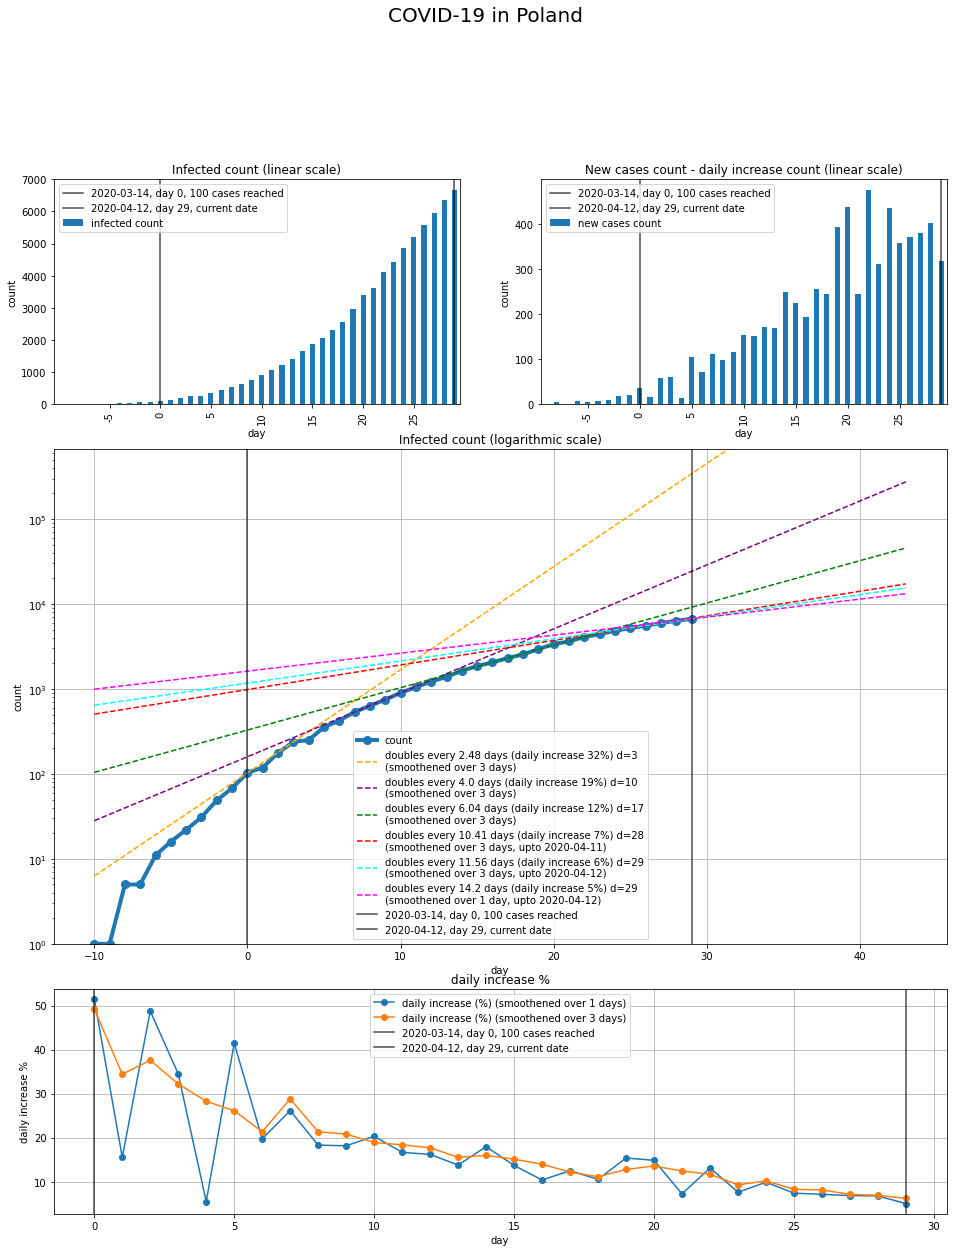

Saved analysis to: output/covid/by_country/Poland_covid_plot.jpeg
China Hubei
Saved analysis to: output/covid/by_country/Hubei_China_covid_analysis.xlsx


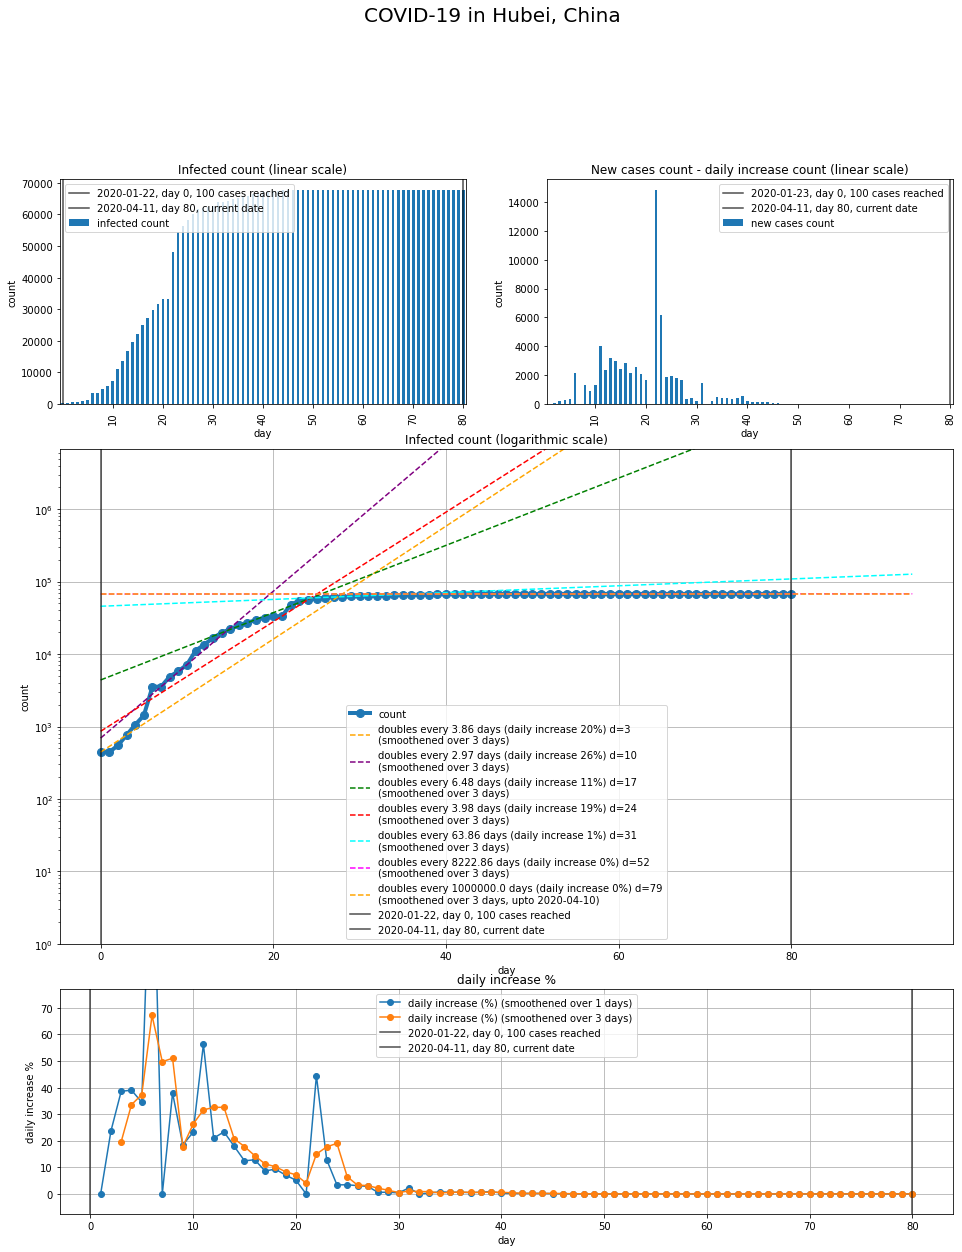

Saved analysis to: output/covid/by_country/Hubei_China_covid_plot.jpeg
Korea, South None
Saved analysis to: output/covid/by_country/Korea, South_covid_analysis.xlsx


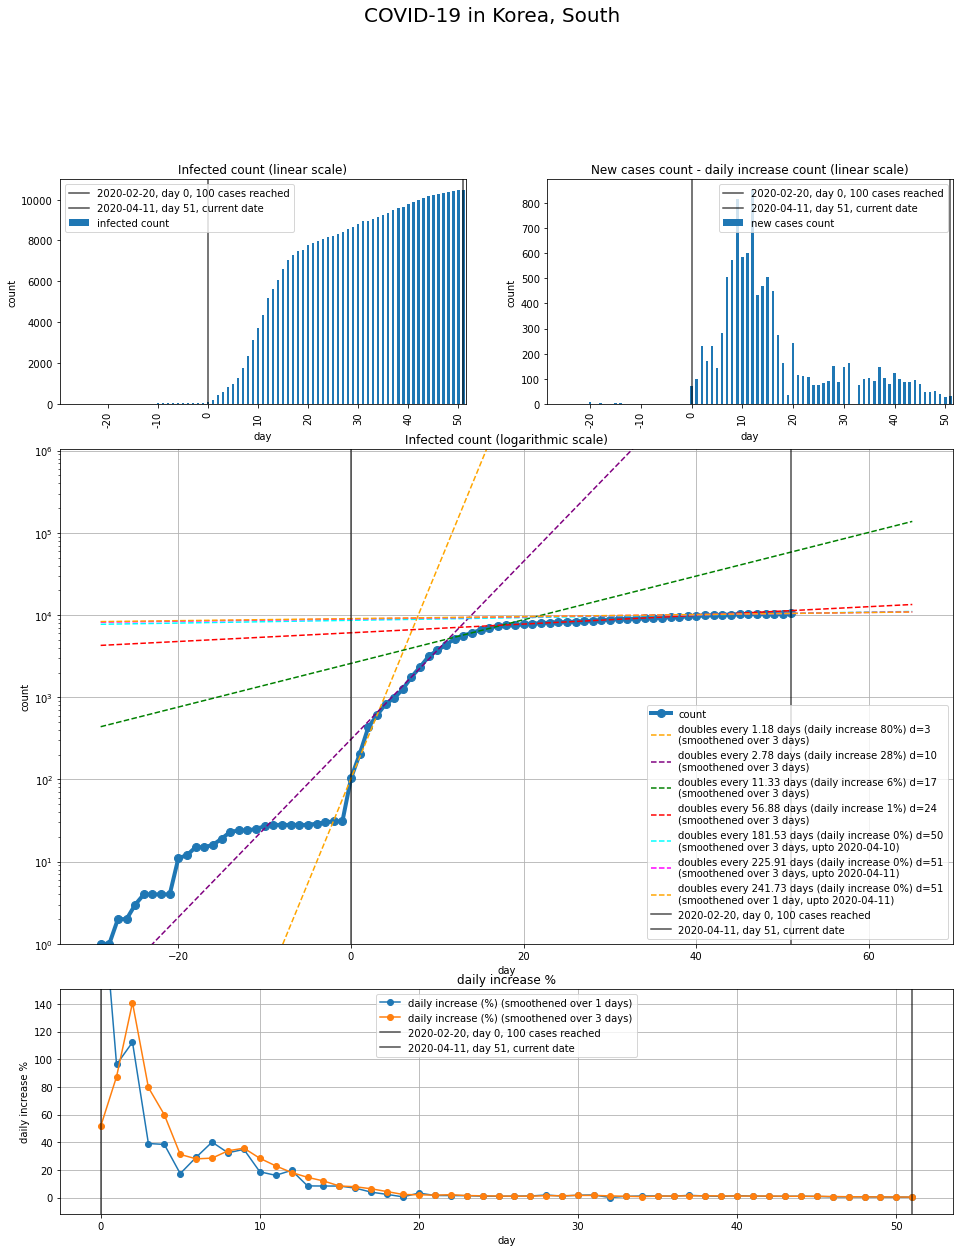

Saved analysis to: output/covid/by_country/Korea, South_covid_plot.jpeg
Italy None
Saved analysis to: output/covid/by_country/Italy_covid_analysis.xlsx


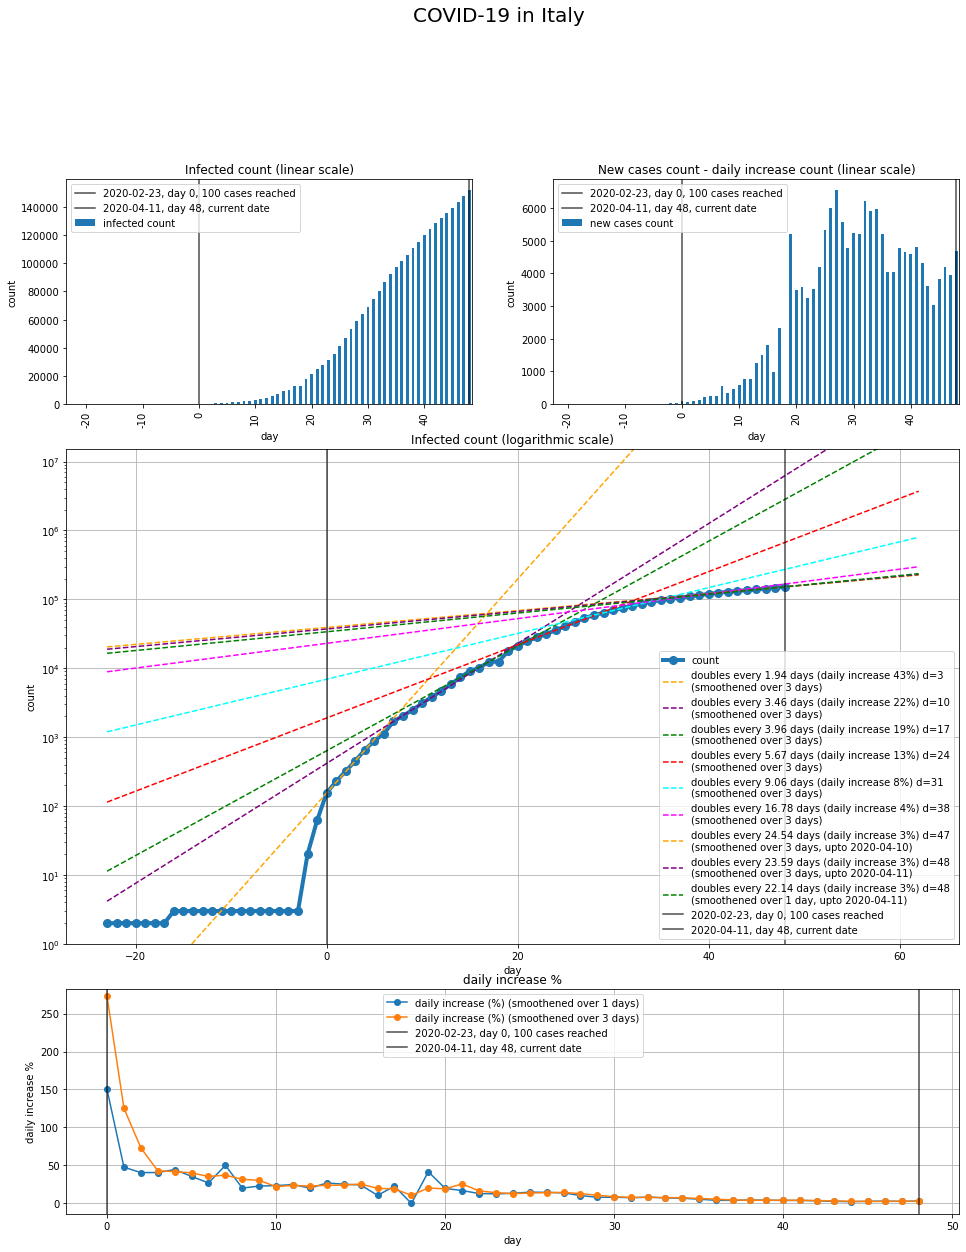

Saved analysis to: output/covid/by_country/Italy_covid_plot.jpeg
Germany None
Saved analysis to: output/covid/by_country/Germany_covid_analysis.xlsx


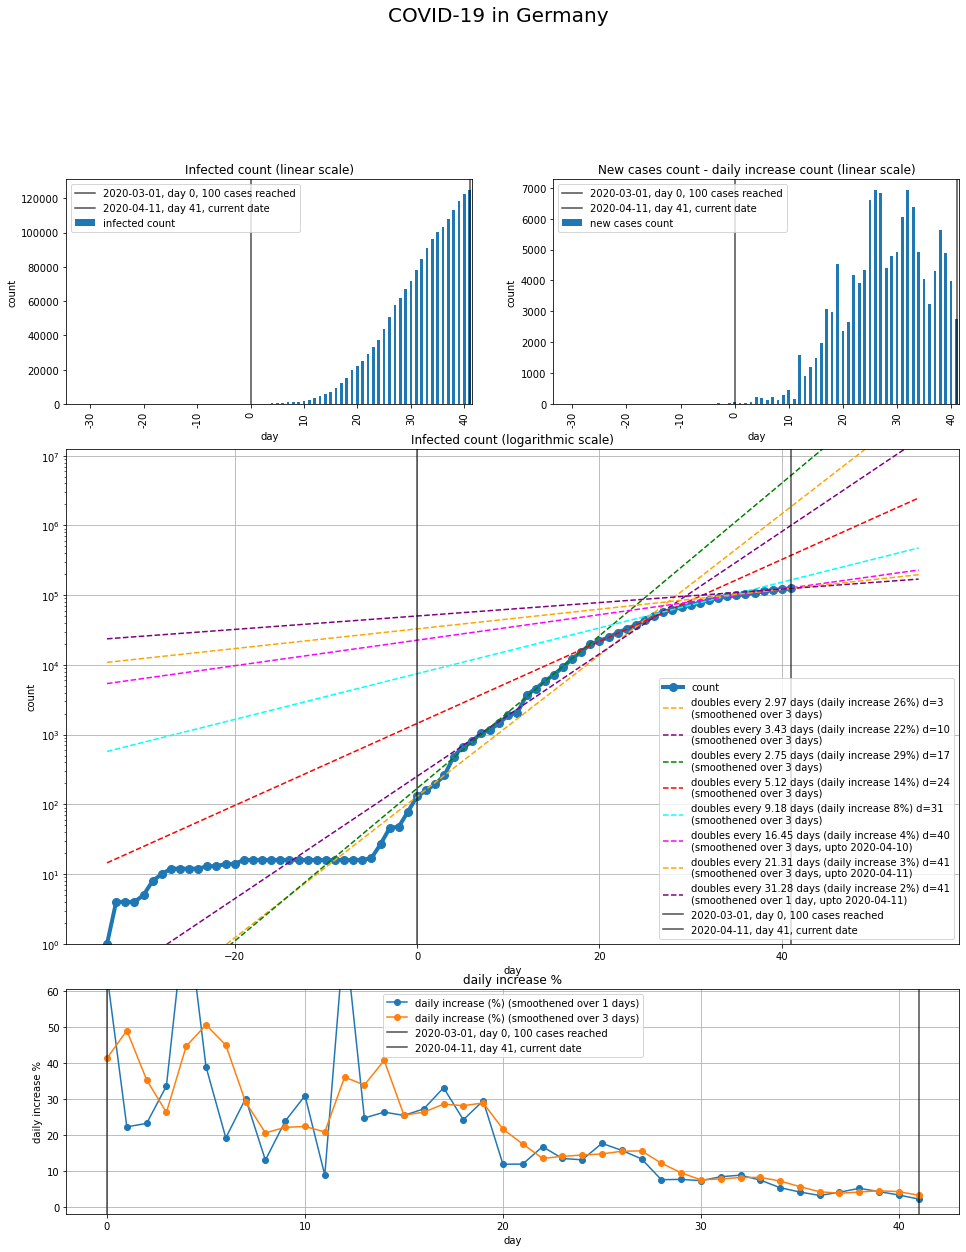

Saved analysis to: output/covid/by_country/Germany_covid_plot.jpeg
Spain None
Saved analysis to: output/covid/by_country/Spain_covid_analysis.xlsx


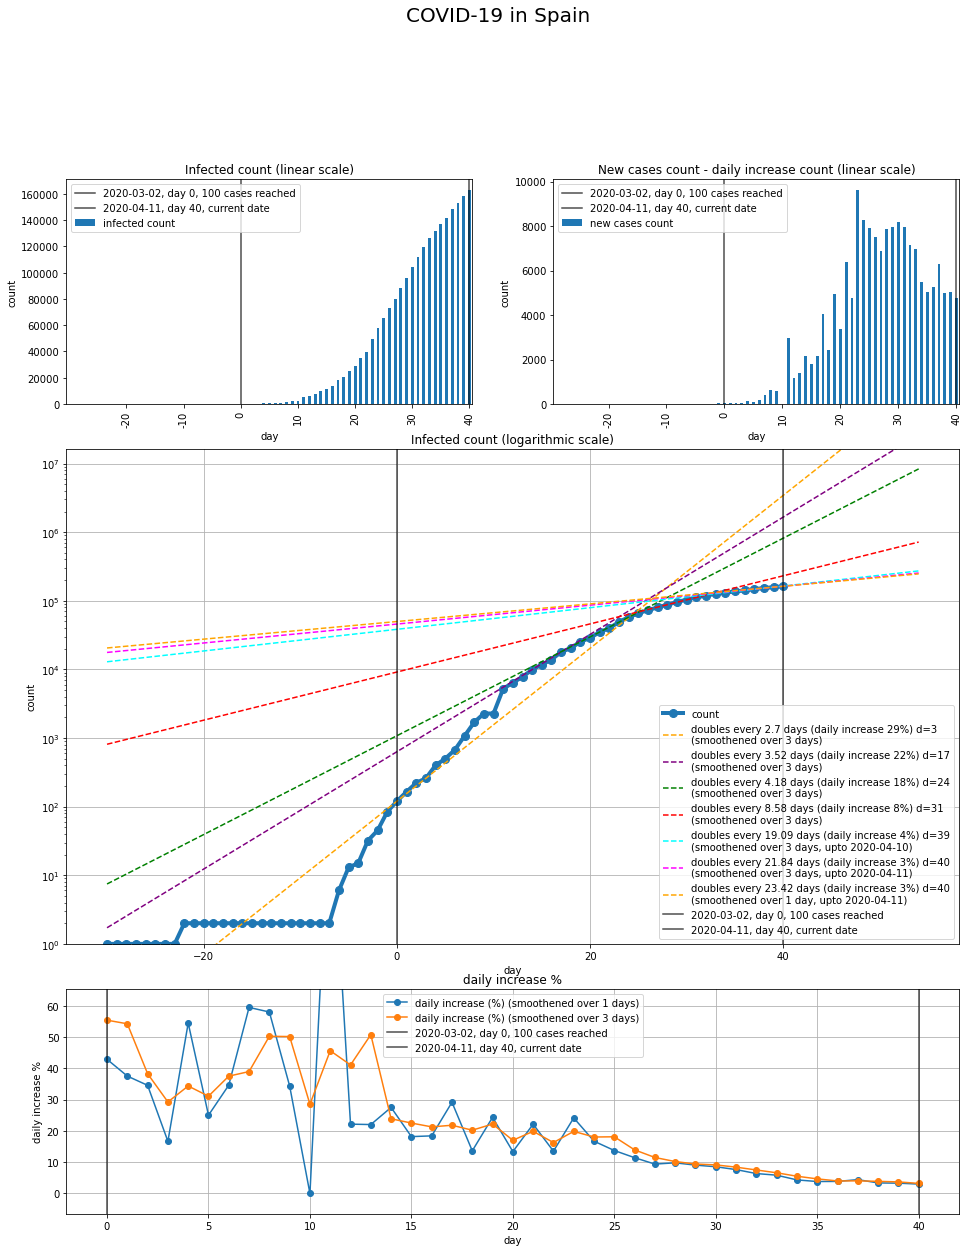

Saved analysis to: output/covid/by_country/Spain_covid_plot.jpeg
France None
Saved analysis to: output/covid/by_country/France_covid_analysis.xlsx


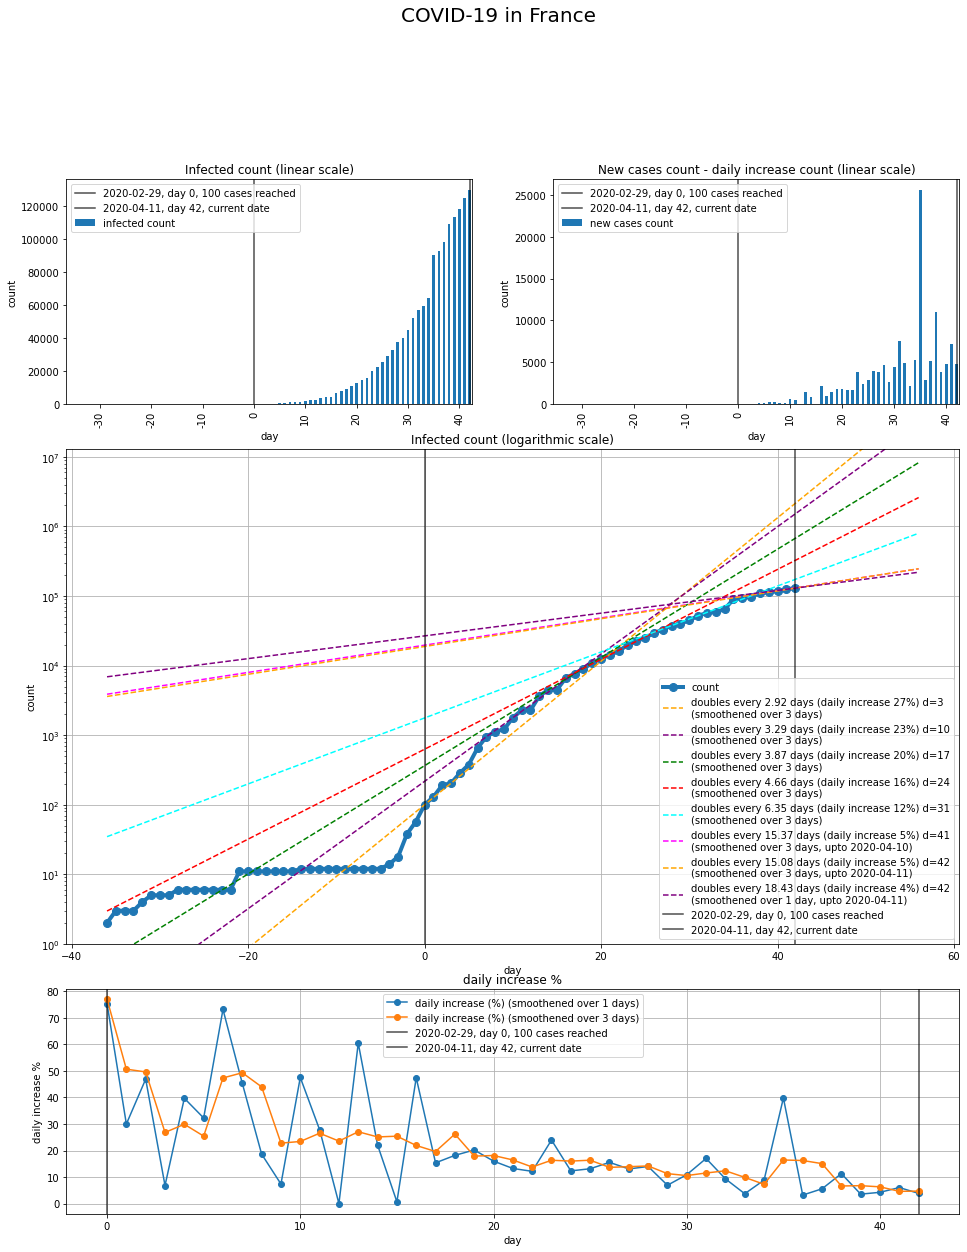

Saved analysis to: output/covid/by_country/France_covid_plot.jpeg
US New York
Saved analysis to: output/covid/by_country/New York_US_covid_analysis.xlsx


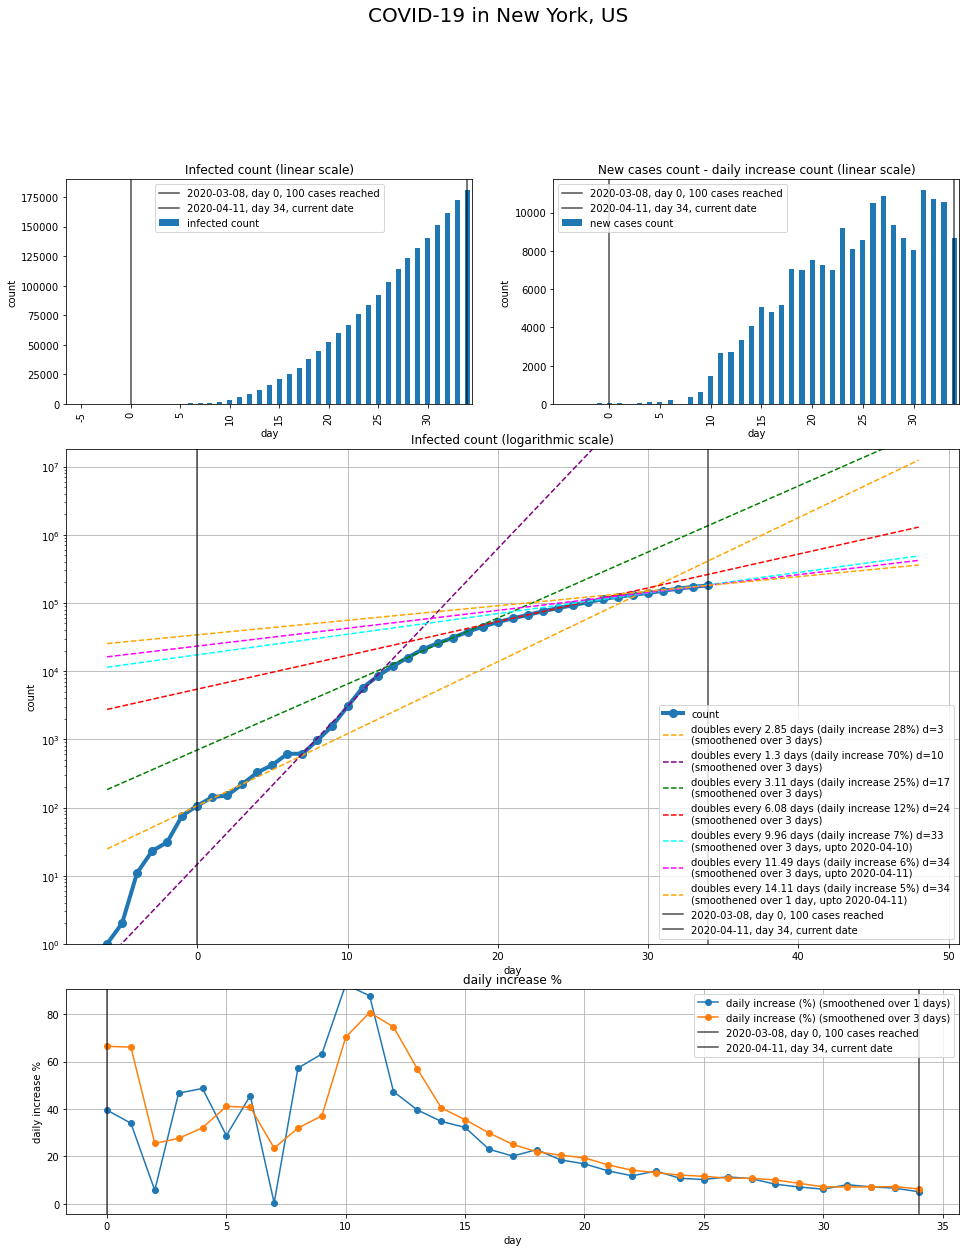

Saved analysis to: output/covid/by_country/New York_US_covid_plot.jpeg
Japan None
Saved analysis to: output/covid/by_country/Japan_covid_analysis.xlsx


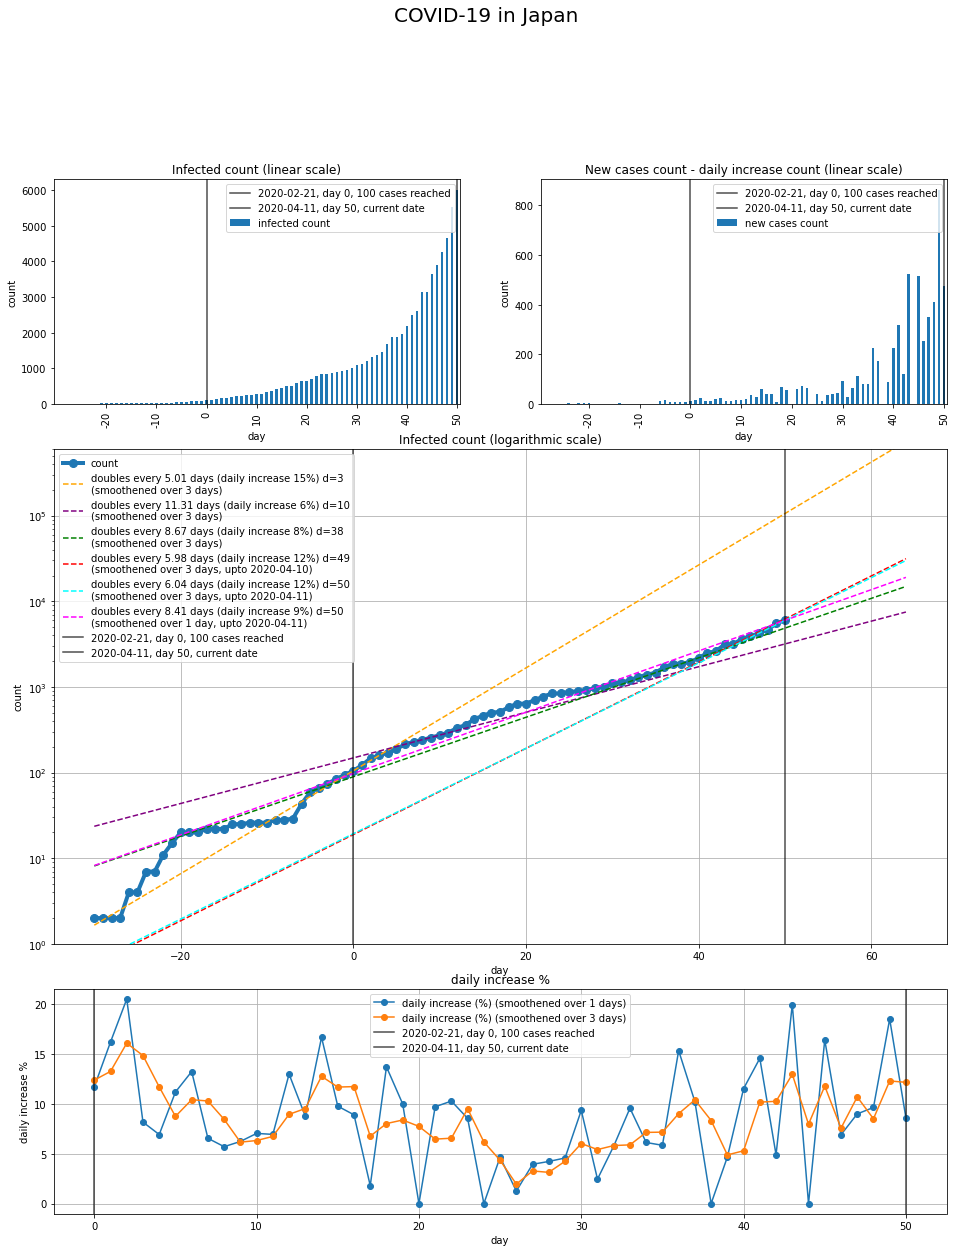

Saved analysis to: output/covid/by_country/Japan_covid_plot.jpeg
Belarus None
Saved analysis to: output/covid/by_country/Belarus_covid_analysis.xlsx


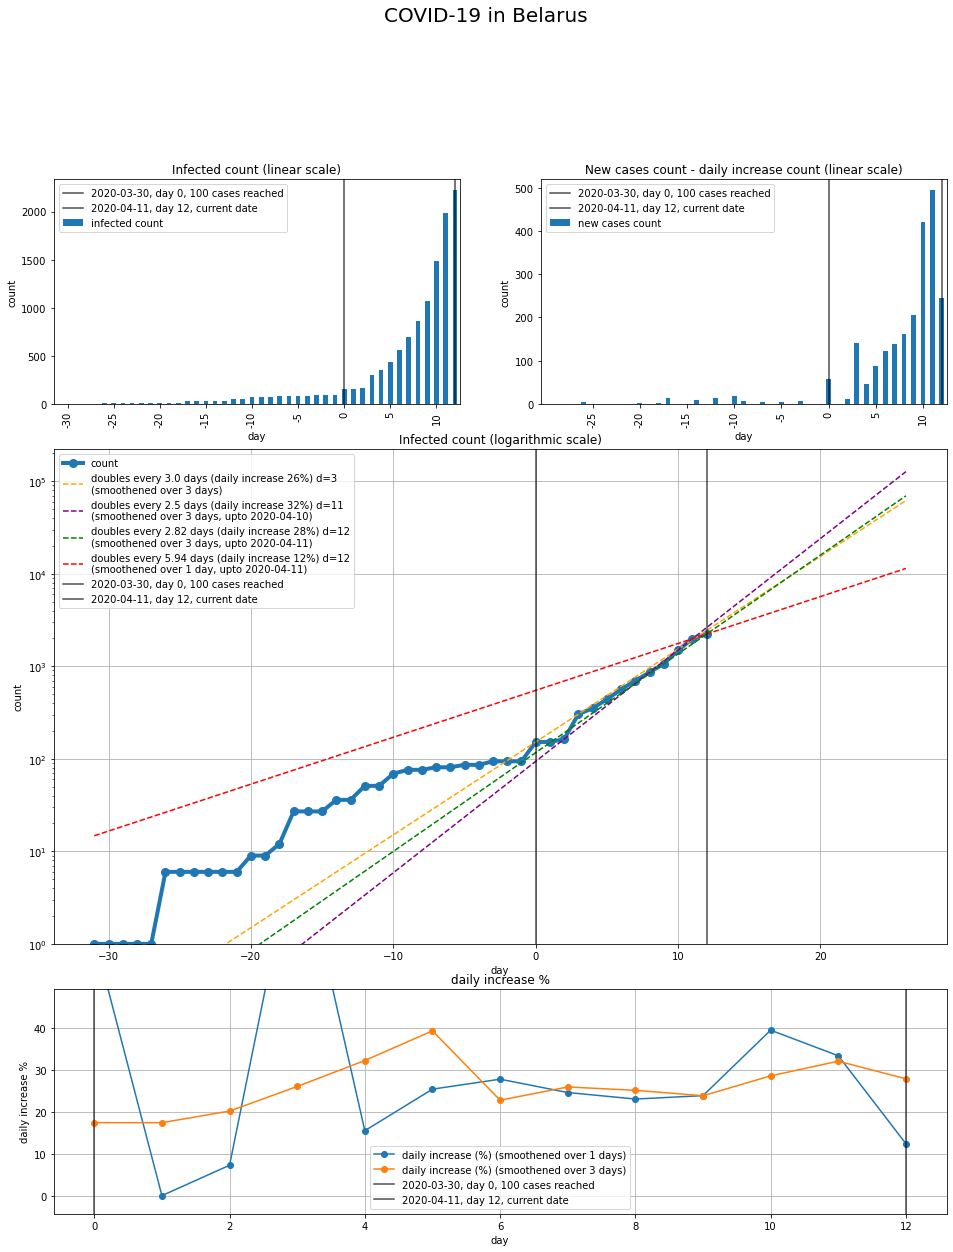

Saved analysis to: output/covid/by_country/Belarus_covid_plot.jpeg
Czechia None
Saved analysis to: output/covid/by_country/Czechia_covid_analysis.xlsx


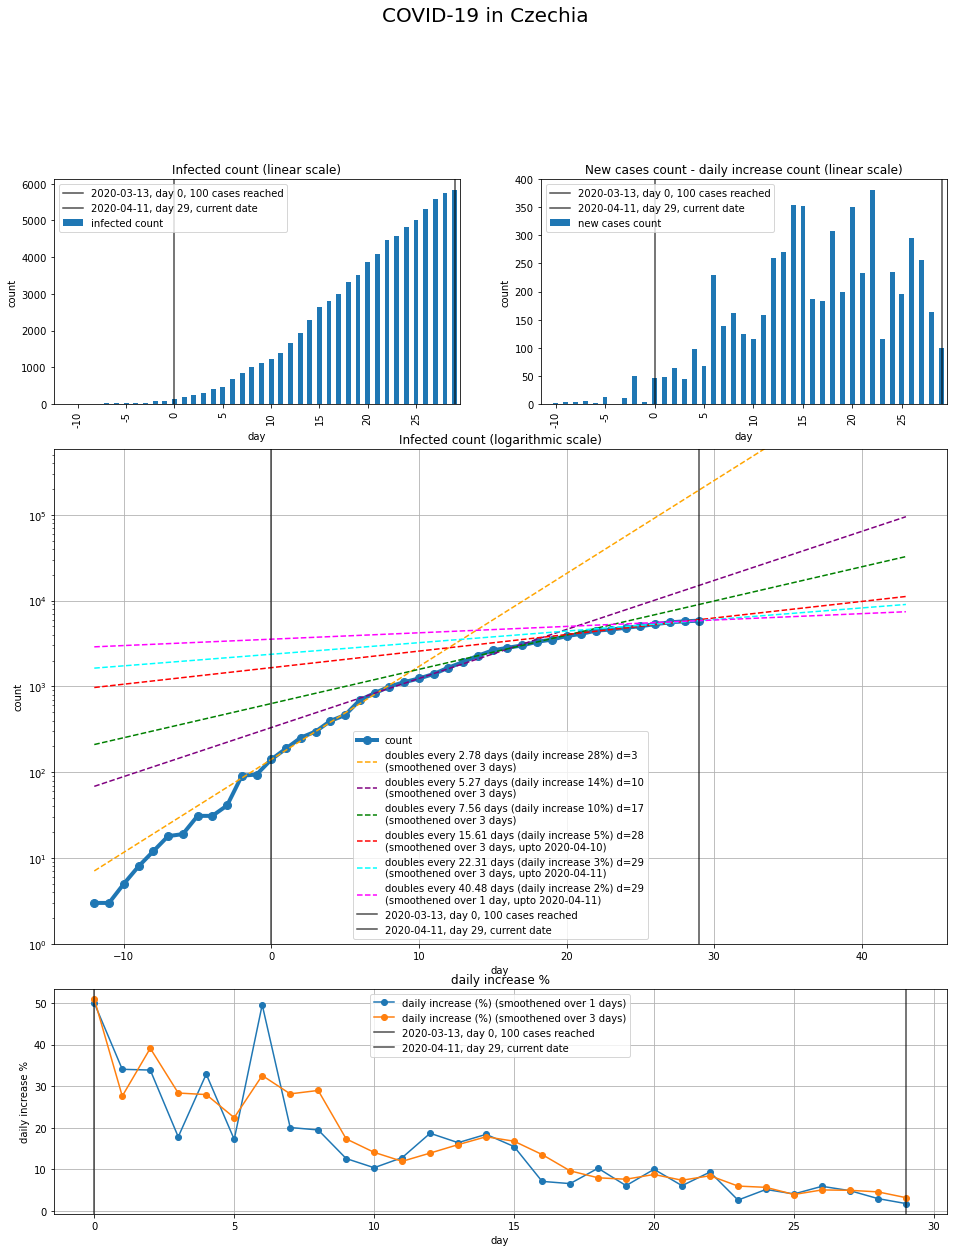

Saved analysis to: output/covid/by_country/Czechia_covid_plot.jpeg
Slovakia None
Saved analysis to: output/covid/by_country/Slovakia_covid_analysis.xlsx


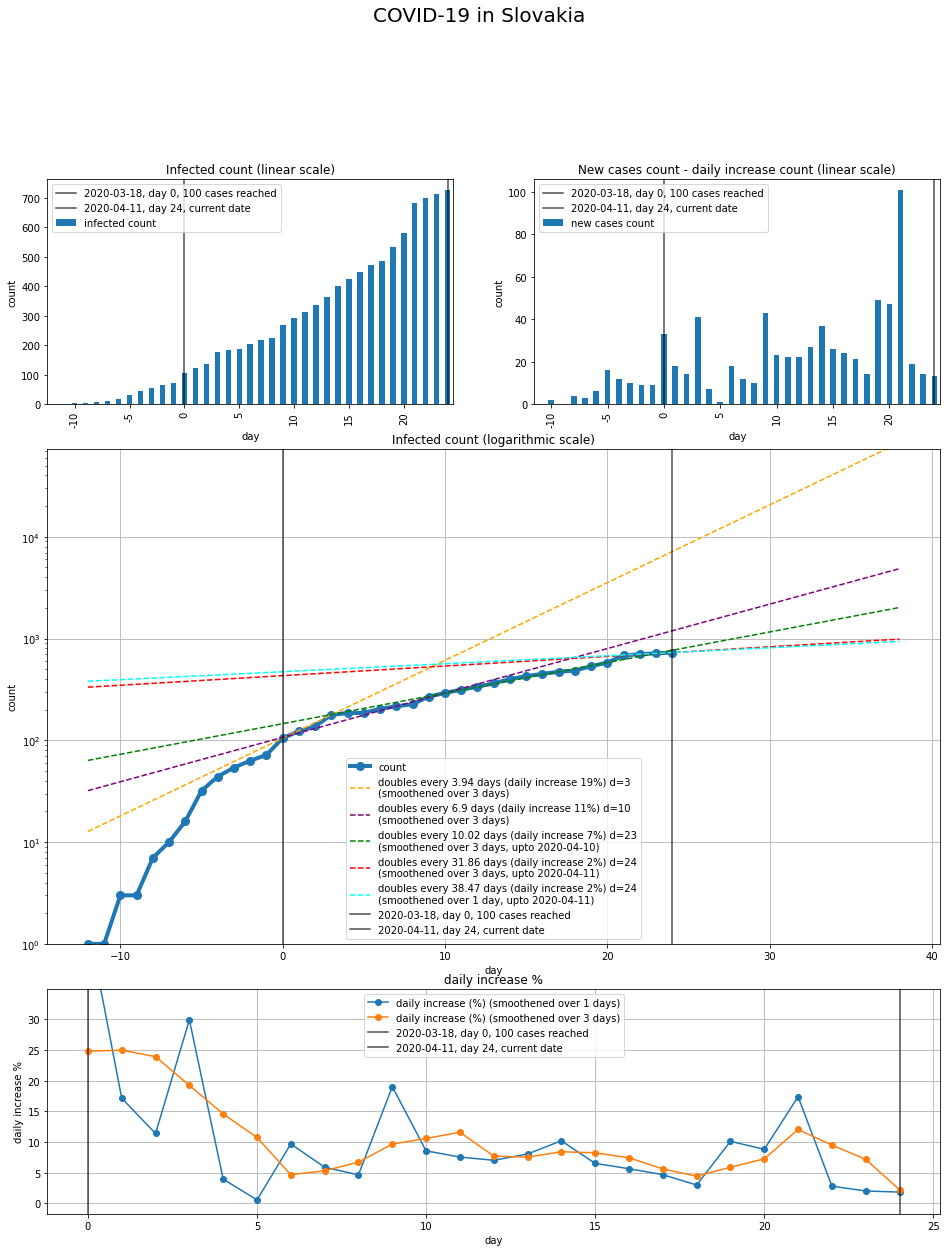

Saved analysis to: output/covid/by_country/Slovakia_covid_plot.jpeg
US None
Saved analysis to: output/covid/by_country/US_covid_analysis.xlsx


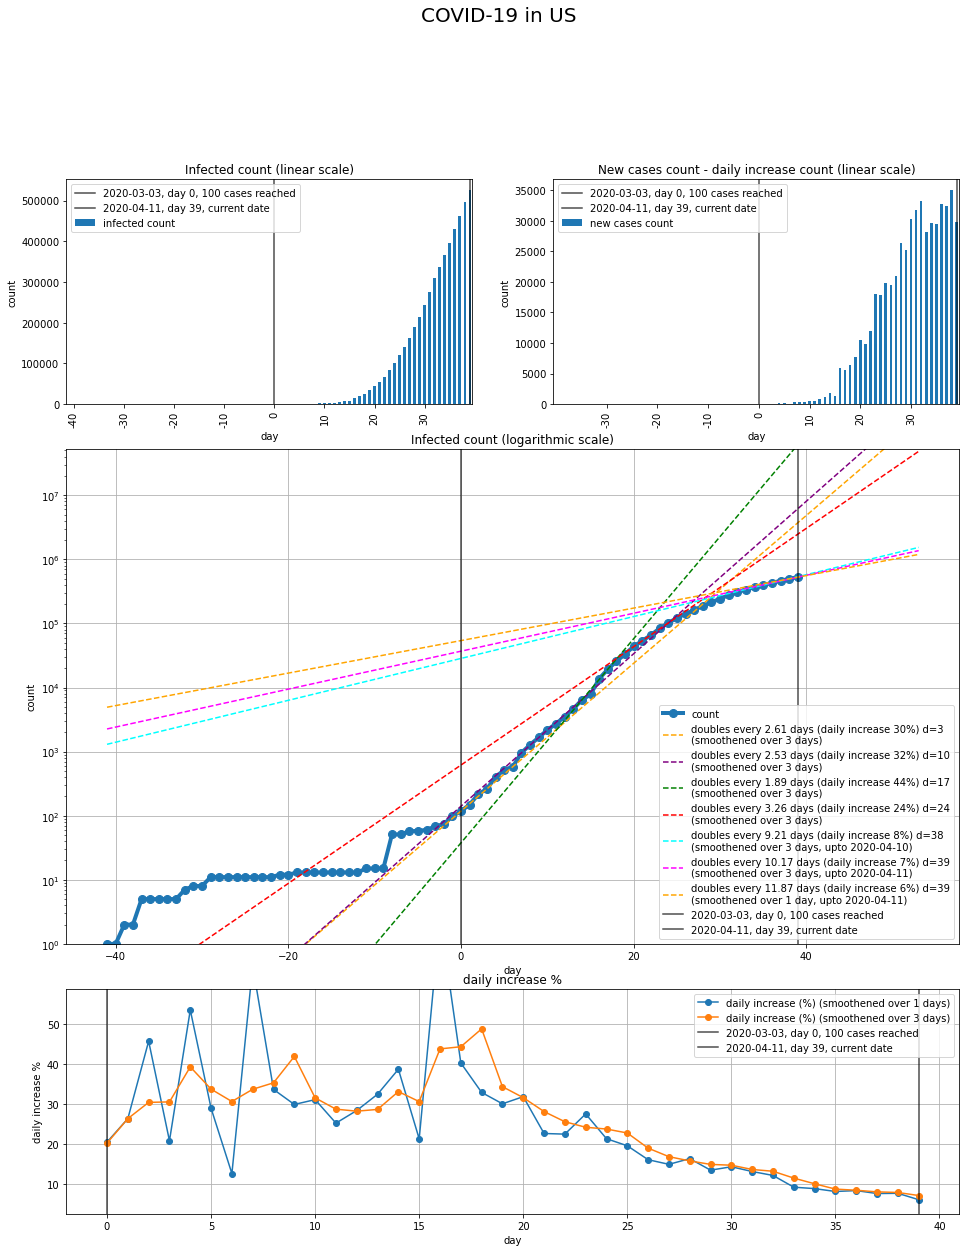

Saved analysis to: output/covid/by_country/US_covid_plot.jpeg
US New Jersey
Saved analysis to: output/covid/by_country/New Jersey_US_covid_analysis.xlsx


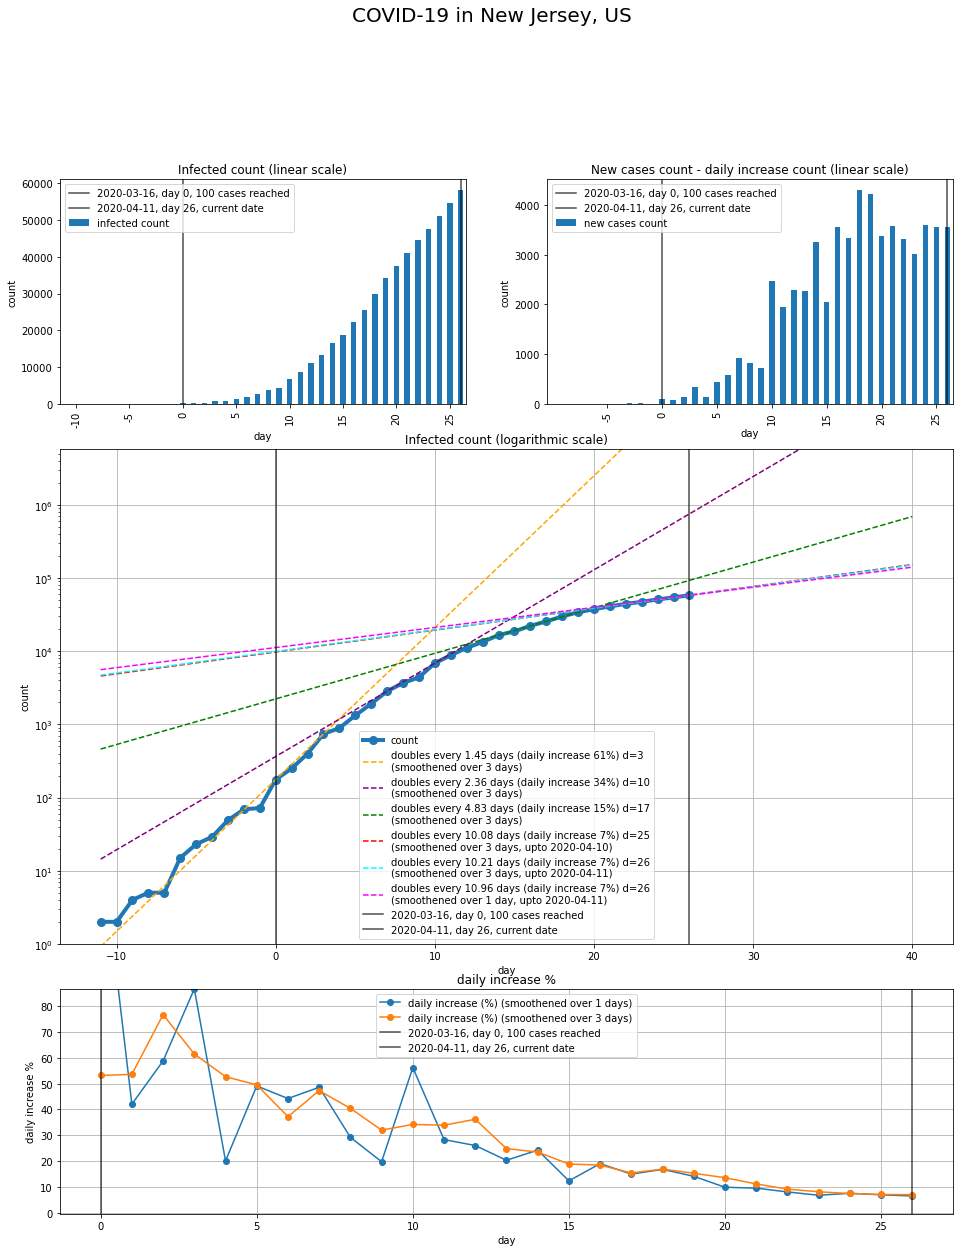

Saved analysis to: output/covid/by_country/New Jersey_US_covid_plot.jpeg
Austria None
Saved analysis to: output/covid/by_country/Austria_covid_analysis.xlsx


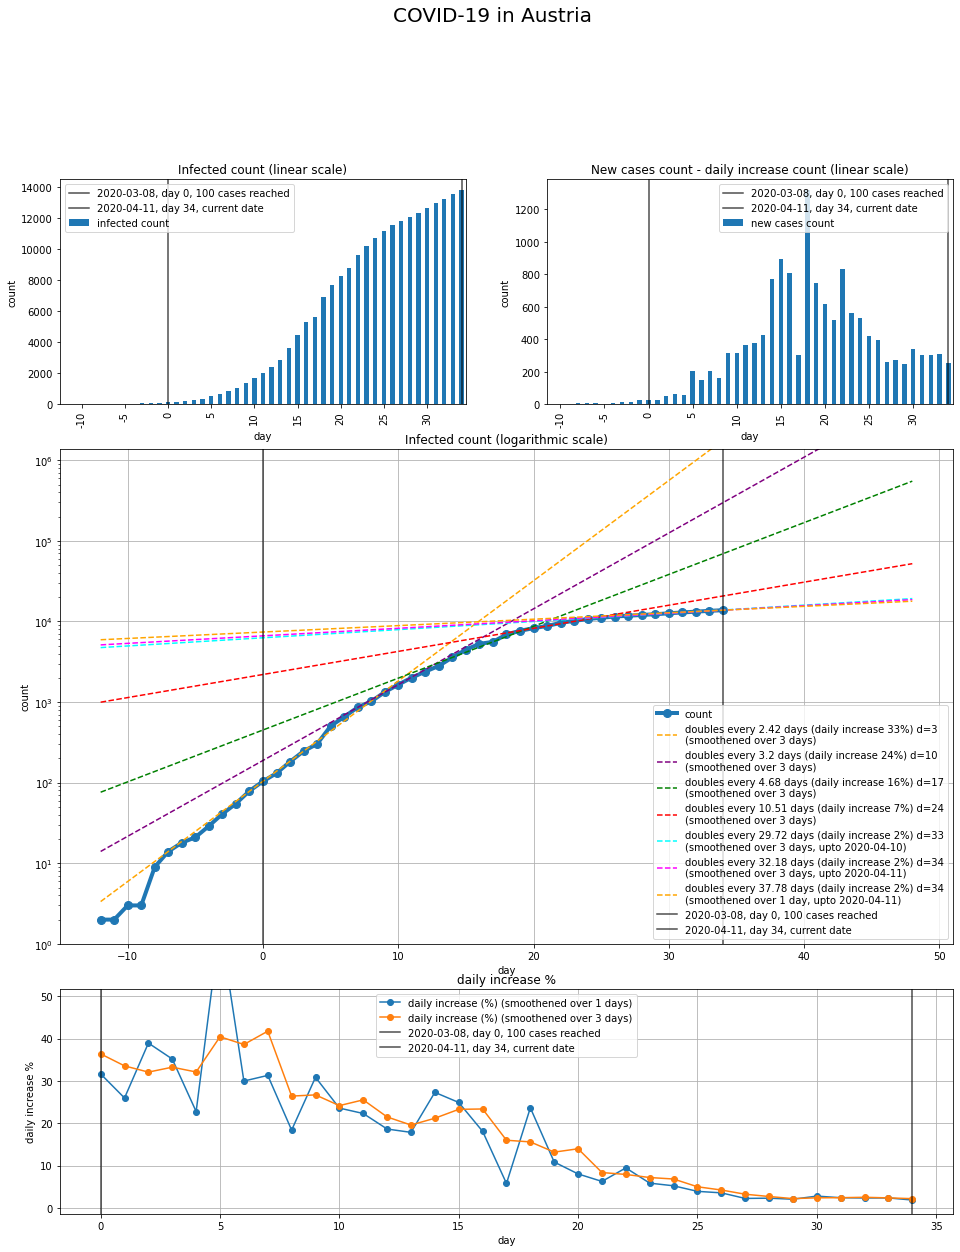

Saved analysis to: output/covid/by_country/Austria_covid_plot.jpeg
Switzerland None
Saved analysis to: output/covid/by_country/Switzerland_covid_analysis.xlsx


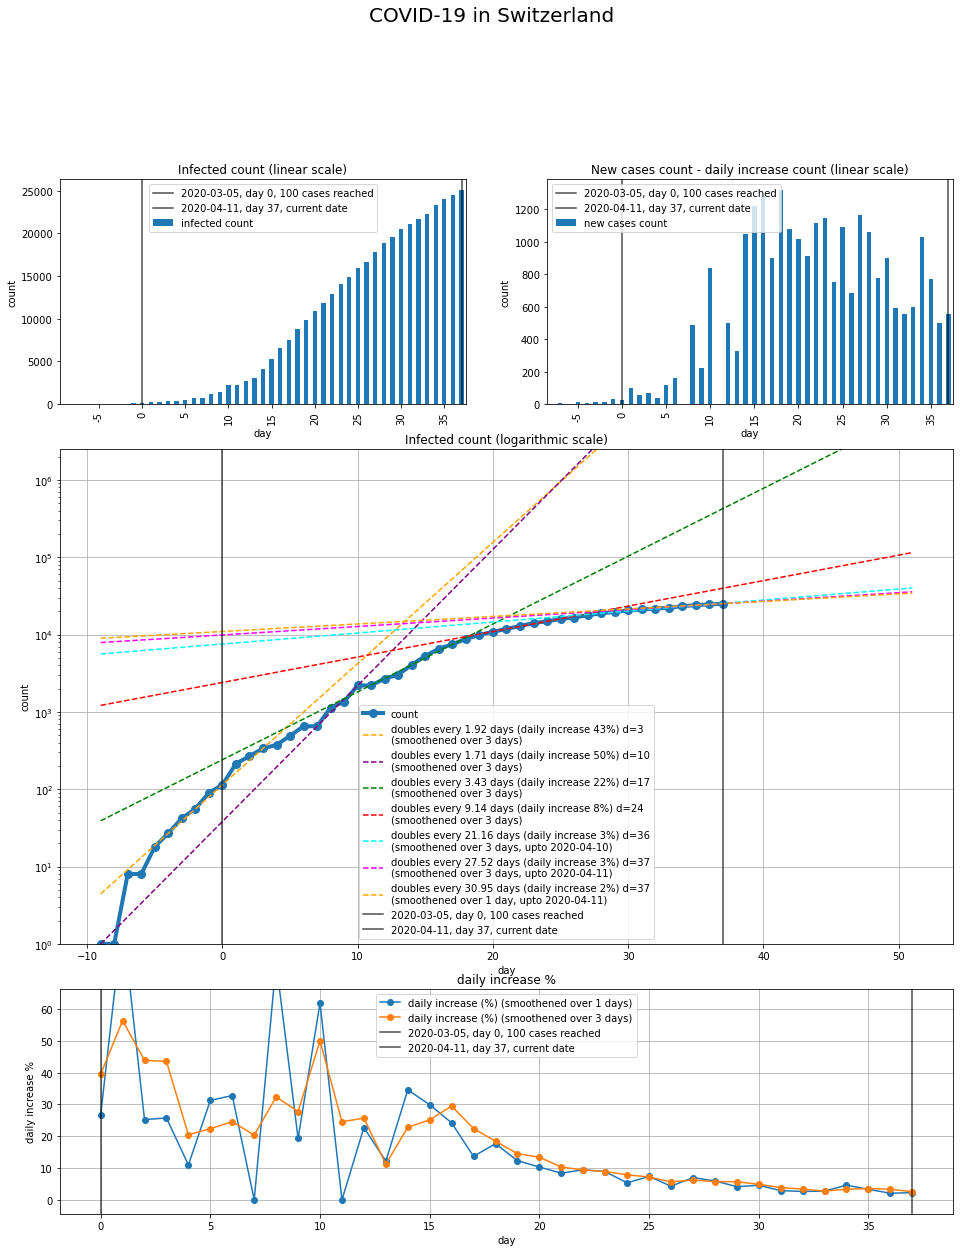

Saved analysis to: output/covid/by_country/Switzerland_covid_plot.jpeg
Belgium None
Saved analysis to: output/covid/by_country/Belgium_covid_analysis.xlsx


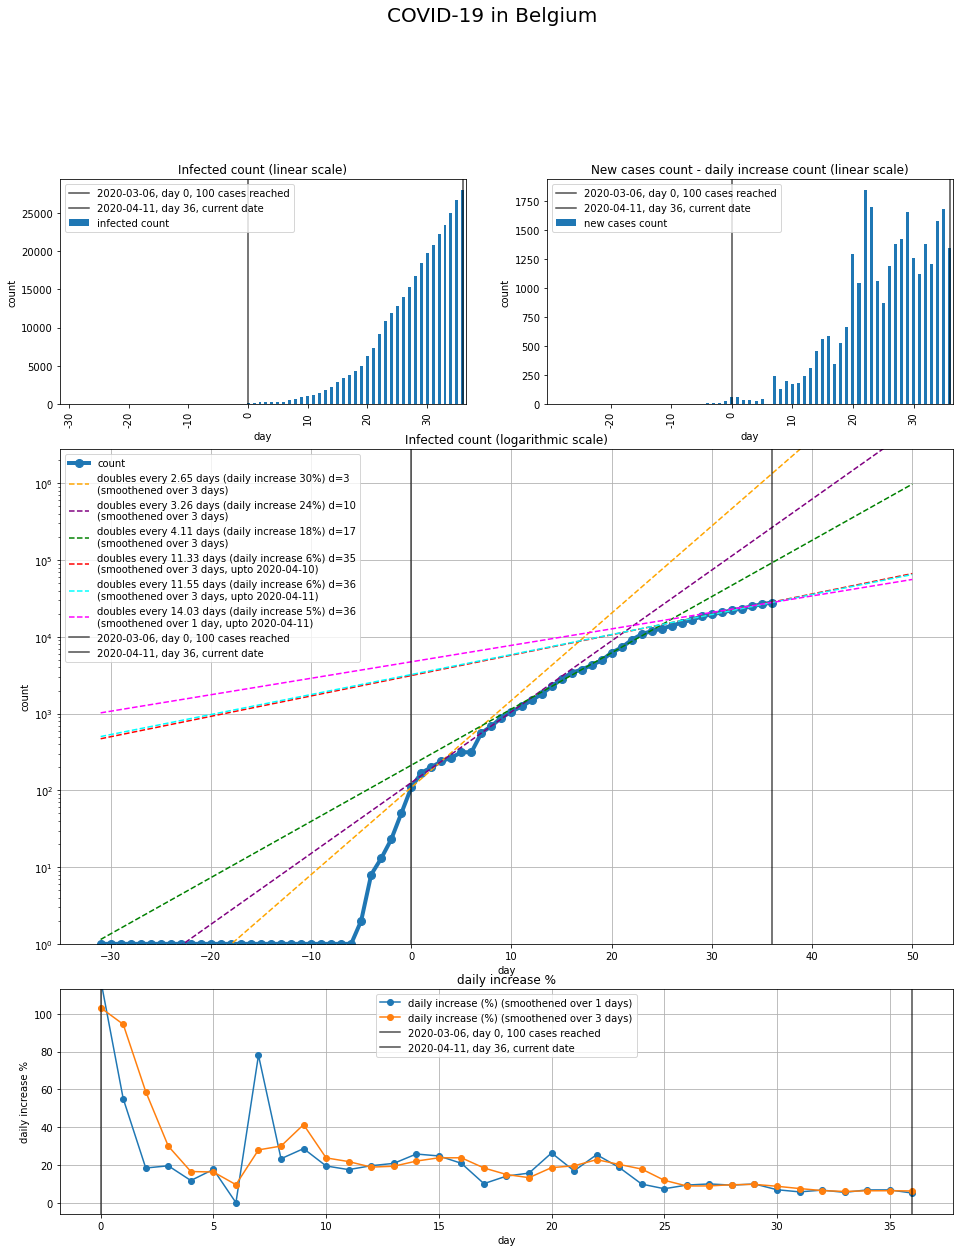

Saved analysis to: output/covid/by_country/Belgium_covid_plot.jpeg
Australia None
Saved analysis to: output/covid/by_country/Australia_covid_analysis.xlsx


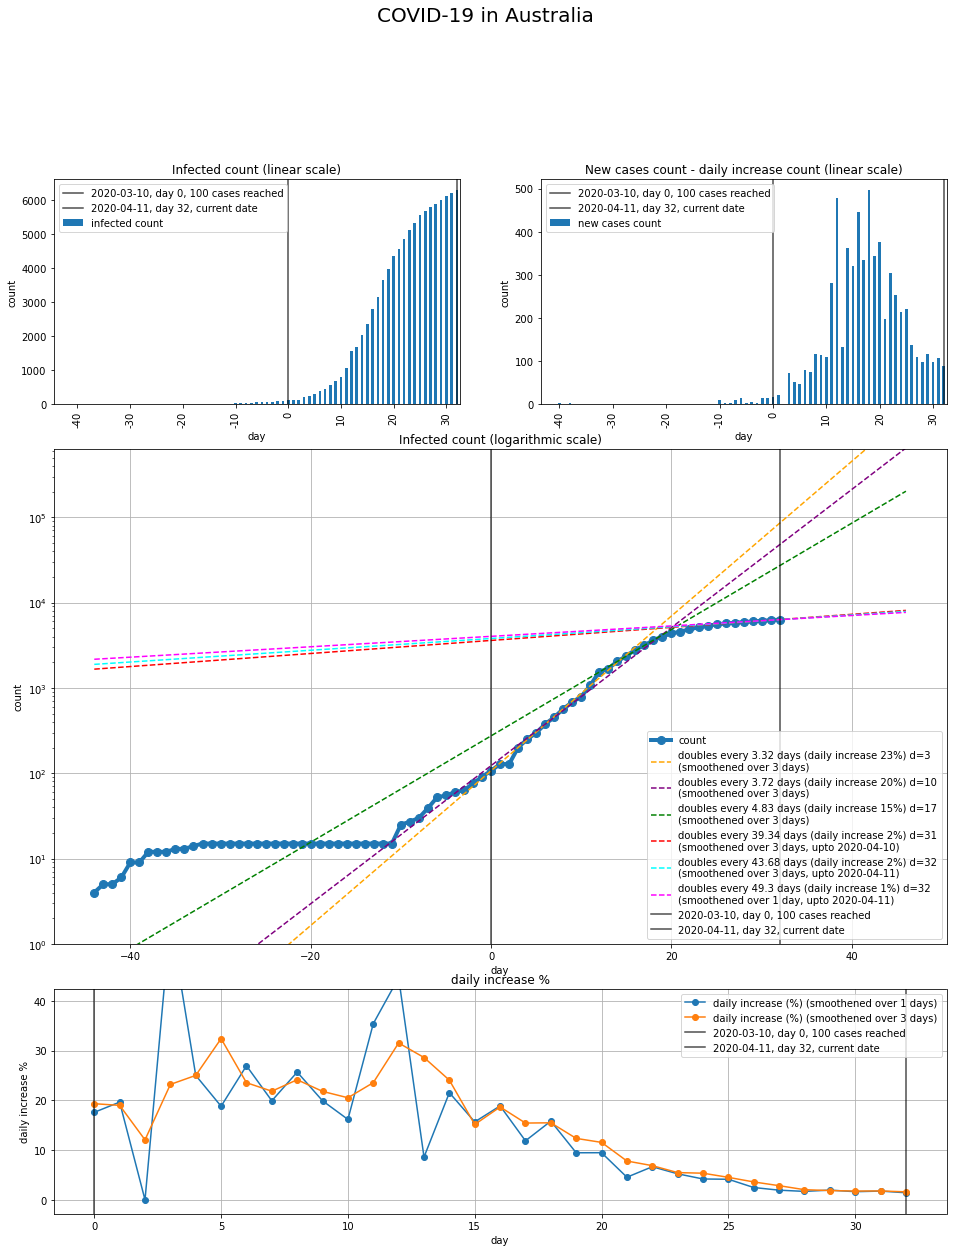

Saved analysis to: output/covid/by_country/Australia_covid_plot.jpeg
Canada None
Saved analysis to: output/covid/by_country/Canada_covid_analysis.xlsx


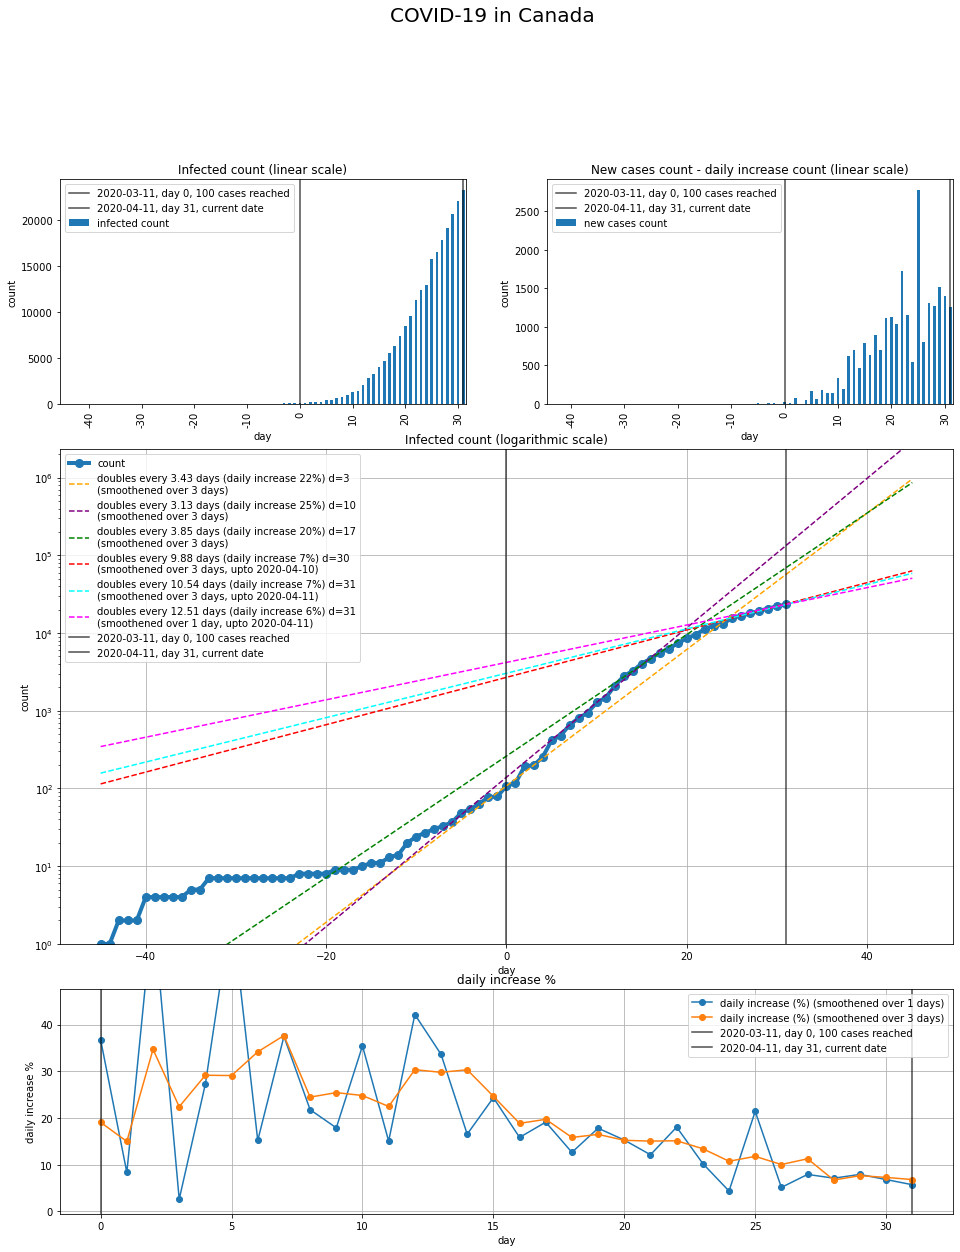

Saved analysis to: output/covid/by_country/Canada_covid_plot.jpeg
Israel None
Saved analysis to: output/covid/by_country/Israel_covid_analysis.xlsx


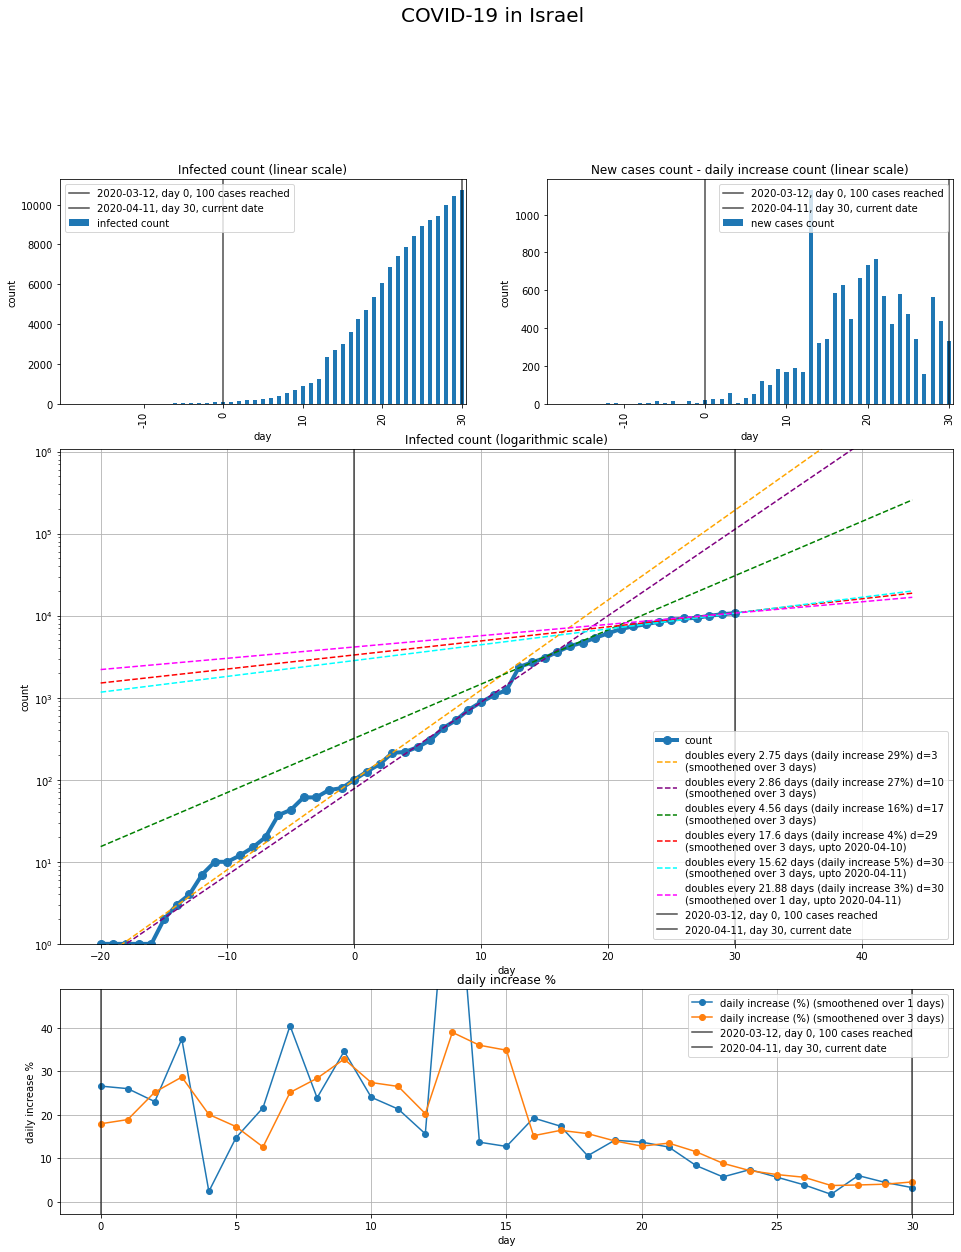

Saved analysis to: output/covid/by_country/Israel_covid_plot.jpeg
South Africa None
Saved analysis to: output/covid/by_country/South Africa_covid_analysis.xlsx


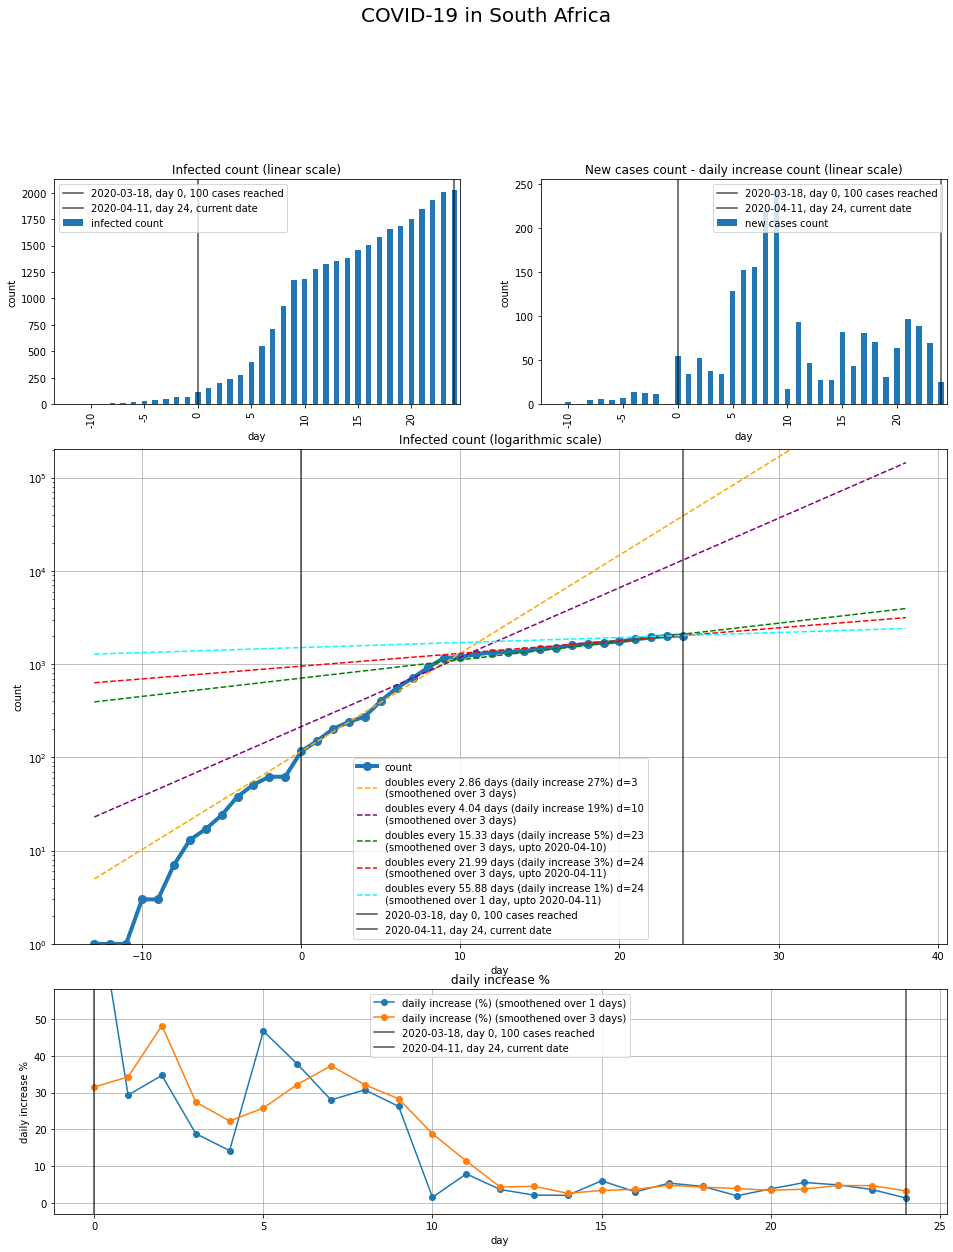

Saved analysis to: output/covid/by_country/South Africa_covid_plot.jpeg
Turkey None
Saved analysis to: output/covid/by_country/Turkey_covid_analysis.xlsx


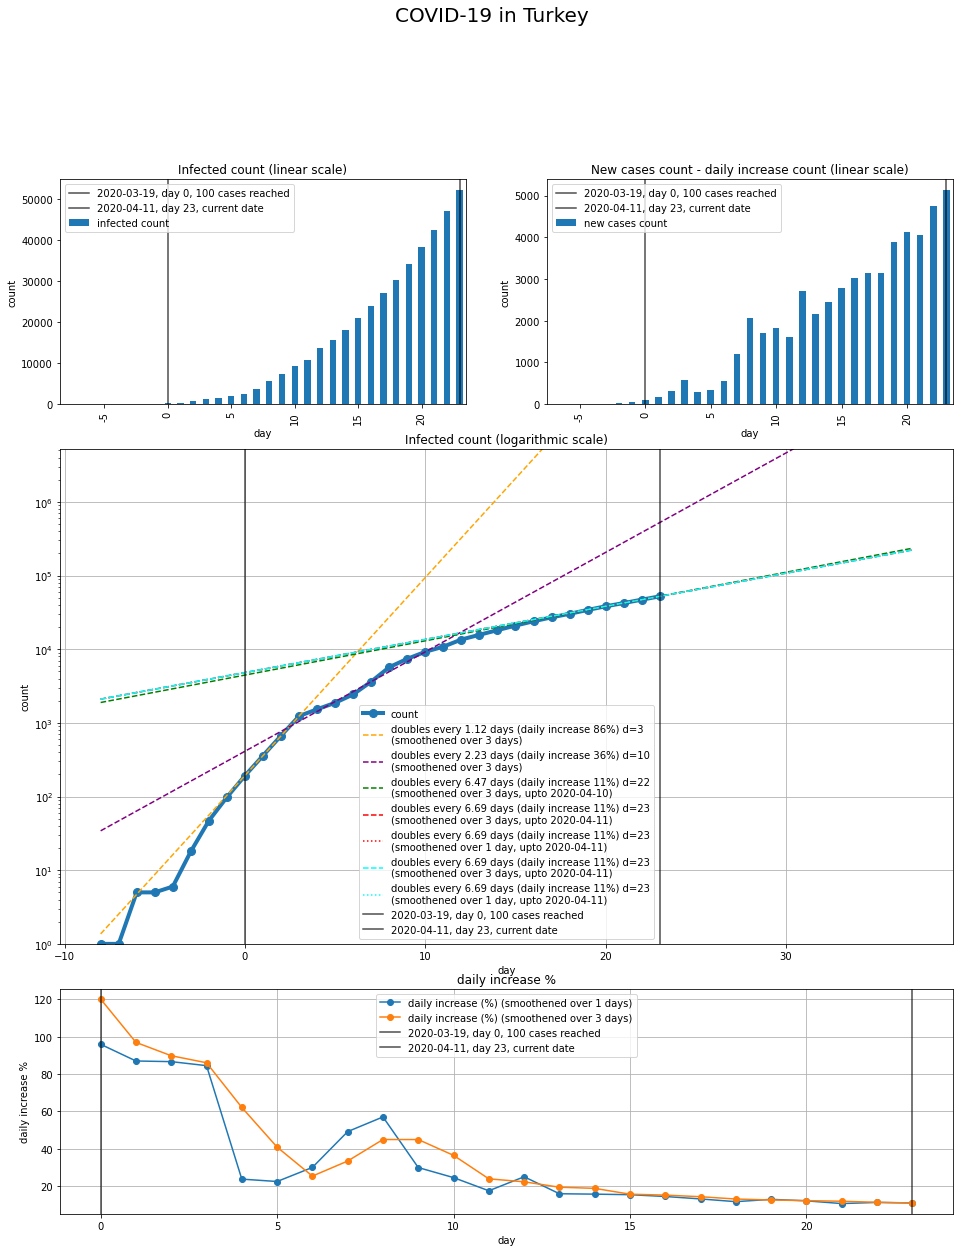

Saved analysis to: output/covid/by_country/Turkey_covid_plot.jpeg
Iran None
Saved analysis to: output/covid/by_country/Iran_covid_analysis.xlsx


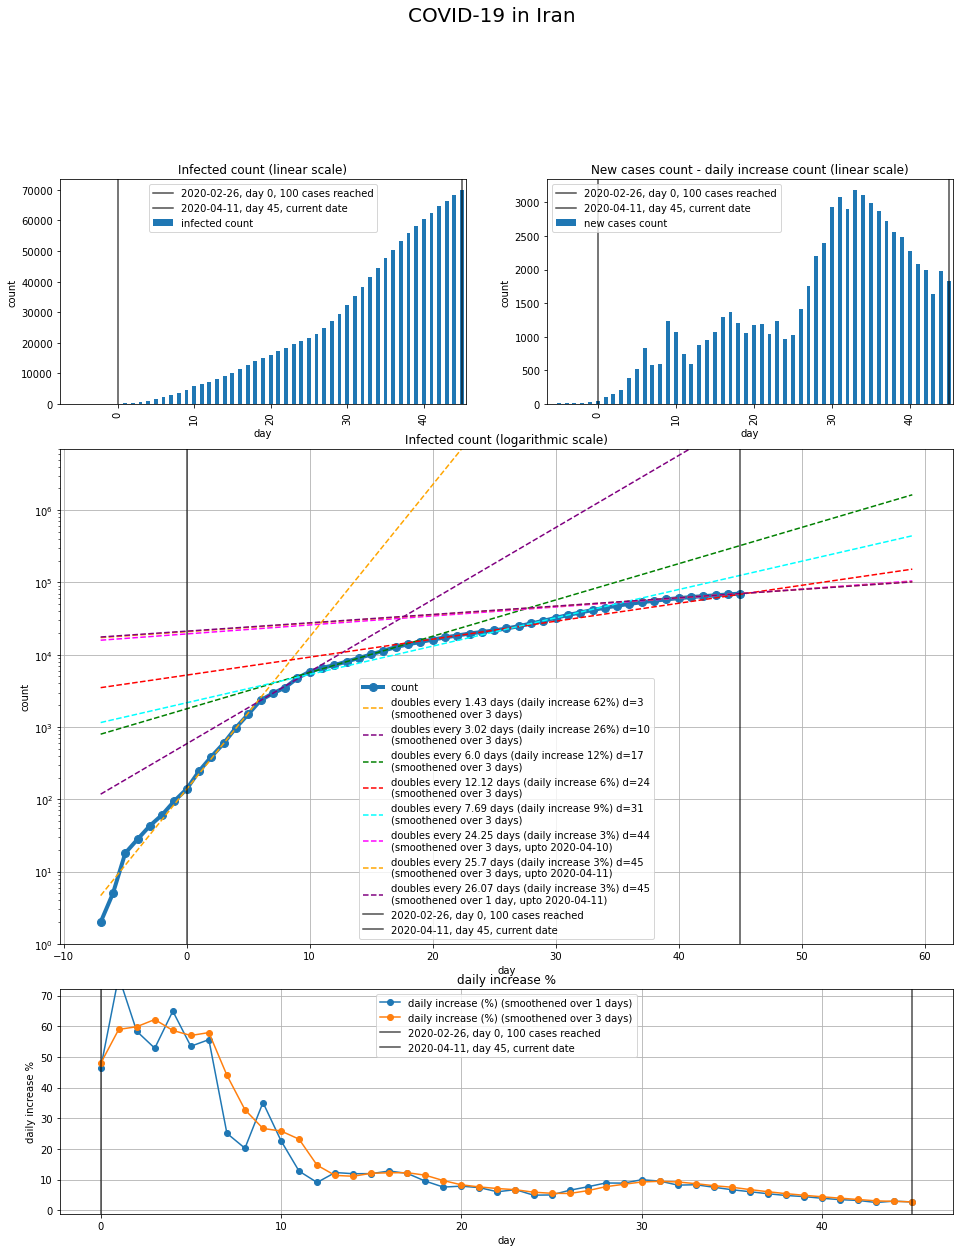

Saved analysis to: output/covid/by_country/Iran_covid_plot.jpeg
Russia None
Saved analysis to: output/covid/by_country/Russia_covid_analysis.xlsx


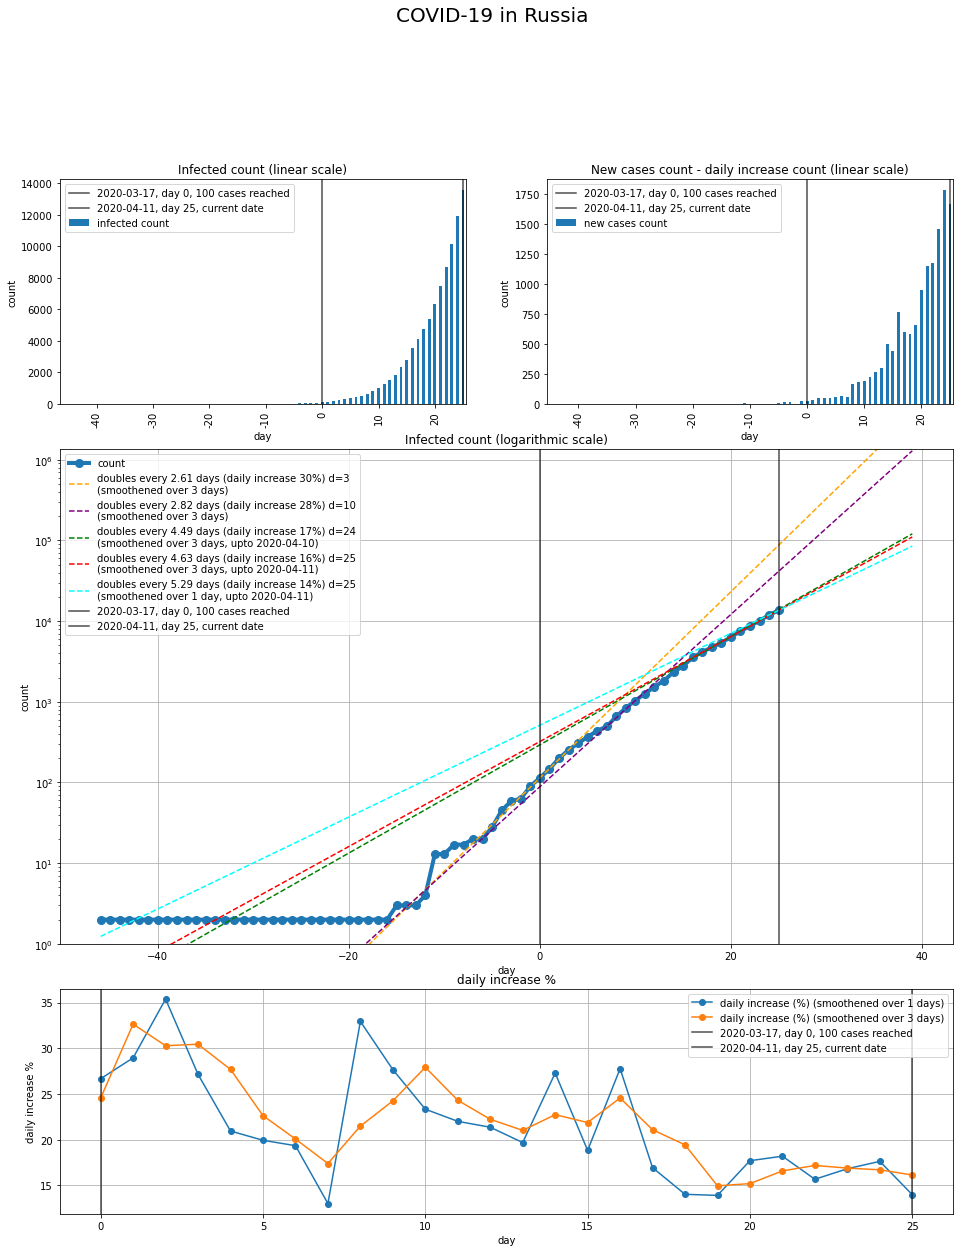

Saved analysis to: output/covid/by_country/Russia_covid_plot.jpeg
Belarus None
Saved analysis to: output/covid/by_country/Belarus_covid_analysis.xlsx


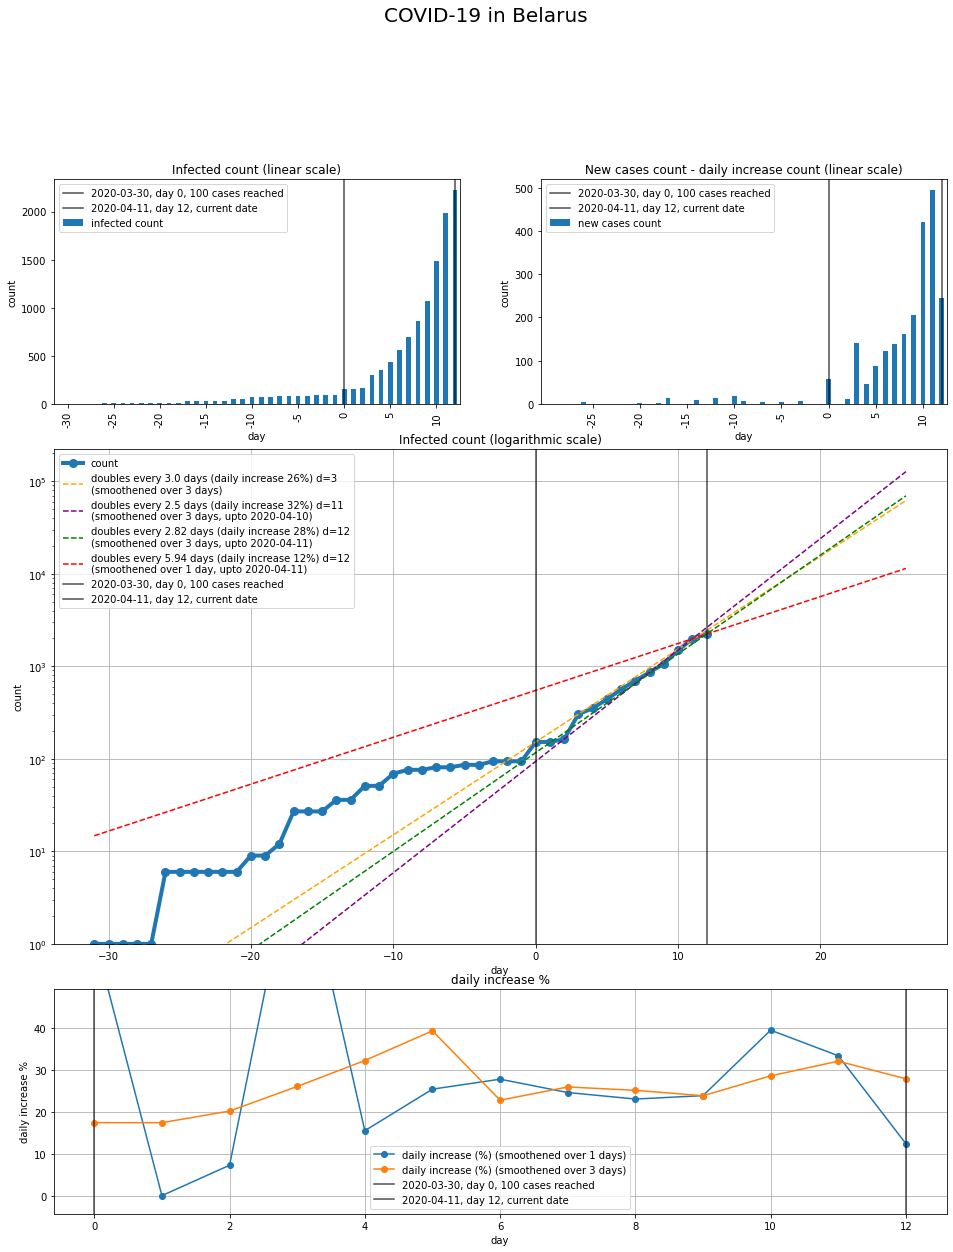

Saved analysis to: output/covid/by_country/Belarus_covid_plot.jpeg


In [6]:
for country in countries:
    read_data_plot_country(country['country'], country['province'], output_folder='by_country/')

# Plot all countries

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


infected count  infected count per million current date  \
New York, US          181026                        9305   2020-04-11   
Spain                 163027                        3461   2020-04-11   
Italy                 152271                        2527   2020-04-11   
France                129654                        1932   2020-04-11   
Germany               124908                        1502   2020-04-11   
Hubei, China           67803                        1159   2020-04-11   
Belarus                 2226                         236   2020-04-11   
Korea, South           10480                         202   2020-04-11   
Poland                  6674                         173   2020-04-12   
Japan                   6005                          47   2020-04-11   

              daily increase % (smoothened over last 7 days)  \
New York, US                                           0.076   
Spain                                                  0.041   
Italy                                                  0.030   
France                                                 0.099   
Germany                                                0.043   
Hubei, China                                           0.000   
Belarus                                                0.280   
Korea, South                                           0.005   
Poland                                                 0.083   
Japan                                                  0.113   

              doubles every ... days  \
New York, US                    9.42   
Spain                          17.11   
Italy                          23.29   
France                          7.32   
Germany                        16.57   
Hubei, China               247543.11   
Belarus                         2.80   
Korea, South                  128.22   
Poland                          8.65   
Japan                           6.49   

              days since at least 1 per million infected  \
New York, US                                          31   
Spain                                                 35   
Italy                                                 44   
France                                                35   
Germany                                               34   
Hubei, China                                          77   
Belarus                                               12   
Korea, South                                          48   
Poland                                                23   
Japan                                                 17   

              days between 1st case and at least 10 per million infected  \
New York, US                                                  9            
Spain                                                        35            
Italy                                                        27            
France                                                       43            
Germany                                                      41            
Hubei, China                                                  3            
Belarus                                                      31            
Korea, South                                                 32            
Poland                                                       16            
Japan                                                        63            

              population (million)  density (people per km2)  \
New York, US                  19.5                     159.0   
Spain                         47.1                      93.0   
Italy                         60.2                     200.0   
France                        67.1                     123.0   
Germany                       83.1                     233.0   
Hubei, China                  58.5                     314.7   
Belarus                        9.4                      46.0   
Korea, South                  51.7                    

Saved analysis to: output/covid/reference_countries_comparison/countries_comparison.xlsx


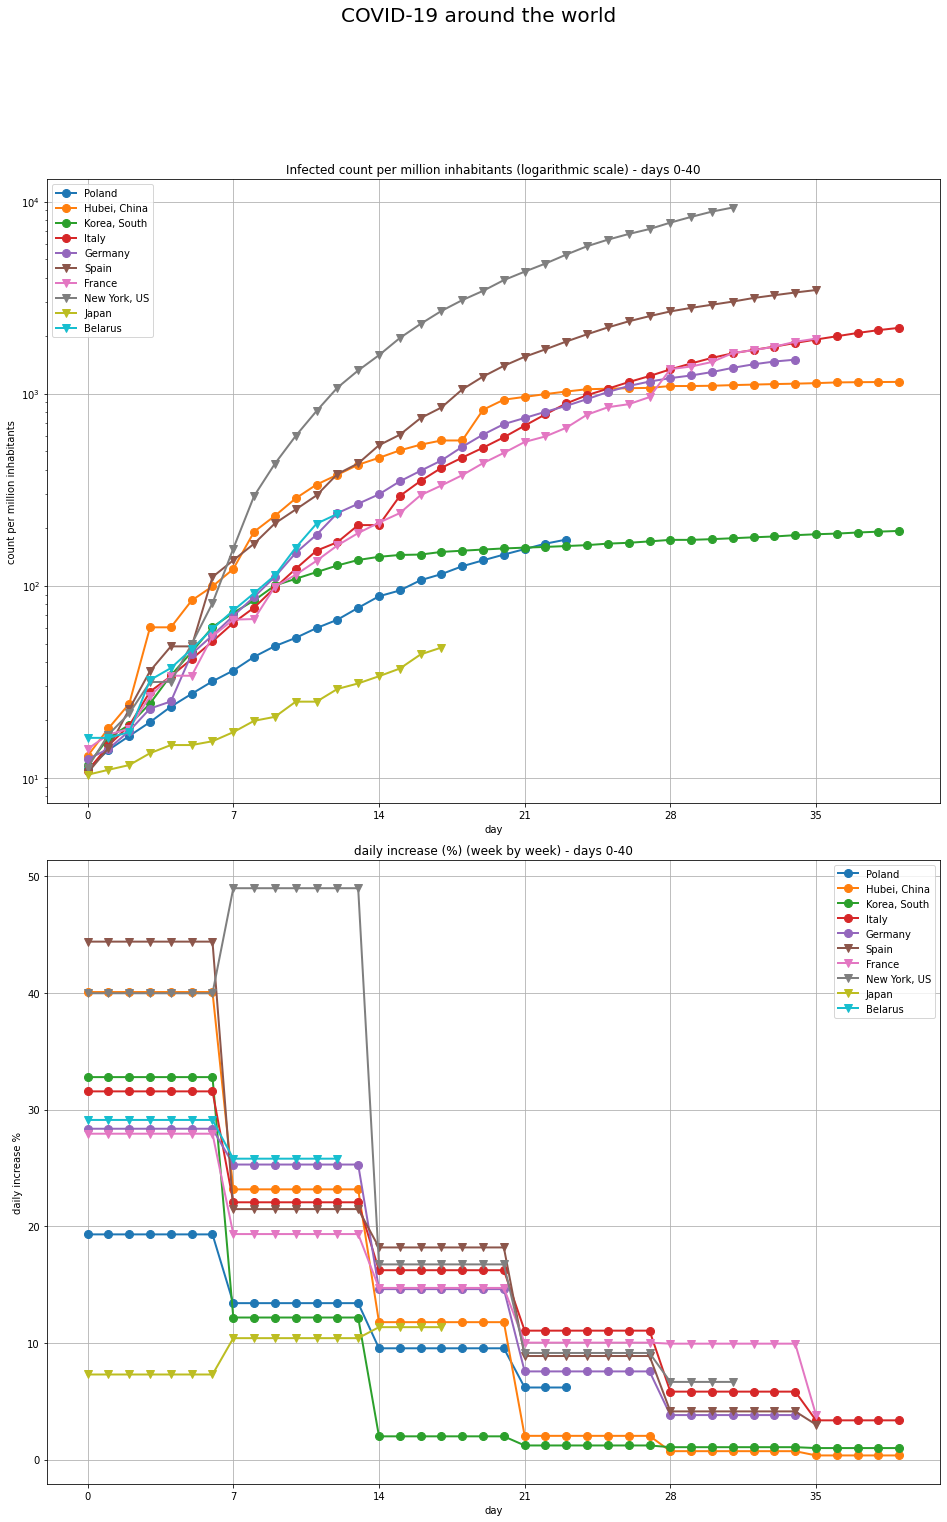

Saved analysis to: output/covid/reference_countries_comparison/covid_plot.jpeg


In [7]:
country_df = read_data_plot_countries(reference_countries, output_folder='reference_countries_comparison/',
                                      min_count_per_million=10,
                                      max_days=40)

# Correlations for all countries

100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


infected count  infected count per million current date  \
New York, US          181026                        9305   2020-04-11   
Spain                 163027                        3461   2020-04-11   
Switzerland            25107                        2929   2020-04-11   
Italy                 152271                        2527   2020-04-11   
Belgium                28018                        2433   2020-04-11   
...                      ...                         ...          ...   
Afghanistan              555                          17   2020-04-11   
Senegal                  278                          17   2020-04-11   
Taiwan                   385                          16   2020-04-11   
Indonesia               3842                          14   2020-04-11   
Ghana                    408                          13   2020-04-11   

              daily increase % (smoothened over last 7 days)  \
New York, US                                           0.076   
Spain                                                  0.041   
Switzerland                                            0.033   
Italy                                                  0.030   
Belgium                                                0.069   
...                                                      ...   
Afghanistan                                            0.092   
Senegal                                                0.036   
Taiwan                                                 0.013   
Indonesia                                              0.085   
Ghana                                                  0.091   

              doubles every ... days  \
New York, US                    9.42   
Spain                          17.11   
Switzerland                    21.57   
Italy                          23.29   
Belgium                        10.46   
...                              ...   
Afghanistan                     7.86   
Senegal                        19.64   
Taiwan                         52.05   
Indonesia                       8.51   
Ghana                           7.93   

              days since at least 1 per million infected  \
New York, US                                          31   
Spain                                                 35   
Switzerland                                           38   
Italy                                                 44   
Belgium                                               35   
...                                                  ...   
Afghanistan                                            6   
Senegal                                               11   
Taiwan                                                16   
Indonesia                                              4   
Ghana                                                  3   

              days between 1st case and at least 10 per million infected  \
New York, US                                                  9            
Spain                                                        35            
Switzerland                                                   8            
Italy                                                        27            
Belgium                                                      32            
...                                                         ...            
Afghanistan                                                  41            
Senegal                                                      29            
Taiwan                                                       64            
Indonesia                                                    36            
Ghana                                                        25            

              population (million)  density (people per km2)  \
New York, US                  19.5                     159.0   
Spain                         47.1                      93.0   
Switzerland                    8.6                     208.0 

Saved analysis to: output/covid/all_countries_correlations/all_countries_comparison.xlsx


infected count per million week_2  \
infected count per million week_2                                            1.000000   
daily increase % week_2                                                      0.487169   
daily increase % week_1                                                      0.792659   
daily increase % week_0                                                      0.326631   
days between 1st case and at least 10 per milli...                          -0.053943   
population (million)                                                         0.175494   
density (people per km2)                                                    -0.099790   
GDP per capita ($) (PPP)                                                     0.299169   
GDP per capita ($) (nominal)                                                 0.500762   
average yearly temperature (degree Celsius)                                 -0.260344   

                                                    daily increase % week_2  
infected count per million week_2                                  0.487169  
daily increase % week_2                                            1.000000  
daily increase % week_1                                            0.647446  
daily increase % week_0                                            0.092749  
days between 1st case and at least 10 per milli...                 0.154603  
population (million)                                               0.247721  
density (people per km2)                                          -0.196001  
GDP per capita ($) (PPP)                                           0.118346  
GDP per capita ($) (nominal)                                       0.271667  
average yearly temperature (degree Celsius)                       -0.251037

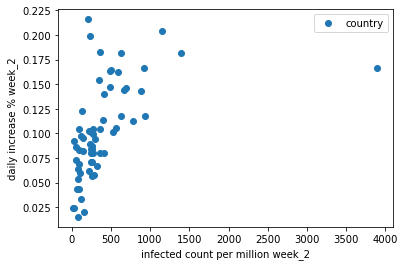

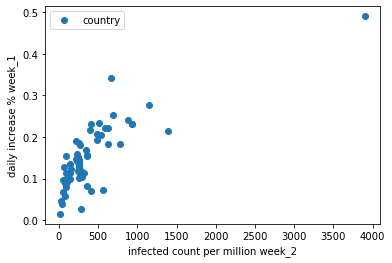

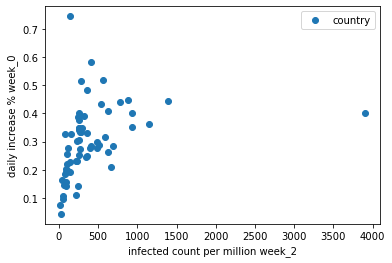

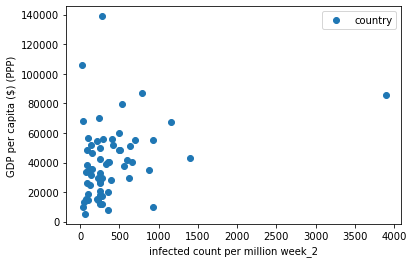

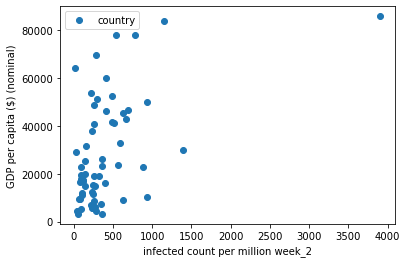

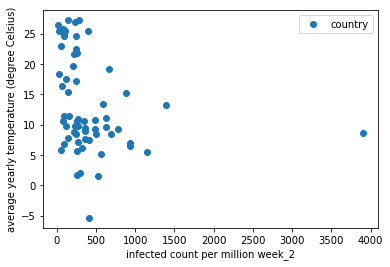

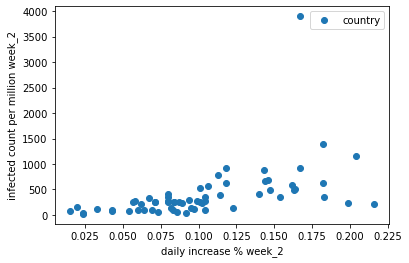

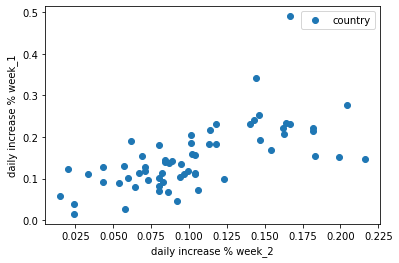

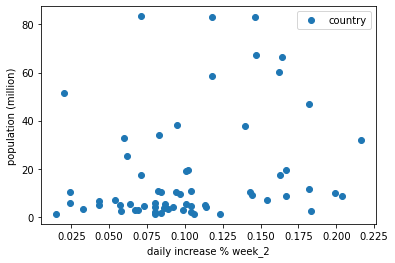

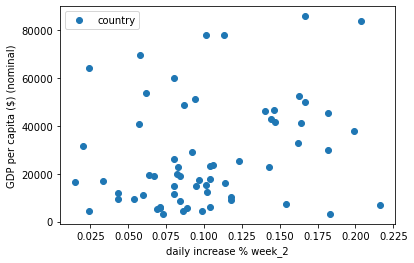

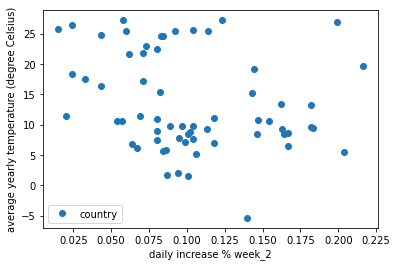

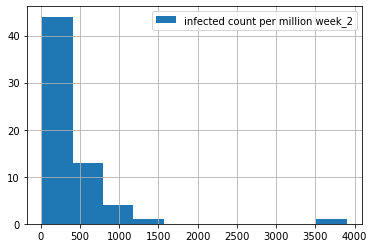

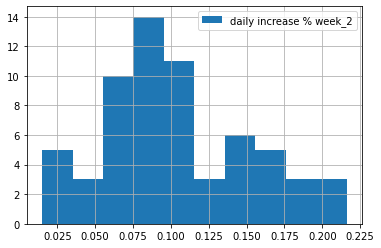

In [8]:
reference_provinces = {
    c['country'] : c['province'] for c in reference_countries if c['province'] is not None
}
all_countries = [{'country' : c, 'province' : reference_provinces[c] if c in reference_provinces else None} for c in get_all_countries()]
country_df = read_data_correlate_countries(all_countries,
                                           min_count_per_million=10,
                                           output_folder='all_countries_correlations/')

# Plots for all Polish provinces

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]


infected count  infected count per million  \
mazowieckie, Poland                    1664                         309   
dolnoslaskie, Poland                    697                         240   
lodzkie, Poland                         529                         213   
podlaskie, Poland                       222                         187   
slaskie, Poland                         846                         185   
kujawsko-pomorskie, Poland              336                         161   
wielkopolskie, Poland                   564                         161   
malopolskie, Poland                     504                         148   
zachodniopomorskie, Poland              193                         113   
swietokrzyskie, Poland                  141                         112   
lubelskie, Poland                       233                         109   
podkarpackie, Poland                    223                         104   
warminsko-mazurskie, Poland             122                          85   
lubuskie, Poland                         78                          76   
pomorskie, Poland                       171                          73   

                            current date  \
mazowieckie, Poland           2020-04-12   
dolnoslaskie, Poland          2020-04-12   
lodzkie, Poland               2020-04-12   
podlaskie, Poland             2020-04-12   
slaskie, Poland               2020-04-12   
kujawsko-pomorskie, Poland    2020-04-12   
wielkopolskie, Poland         2020-04-12   
malopolskie, Poland           2020-04-12   
zachodniopomorskie, Poland    2020-04-12   
swietokrzyskie, Poland        2020-04-12   
lubelskie, Poland             2020-04-12   
podkarpackie, Poland          2020-04-12   
warminsko-mazurskie, Poland   2020-04-12   
lubuskie, Poland              2020-04-12   
pomorskie, Poland             2020-04-12   

                             daily increase % (smoothened over last 7 days)  \
mazowieckie, Poland                                                   0.105   
dolnoslaskie, Poland                                                  0.072   
lodzkie, Poland                                                       0.096   
podlaskie, Poland                                                     0.132   
slaskie, Poland                                                       0.067   
kujawsko-pomorskie, Poland                                            0.049   
wielkopolskie, Poland                                                 0.126   
malopolskie, Poland                                                   0.067   
zachodniopomorskie, Poland                                            0.097   
swietokrzyskie, Poland                                                0.077   
lubelskie, Poland                                                     0.045   
podkarpackie, Poland                                                  0.073   
warminsko-mazurskie, Poland                                           0.052   
lubuskie, Poland                                                      0.045   
pomorskie, Poland                                                     0.066   

                             doubles every ... days  \
mazowieckie, Poland                            6.92   
dolnoslaskie, Poland                          10.04   
lodzkie, Poland                                7.56   
podlaskie, Poland                              5.60   
slaskie, Poland                               10.69   
kujawsko-pomorskie, Poland                    14.50   
wielkopolskie, Poland                          5.84   
malopolskie, Poland                           10.69   
zachodniopomorskie, Poland                     7.50   
swietokrzyskie, Poland                         9.36   
lubelskie, Poland                             15.87   
podkarpackie, Poland                           9.90   
warminsko-mazurskie, Poland                   13.75   
lubuskie, Poland                              15.89   
pomorskie, Poland                

Saved analysis to: output/covid/polish_provinces_comparison/countries_comparison.xlsx


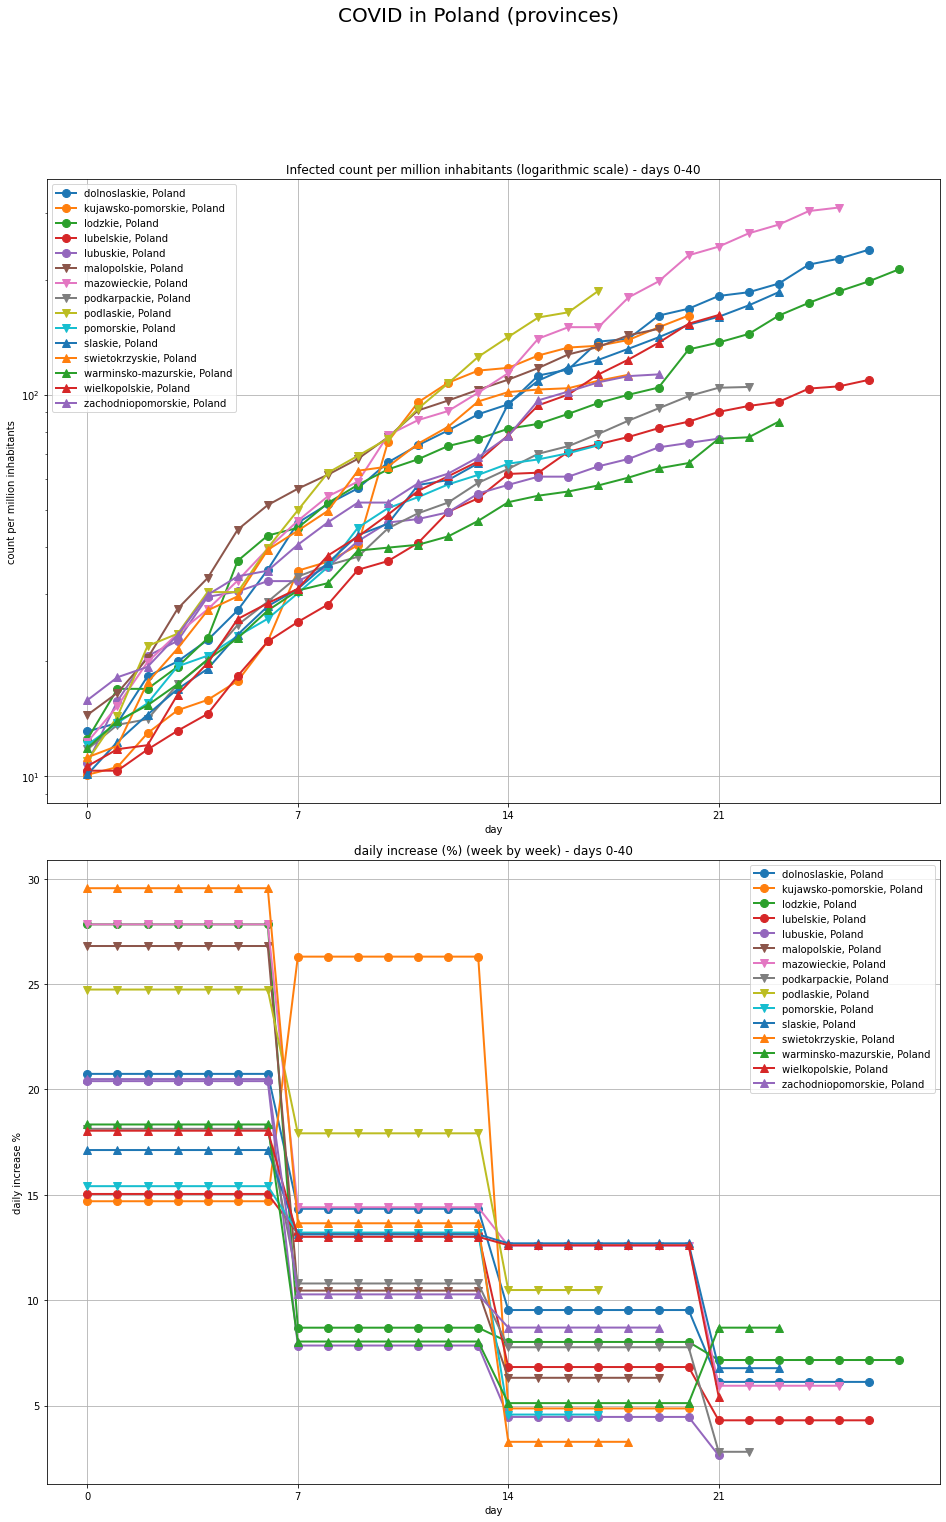

Saved analysis to: output/covid/polish_provinces_comparison/covid_plot.jpeg


In [9]:
polish_provinces = [
    {
        'country': 'Poland',
        'province': p 
    }
    for p in get_all_country_provinces('Poland')]
country_df = read_data_plot_countries(polish_provinces, 
                                      min_count=10, 
                                      title='COVID in Poland (provinces)',
                                      output_folder='polish_provinces_comparison/')

# Plots for all US states

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:22<00:00,  2.61it/s]


infected count  infected count per million current date  \
New York, US               181026                        9305   2020-04-11   
New Jersey, US              58151                        6546   2020-04-11   
Louisiana, US               20014                        4305   2020-04-11   
Massachusetts, US           22860                        3289   2020-04-11   
Connecticut, US             11510                        3228   2020-04-11   
Michigan, US                23605                        2363   2020-04-11   
Pennsylvania, US            21719                        1696   2020-04-11   
Illinois, US                19180                        1513   2020-04-11   
Washington, US              10434                        1370   2020-04-11   
Maryland, US                 7694                        1272   2020-04-11   
Georgia, US                 12159                        1145   2020-04-11   
Colorado, US                 6513                        1130   2020-04-11   
Indiana, US                  7435                        1104   2020-04-11   
Florida, US                 18494                         861   2020-04-11   
Tennessee, US                5132                         751   2020-04-11   
Virginia, US                 5077                         594   2020-04-11   
California, US              21706                         549   2020-04-11   
Ohio, US                     6250                         534   2020-04-11   
Texas, US                   13023                         449   2020-04-11   

                   daily increase % (smoothened over last 7 days)  \
New York, US                                                0.076   
New Jersey, US                                              0.090   
Louisiana, US                                               0.094   
Massachusetts, US                                           0.105   
Connecticut, US                                             0.115   
Michigan, US                                                0.084   
Pennsylvania, US                                            0.129   
Illinois, US                                                0.105   
Washington, US                                              0.057   
Maryland, US                                                0.142   
Georgia, US                                                 0.102   
Colorado, US                                                0.075   
Indiana, US                                                 0.105   
Florida, US                                                 0.079   
Tennessee, US                                               0.069   
Virginia, US                                                0.122   
California, US                                              0.084   
Ohio, US                                                    0.085   
Texas, US                                                   0.113   

                   doubles every ... days  \
New York, US                         9.42   
New Jersey, US                       8.06   
Louisiana, US                        7.75   
Massachusetts, US                    6.92   
Connecticut, US                      6.36   
Michigan, US                         8.58   
Pennsylvania, US                     5.71   
Illinois, US                         6.96   
Washington, US                      12.42   
Maryland, US                         5.24   
Georgia, US                          7.16   
Colorado, US                         9.60   
Indiana, US                          6.95   
Florida, US                          9.07   
Tennessee, US                       10.40   
Virginia, US                         6.01   
California, US                       8.62   
Ohio, US                             8.46   
Texas, US                            6.49   

                   days since at least 1 per million infected  \
New York, US                                               31   
New Jersey, US                                

Saved analysis to: output/covid/us_provinces_comparison/countries_comparison.xlsx


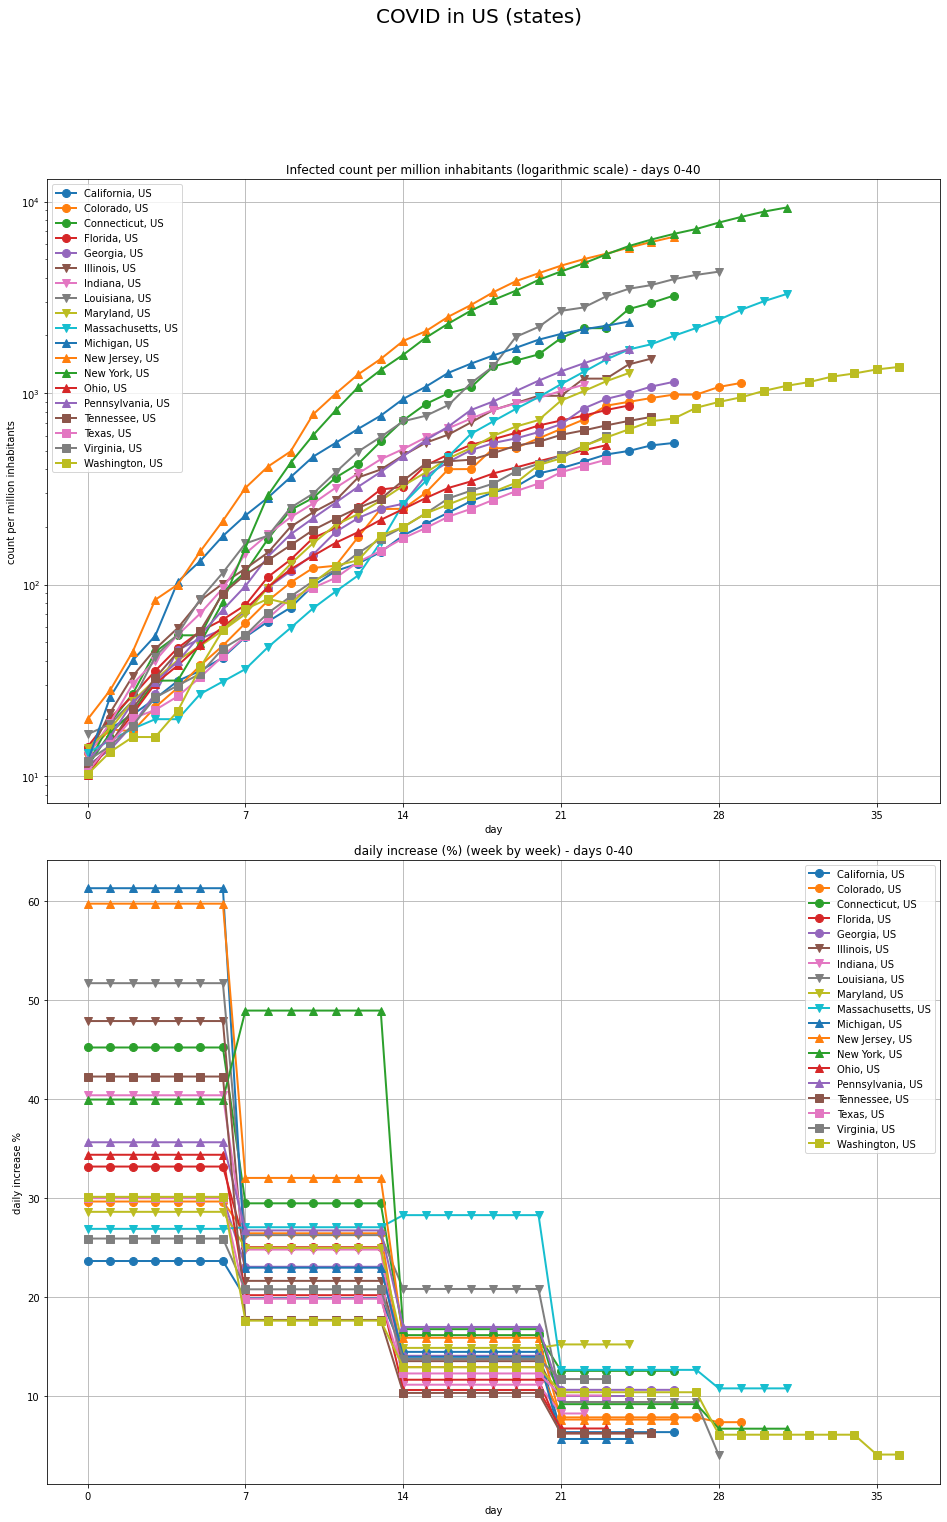

Saved analysis to: output/covid/us_provinces_comparison/covid_plot.jpeg


In [10]:
polish_provinces = [
    {
        'country': 'US',
        'province': p 
    }
    for p in get_all_country_provinces('US', folder='kaggle', file='time_series_covid_19_confirmed_US')]
country_df = read_data_plot_countries(
    polish_provinces, 
    min_count=5000,  
    output_folder='us_provinces_comparison/',
    title='COVID in US (states)'
)

# Countries clustering

In [11]:
from sklearn.cluster import DBSCAN

In [12]:
def get_dist(a, b, log=True, offset=0.01, power=2, index_weights=True):
    mask = a.notnull() & b.notnull()
    a = a[mask].astype('float') + offset
    b = b[mask].astype('float') + offset
    if log:
        a = np.log(a)
        b = np.log(b)
    if index_weights:
        weights = np.array(a.index)
    else:
        weights = np.ones(a.index.shape[0])
    return (weights * np.abs(np.power((a-b)/np.maximum(a, b), power))).sum()/ weights.sum()

def country_filtering_condition(country, min_population = 10**6, min_count = 100, min_count_per_million=10, min_days = 14):
    if 'df' not in country:
        return False
    df = country['df']
    population = get_population(country['country'], country['province'])
    if population < min_population:
        return False
    if df['count'].max() < min_count:
        return False
    if df['count_per_million'].max() < min_count_per_million:
        return False
    if df.loc[0:]['count'].notnull().sum() < min_days:
        return False
    return True

def get_dist_df(countries, col='count_per_million', index_weights=True, log=True):
    count_per_million_df = pd.DataFrame({
    c['country'] :  c['df'][col].loc[0:]
        for c in tqdm(countries)})

    dist_df = pd.DataFrame()
    for country_a in tqdm(count_per_million_df.columns):
        for country_b in count_per_million_df.columns:
            d = get_dist(count_per_million_df[country_a], count_per_million_df[country_b], 
                         log=log, power=2, index_weights=index_weights)
            dist_df.loc[country_a, country_b] = d
            dist_df.loc[country_b, country_a] = d
            if country_a == country_b:
                break
    return dist_df

colors = ['orange', 'purple', 'green', 'red', 
          'cyan', 'magenta', 'blue', 'yellow', 'brown', 'lightgreen']
markers = ['o', 'v', '^', 's', '*', 'H', 'D']

def plot_log_count_clustering(countries, ax, max_days=None):
    plotted_clusters = set()
    unique_clusters = sorted(list(set([c['cluster'] for c in countries])))
    for c in unique_clusters:
        for i, country in enumerate(countries):
            cluster = country['cluster']
            if cluster != c:
                continue
            label = f'cluster {cluster}' if cluster != -1 else 'outside cluster'
            label = '_nolegend_' if cluster in plotted_clusters else label
            plotted_clusters.add(cluster)
            color = colors[cluster % len(colors)] if cluster != -1 else 'grey'
            marker = markers[cluster % len(markers)] if cluster != -1 else None
            df = country['df']
            day_offset=df.index.get_loc(0)
            df = df[day_offset:]
            if max_days is not None:
                df = df[:max_days]
            df['count_per_million'].plot(
                ax=ax, 
                logy=True, 
                lw=2 if cluster != -1 else 1,
                markersize=8, 
                grid=True,
                label=label,
                marker=None,
                color=color
            )
    
    max_day = int(ax.get_xlim()[1])
    ticks =[t for t in range(max_day) if t % 7 == 0]
    ax.set_xticks(ticks)
    ax.set_ylabel('count per million inhabitants')
    title = 'Infected count per million inhabitants (logarithmic scale)'
    if max_days is not None:
        title = f'{title} - days 0-{max_days}'
    ax.set_title(title)
    ax.legend()
    
def plot_grow_rate_clustering(countries, ax, max_days=None):
    plotted_clusters = set()
    unique_clusters = sorted(list(set([c['cluster'] for c in countries])))
    for c in unique_clusters:
        for i, country in enumerate(countries):
            cluster = country['cluster']
            if cluster != c:
                continue
            label = f'cluster {cluster}' if cluster != -1 else 'outside cluster'
            label = '_nolegend_' if cluster in plotted_clusters else label
            plotted_clusters.add(cluster)
            color = colors[cluster % len(colors)] if cluster != -1 else 'grey'
            marker = markers[cluster % len(markers)] if cluster != -1 else None
            df = country['df']
            day_offset=df.index.get_loc(0)
            df = df[day_offset:]
            if max_days is not None:
                df = df[:max_days]
            (df['grow_rate_by_week'] * 100).plot(
                ax=ax, 
                label=label,
                grid=True,
                lw=2 if cluster != -1 else 1,
                markersize=8, 
                marker=None,
                color=color,)
    ax.set_ylabel('daily increase %')
    max_day = int(ax.get_xlim()[1])
    ticks =[t for t in range(max_day) if t % 7 == 0]
    ax.set_xticks(ticks)
    
    ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], min(ylim[1], 100))
    title = f'daily increase (%) (week by week)'
    if max_days is not None:
        title = f'{title} - days 0-{max_days}'
    ax.set_title(title)
    
def get_cluster_mean(countries, cluster):
    mean = pd.DataFrame({country['country'] : get_country_info(country['df'], 
                      country['country'], 
                      country['province'], 
                      smooth_period=7,
                      min_count_per_million=10) for country in countries 
                         if country['cluster'] == cluster or cluster == 'all countries'}).transpose().mean()
    for i in mean.index:
        mean.loc[i] = round(mean.loc[i], 2 if '%' in i else 0)
    
    selected_cols = [
        'GDP per capita ($) (PPP)',
        'GDP per capita ($) (nominal)',
        'average yearly temperature (degree Celsius)',
        'population (million)',
        'density (people per km2)',
        'daily increase % week_0', 
        'daily increase % week_1', 
        'daily increase % week_2', 
        'infected count per million week_0',
        'infected count per million week_1',
        'infected count per million week_2',
        
    ]
    return pd.Series([mean.loc[c] if c in mean.index else np.nan for c in selected_cols], index=selected_cols)

def get_cluster_info(clustering, countries):
    cluster_info= pd.DataFrame([
    {
        'cluster' : f'cluster {c}' if c != -1 else 'outside cluster',
        'countries': ', '.join(clustering[clustering == c].index) if c != 'all countries' else c,
        'number of countries': (clustering == c).sum() if c != 'all countries' else clustering.shape[0],
        **get_cluster_mean(countries, c).to_dict()
    }
    for c in ['all countries'] + sorted(clustering.unique())])
    return cluster_info
    
    
def plot_clustering_report(clustering, countries, max_days=None):
    for c in countries:
        c['cluster'] = clustering.loc[c['country']]
    cluster_info = get_cluster_info(clustering, countries)
    with pd.option_context('max_colwidth', -1):
        display(cluster_info)
    fig = plt.figure(figsize=(16,24))
    title = 'COVID-19 around the world - clustering country pandemic behaviour'
    fig.suptitle(title, fontsize=20)
    gs = fig.add_gridspec(4,2)
    ax = fig.add_subplot(gs[0:2, :])
    plot_log_count_clustering(countries, ax,  max_days=max_days)
    ax = fig.add_subplot(gs[2:4,:])
    plot_grow_rate_clustering(countries, ax,  max_days=max_days)
    return fig

def reorder_clusters(clustering, countries_for_clustering):
    clustering.index.name = 'country'
    clustering.name = 'cluster'
    clustering_df = clustering.to_frame()
    clustering_df['count_per_million_day_13'] = clustering_df.index.map(
        lambda x: [c for c in countries_for_clustering if c['country'] == x][0]['df'].loc[13, 'count_per_million']
    )
    mean_by_cluster = clustering_df.groupby('cluster')['count_per_million_day_13'].mean()
    mean_by_cluster = mean_by_cluster[mean_by_cluster.index != -1]
    mean_by_cluster.sort_values(ascending=False, inplace=True)
    mean_by_cluster = mean_by_cluster.to_frame().reset_index()
    mean_by_cluster.index.name = 'ordering'
    mean_by_cluster['ordering'] = mean_by_cluster.index
    mean_by_cluster.set_index('cluster', inplace=True, drop=False)
    clustering = clustering.map(lambda x: mean_by_cluster.loc[x, 'ordering'] if x != -1 else x)
    return clustering

In [13]:
countries_for_clustering = [c for c in tqdm(all_countries) 
                            if country_filtering_condition(c, 
                                                           min_days=14, 
                                                           min_count_per_million=10)]
    
count_dist_df = get_dist_df(countries_for_clustering, col='count_per_million', index_weights=False, log=True)
grow_dist_df = get_dist_df(countries_for_clustering, col='grow_rate_by_week', index_weights=False, log=True)
dist_df = count_dist_df + grow_dist_df * 0.1

100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [00:25<00:00,  3.38it/s]


big cluster countries
Index(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Azerbaijan', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria',
       'Canada', 'Chile', 'Colombia', 'Congo (Kinshasa)', 'Costa Rica',
       'Croatia', 'Cuba', 'Czechia', 'Dominican Republic', 'Ecuador',
       'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Honduras',
       'Hungary', 'Iran', 'Iraq', 'Italy', 'Japan', 'Jordan', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lebanon', 'Lithuania', 'Malaysia', 'Mauritius',
       'Moldova', 'Morocco', 'Netherlands', 'New Zealand', 'North Macedonia',
       'Oman', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Slovakia',
       'South Africa', 'Sweden', 'Switzerland', 'Thailand', 'Tunisia',
       'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uruguay',
       'West Bank and Gaza'],
      dtype='object')
outside cluster countries
Index(['Bahrain',

cluster  \
0  cluster all countries   
1  outside cluster         
2  cluster 0               
3  cluster 1               
4  cluster 2               
5  cluster 3               
6  cluster 4               
7  cluster 5               
8  cluster 6               

                                                                                                                                                                                                                                                                                                                                                                           countries  \
0  all countries                                                                                                                                                                                                                                                                                                                                                                       
1  Bahrain, Burkina Faso, China, Denmark, Djibouti, Estonia, Israel, Korea, South, Kuwait, Qatar, Singapore, Slovenia, Spain, Taiwan*, Trinidad and Tobago, US, Kosovo                                                                                                                                                                                                                 
2  Ireland, Norway, Turkey                                                                                                                                                                                                                                                                                                                                                             
3  Canada, France, Italy, Netherlands, Panama, United Kingdom                                                                                                                                                                                                                                                                                                                          
4  Bosnia and Herzegovina, Dominican Republic, Iran, Latvia, North Macedonia                                                                                                                                                                                                                                                                                                           
5  Armenia, Australia, Austria, Belgium, Bulgaria, Chile, Costa Rica, Croatia, Czechia, Ecuador, Finland, Georgia, Germany, Greece, Iraq, Japan, Jordan, Lithuania, Malaysia, Mauritius, Moldova, New Zealand, Oman, Peru, Philippines, Portugal, Romania, Serbia, Slovakia, South Africa, Sweden, Switzerland, Thailand, Tunisia, United Arab Emirates, Uruguay, West Bank and Gaza   
6  Azerbaijan, Cuba, Hungary, Poland, Russia, Saudi Arabia, Ukraine                                                                                                                                                                                                                                                                                                                    
7  Albania, Brazil, Kyrgyzstan, Lebanon                                                                                                                                                                                                                                                                                                                                                
8  Algeria, Argentina, Colombia, Congo (Kinshasa), Honduras, Kazakhstan, Morocco                                                                                                                                                                                                                                                                                

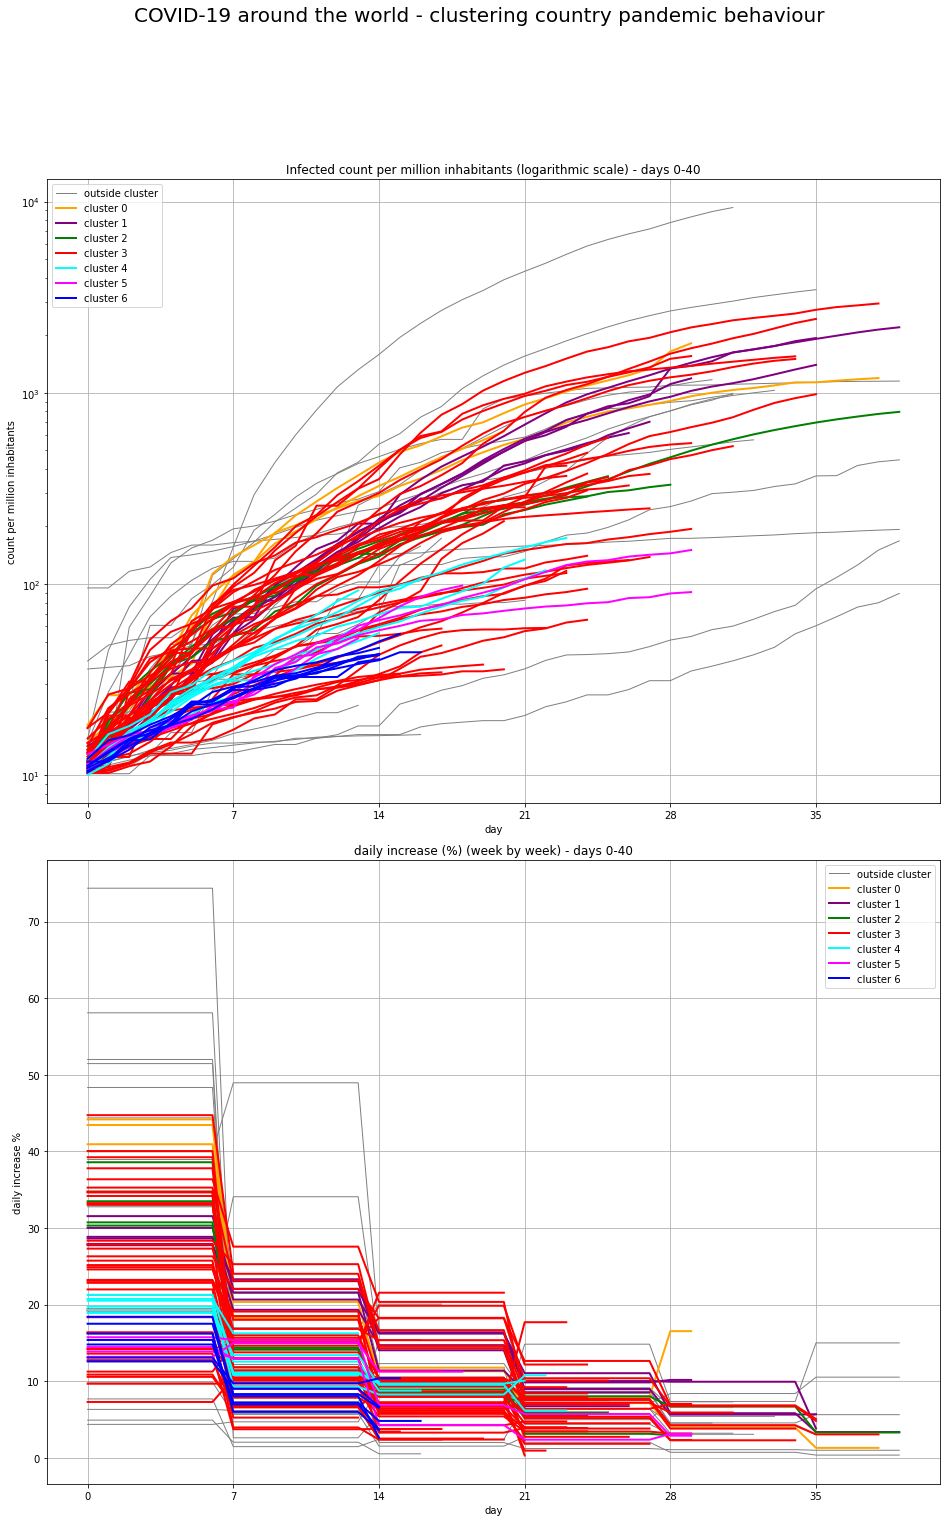

In [14]:
eps = 0.004
min_samples = 3
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
labels = dbscan.fit_predict(dist_df)
clustering = pd.Series(data=labels, index=dist_df.index)
clustering_vc = clustering.value_counts()
big_clusters = clustering_vc[(clustering_vc > 20) & (clustering_vc.index != -1)]
if big_clusters.shape[0] > 0:
    big_cluster_countries = clustering[clustering.isin(big_clusters.index)].index
    print('big cluster countries')
    print(big_cluster_countries)
    big_cluster_dist_df = dist_df.loc[big_cluster_countries, big_cluster_countries]
    smaller_dbscan = DBSCAN(eps=eps/2, min_samples=min_samples, metric='precomputed')
    smaller_labels = smaller_dbscan.fit_predict(big_cluster_dist_df)
    smaller_clustering = pd.Series(data=smaller_labels, index=big_cluster_dist_df.index)
    smaller_clustering = smaller_clustering.apply(lambda x: np.nan if x == -1 else x + clustering.max() + 1)
    previous_clustering = pd.Series(smaller_clustering.index.map(lambda x: clustering.loc[x]), smaller_clustering.index)
    smaller_clustering = smaller_clustering.fillna(previous_clustering).astype(int)
    clustering = clustering[clustering.index.map(lambda x: x not in big_cluster_countries)]
    clustering = pd.concat([smaller_clustering, clustering])
    big_clusters = clustering_vc[(clustering_vc > 20) & (clustering_vc.index != -1)]
    
    
outside_cluster_countries = clustering[clustering == -1].index
if outside_cluster_countries.shape[0] > 10:
    print('outside cluster countries')
    print(outside_cluster_countries)
    outside_cluster_dist_df = dist_df.loc[outside_cluster_countries, outside_cluster_countries]
    smaller_dbscan = DBSCAN(eps=eps * 2, min_samples=min_samples, metric='precomputed')
    smaller_labels = smaller_dbscan.fit_predict(outside_cluster_dist_df)
    smaller_clustering = pd.Series(data=smaller_labels, index=outside_cluster_dist_df.index)
    smaller_clustering = smaller_clustering.apply(lambda x: -1 if x == -1 else x + clustering.max() + 1)
    clustering = clustering[clustering.index.map(lambda x: x not in outside_cluster_countries)]
    clustering = pd.concat([smaller_clustering, clustering])
clustering = reorder_clusters(clustering, countries_for_clustering)
fig = plot_clustering_report(clustering, countries_for_clustering, max_days=40)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


infected count  infected count per million current date  \
Ireland            8928                        1814   2020-04-11   
Norway             6409                        1194   2020-04-11   
Turkey            52167                         627   2020-04-11   

         daily increase % (smoothened over last 7 days)  \
Ireland                                           0.095   
Norway                                            0.023   
Turkey                                            0.123   

         doubles every ... days  days since at least 1 per million infected  \
Ireland                    7.60                                          29   
Norway                    29.96                                          38   
Turkey                     5.99                                          20   

         days between 1st case and at least 10 per million infected  \
Ireland                                                 13            
Norway                                                   7            
Turkey                                                  11            

         population (million)  density (people per km2)  \
Ireland                   4.9                      70.0   
Norway                    5.4                      17.0   
Turkey                   83.2                     106.0   

         GDP per capita ($) (PPP)  ...  daily increase % week_0  \
Ireland                   86988.0  ...                    0.442   
Norway                    79638.0  ...                    0.435   
Turkey                    29327.0  ...                    0.409   

         infected count per million week_0  daily increase % week_1  \
Ireland                                113                    0.184   
Norway                                  74                    0.204   
Turkey                                  89                    0.183   

         infected count per million week_1  daily increase % week_2  \
Ireland                                369                    0.113   
Norway                                 272                    0.101   
Turkey                                 287                    0.118   

         infected count per million week_2  daily increase % week_3  \
Ireland                                782                    0.079   
Norway                                 533                    0.071   
Turkey                                 627                      NaN   

         infected count per million week_3  daily increase % week_4  \
Ireland                             1335.0                      NaN   
Norway                               864.0                    0.039   
Turkey                                 NaN                      NaN   

         infected count per million week_4  
Ireland                                NaN  
Norway                              1133.0  
Turkey                                 NaN  

[3 rows x 22 columns]

Saved analysis to: output/covid/clustering/cluster_0/countries_comparison.xlsx


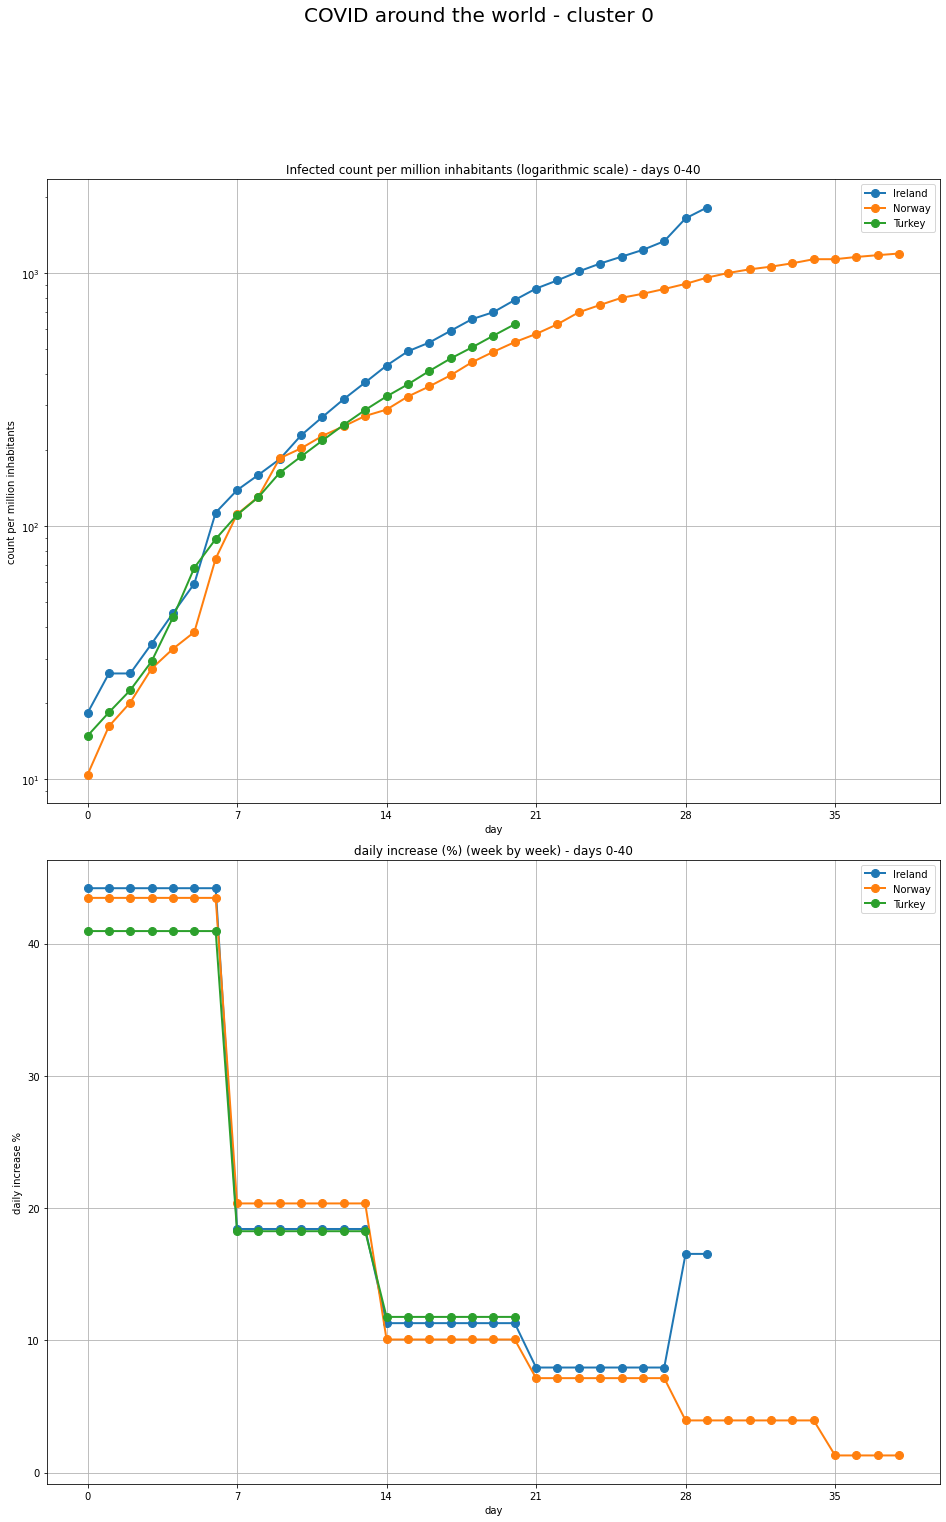

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_0/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.27it/s]


infected count  infected count per million current date  \
Italy                   152271                        2527   2020-04-11   
France                  129654                        1932   2020-04-11   
Netherlands              24413                        1398   2020-04-11   
United Kingdom           78991                        1188   2020-04-11   
Panama                    2974                         704   2020-04-11   
Canada                   23316                         615   2020-04-11   

                daily increase % (smoothened over last 7 days)  \
Italy                                                    0.030   
France                                                   0.099   
Netherlands                                              0.056   
United Kingdom                                           0.099   
Panama                                                   0.093   
Canada                                                   0.085   

                doubles every ... days  \
Italy                            23.29   
France                            7.32   
Netherlands                      12.62   
United Kingdom                    7.36   
Panama                            7.78   
Canada                            8.47   

                days since at least 1 per million infected  \
Italy                                                   44   
France                                                  35   
Netherlands                                             35   
United Kingdom                                          29   
Panama                                                  27   
Canada                                                  26   

                days between 1st case and at least 10 per million infected  \
Italy                                                          27            
France                                                         43            
Netherlands                                                     9            
United Kingdom                                                 42            
Panama                                                          5            
Canada                                                         50            

                population (million)  density (people per km2)  \
Italy                           60.2                     200.0   
France                          67.1                     123.0   
Netherlands                     17.5                     420.0   
United Kingdom                  66.4                     274.0   
Panama                           4.2                      56.0   
Canada                          37.9                       5.4   

                GDP per capita ($) (PPP)  ...  daily increase % week_1  \
Italy                            41582.0  ...                    0.221   
France                           48640.0  ...                    0.193   
Netherlands                      60299.0  ...                    0.207   
United Kingdom                   48169.0  ...                    0.233   
Panama                           28456.0  ...                    0.216   
Canada                           52139.0  ...                    0.231   

                infected count per million week_1  daily increase % week_2  \
Italy                                         206                    0.162   
France                                        188                    0.147   
Netherlands                                   171                    0.163   
United Kingdom                                175                    0.164   
Panama                                        186                    0.114   
Canada                                        165                    0.140   

                infected count per million week_2  daily increase % week_3  \
Italy                                         592                    0.111   
France                                        491                

Saved analysis to: output/covid/clustering/cluster_1/countries_comparison.xlsx


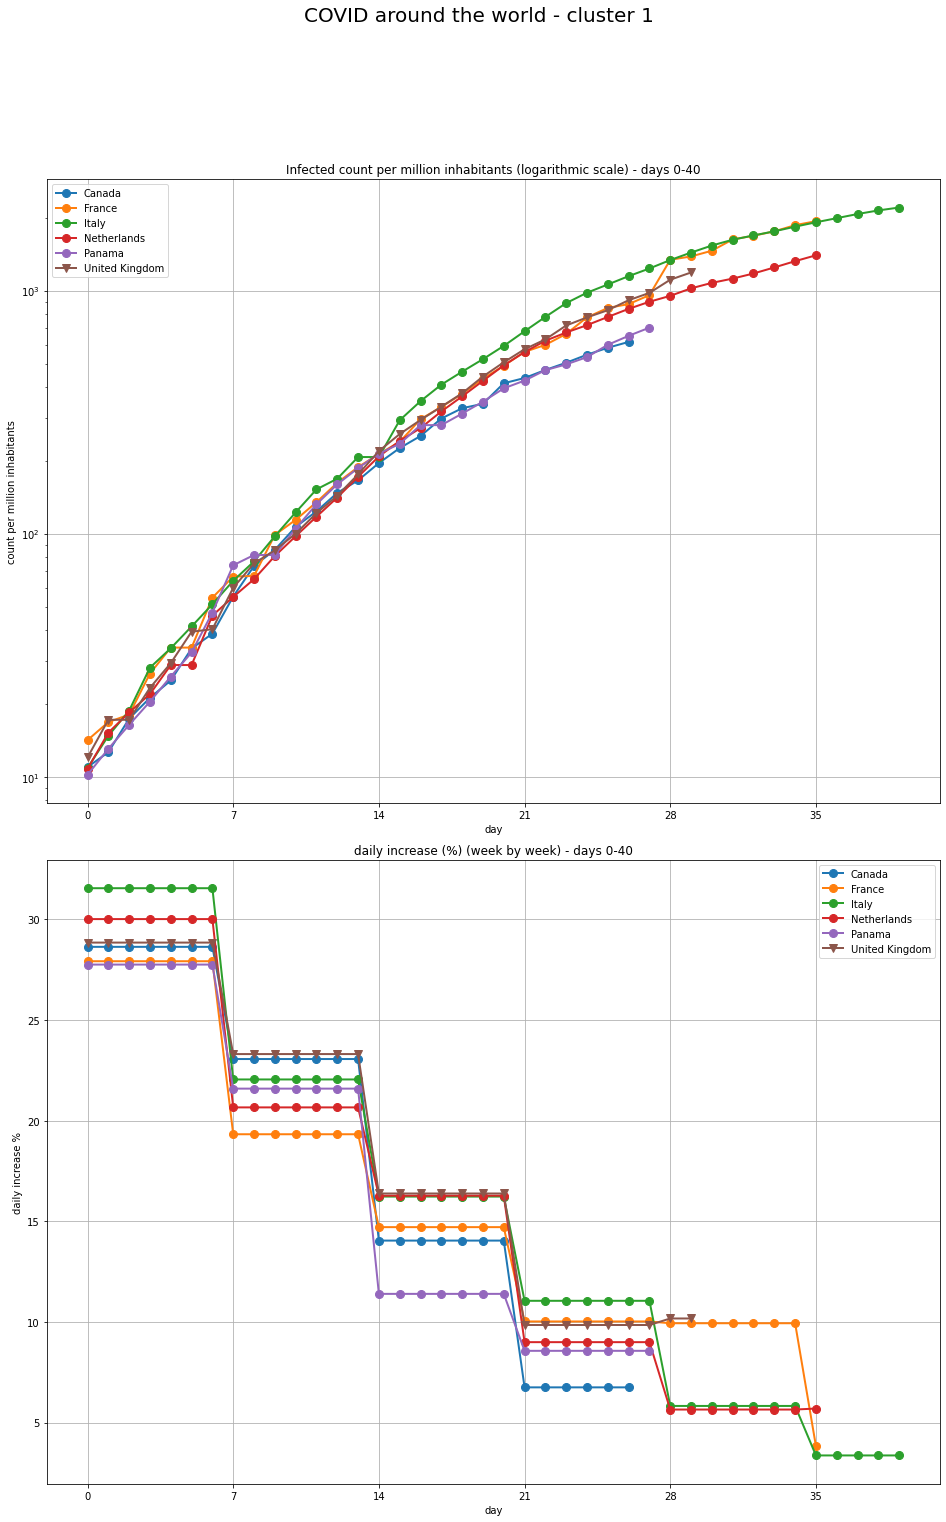

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_1/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


infected count  infected count per million  \
Iran                             70029                         840   
North Macedonia                    760                         365   
Latvia                             630                         330   
Bosnia and Herzegovina             946                         286   
Dominican Republic                2759                         266   

                       current date  \
Iran                     2020-04-11   
North Macedonia          2020-04-11   
Latvia                   2020-04-11   
Bosnia and Herzegovina   2020-04-11   
Dominican Republic       2020-04-11   

                        daily increase % (smoothened over last 7 days)  \
Iran                                                             0.036   
North Macedonia                                                  0.074   
Latvia                                                           0.031   
Bosnia and Herzegovina                                           0.065   
Dominican Republic                                               0.084   

                        doubles every ... days  \
Iran                                     19.52   
North Macedonia                           9.65   
Latvia                                   22.44   
Bosnia and Herzegovina                   10.97   
Dominican Republic                        8.58   

                        days since at least 1 per million infected  \
Iran                                                            41   
North Macedonia                                                 25   
Latvia                                                          28   
Bosnia and Herzegovina                                          24   
Dominican Republic                                              21   

                        days between 1st case and at least 10 per million infected  \
Iran                                                                   11            
North Macedonia                                                        20            
Latvia                                                                 12            
Bosnia and Herzegovina                                                 13            
Dominican Republic                                                     20            

                        population (million)  density (people per km2)  \
Iran                                    83.3                      51.0   
North Macedonia                          2.1                      81.0   
Latvia                                   1.9                      30.0   
Bosnia and Herzegovina                   3.3                      69.0   
Dominican Republic                      10.4                     216.0   

                        GDP per capita ($) (PPP)  ...  \
Iran                                     17832.0  ...   
North Macedonia                          17378.0  ...   
Latvia                                   32987.0  ...   
Bosnia and Herzegovina                   14894.0  ...   
Dominican Republic                       20625.0  ...   

                        daily increase % week_1  \
Iran                                      0.118   
North Macedonia                           0.111   
Latvia                                    0.141   
Bosnia and Herzegovina                    0.142   
Dominican Republic                        0.144   

                        infected count per million week_1  \
Iran                                                  152   
North Macedonia                                       137   
Latvia                                                146   
Bosnia and Herzegovina                                127   
Dominican Republic                                    143   

                        daily increase % week_2  \
Iran                                      0.071   
North Macedonia                           0.104   
Latvia                                    0.084   
Bosnia and Herzego

Saved analysis to: output/covid/clustering/cluster_2/countries_comparison.xlsx


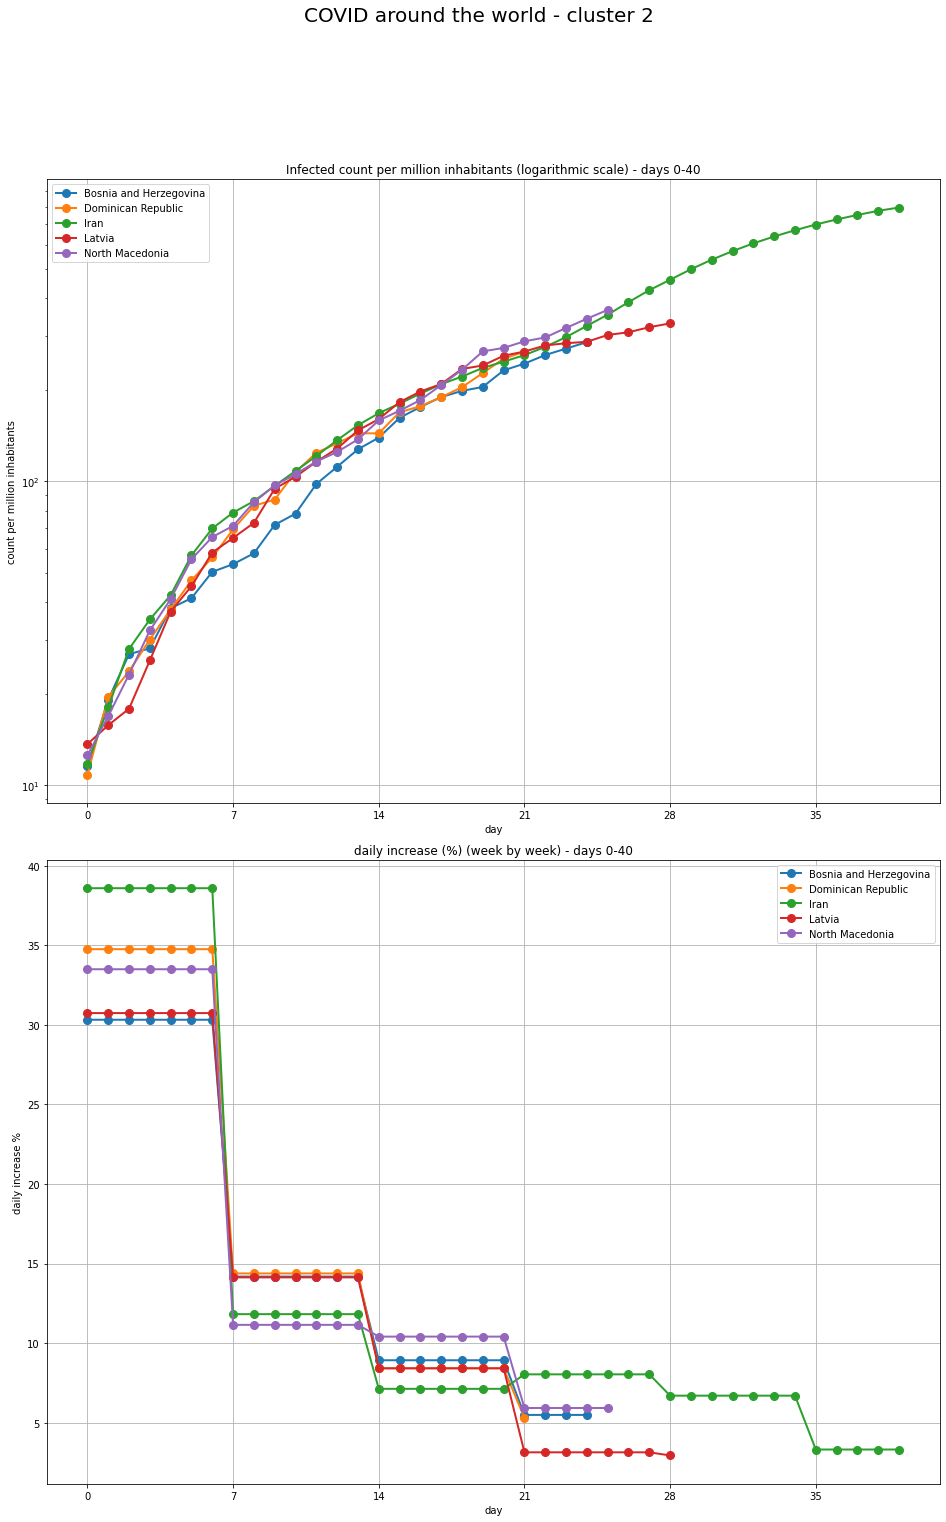

  0%|                                                                                           | 0/37 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_2/covid_plot.jpeg


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:28<00:00,  1.28it/s]


infected count  infected count per million current date  \
Switzerland                    25107                        2929   2020-04-11   
Belgium                        28018                        2433   2020-04-11   
Portugal                       15987                        1555   2020-04-11   
Austria                        13806                        1550   2020-04-11   
Germany                       124908                        1502   2020-04-11   
Sweden                         10151                         982   2020-04-11   
Moldova                         1560                         581   2020-04-11   
Czechia                         5831                         545   2020-04-11   
Finland                         2905                         525   2020-04-11   
Serbia                          3380                         485   2020-04-11   
Ecuador                         7257                         415   2020-04-11   
United Arab Emirates            3736                         377   2020-04-11   
Croatia                         1534                         376   2020-04-11   
Lithuania                       1026                         367   2020-04-11   
Chile                           6927                         362   2020-04-11   
Armenia                          967                         327   2020-04-11   
Romania                         5990                         308   2020-04-11   
New Zealand                     1312                         263   2020-04-11   
Mauritius                        319                         251   2020-04-11   
Australia                       6303                         248   2020-04-11   
Peru                            6848                         213   2020-04-11   
Greece                          2081                         194   2020-04-11   
Uruguay                          494                         140   2020-04-11   
Malaysia                        4530                         138   2020-04-11   
Slovakia                         728                         133   2020-04-11   
Oman                             546                         117   2020-04-11   
Costa Rica                       577                         114   2020-04-11   
Bulgaria                         661                          94   2020-04-11   
Georgia                          242                          64   2020-04-11   
Tunisia                          685                          58   2020-04-11   
West Bank and Gaza               268                          58   2020-04-11   
Japan                           6005                          47   2020-04-11   
Philippines                     4428                          40   2020-04-11   
Thailand                        2518                          37   2020-04-11   
Jordan                           381                          35   2020-04-11   
South Africa                    2028                          34   2020-04-11   
Iraq                            1318                          33   2020-04-11   

                      daily increase % (smoothened over last 7 days)  \
Switzerland                                                    0.033   
Belgium                                                        0.069   
Portugal                                                       0.066   
Austria                                                        0.023   
Germany                                                        0.043   
Sweden                                                         0.067   
Moldova                                                        0.135   
Czechia                                                        0.049   
Finland                                                        0.080   
Serbia                                                         0.112   
Ecuador                                                        0.114   
United Arab Emirates                                           0.150   
Croatia

Saved analysis to: output/covid/clustering/cluster_3/countries_comparison.xlsx


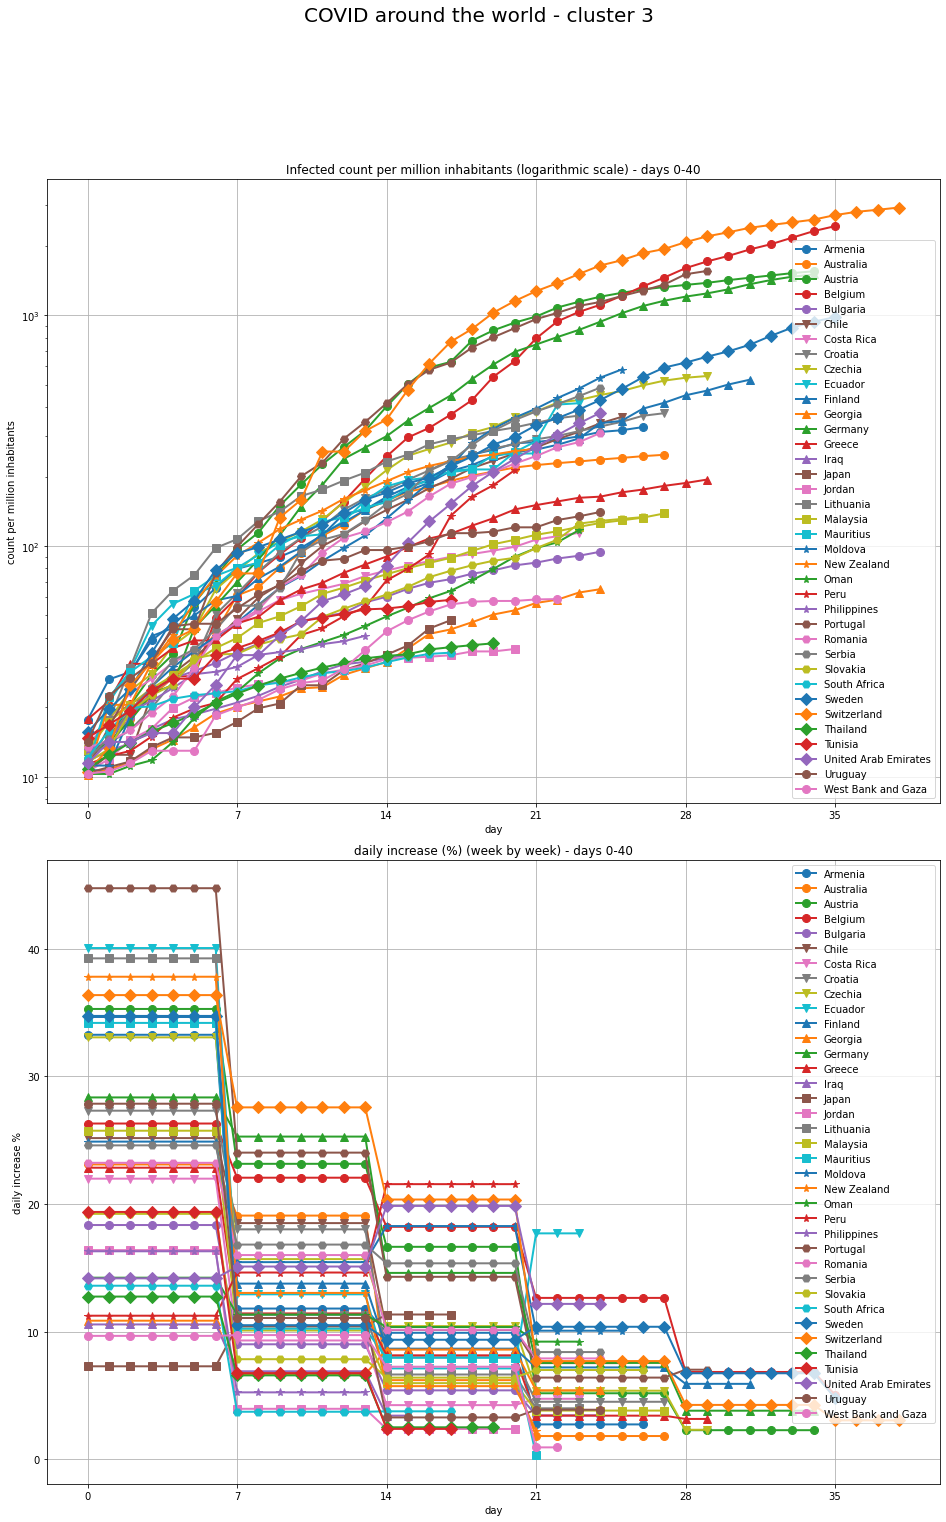

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_3/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.34it/s]


infected count  infected count per million current date  \
Poland                  6674                         173   2020-04-12   
Hungary                 1310                         134   2020-04-11   
Saudi Arabia            4033                         117   2020-04-11   
Azerbaijan              1058                         105   2020-04-11   
Russia                 13584                          92   2020-04-11   
Ukraine                 2511                          59   2020-04-11   
Cuba                     620                          55   2020-04-11   

              daily increase % (smoothened over last 7 days)  \
Poland                                                 0.083   
Hungary                                                0.097   
Saudi Arabia                                           0.087   
Azerbaijan                                             0.122   
Russia                                                 0.163   
Ukraine                                                0.108   
Cuba                                                   0.112   

              doubles every ... days  \
Poland                          8.65   
Hungary                         7.50   
Saudi Arabia                    8.33   
Azerbaijan                      6.03   
Russia                          4.60   
Ukraine                         6.74   
Cuba                            6.55   

              days since at least 1 per million infected  \
Poland                                                23   
Hungary                                               21   
Saudi Arabia                                          22   
Azerbaijan                                            16   
Russia                                                13   
Ukraine                                               13   
Cuba                                                  14   

              days between 1st case and at least 10 per million infected  \
Poland                                                       16            
Hungary                                                      17            
Saudi Arabia                                                 18            
Azerbaijan                                                   25            
Russia                                                       58            
Ukraine                                                      26            
Cuba                                                         16            

              population (million)  density (people per km2)  \
Poland                        38.4                     123.0   
Hungary                        9.8                     105.0   
Saudi Arabia                  34.2                      16.0   
Azerbaijan                    10.1                     116.0   
Russia                       146.7                       9.0   
Ukraine                       41.9                      69.0   
Cuba                          11.2                     102.0   

              GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Poland                         35651.0                       14901.0   
Hungary                        35941.0                       17463.0   
Saudi Arabia                   56912.0                       22865.0   
Azerbaijan                     19156.0                        4689.0   
Russia                         30820.0                       11162.0   
Ukraine                        10130.0                        3592.0   
Cuba                           22237.0                        8822.0   

              average yearly temperature (degree Celsius)  \
Poland                                                7.8   
Hungary                                               9.8   
Saudi Arabia                                         24.6   
Azerbaijan                                           12.0   
Russia                                               -5.1   
Ukraine                                          

Saved analysis to: output/covid/clustering/cluster_4/countries_comparison.xlsx


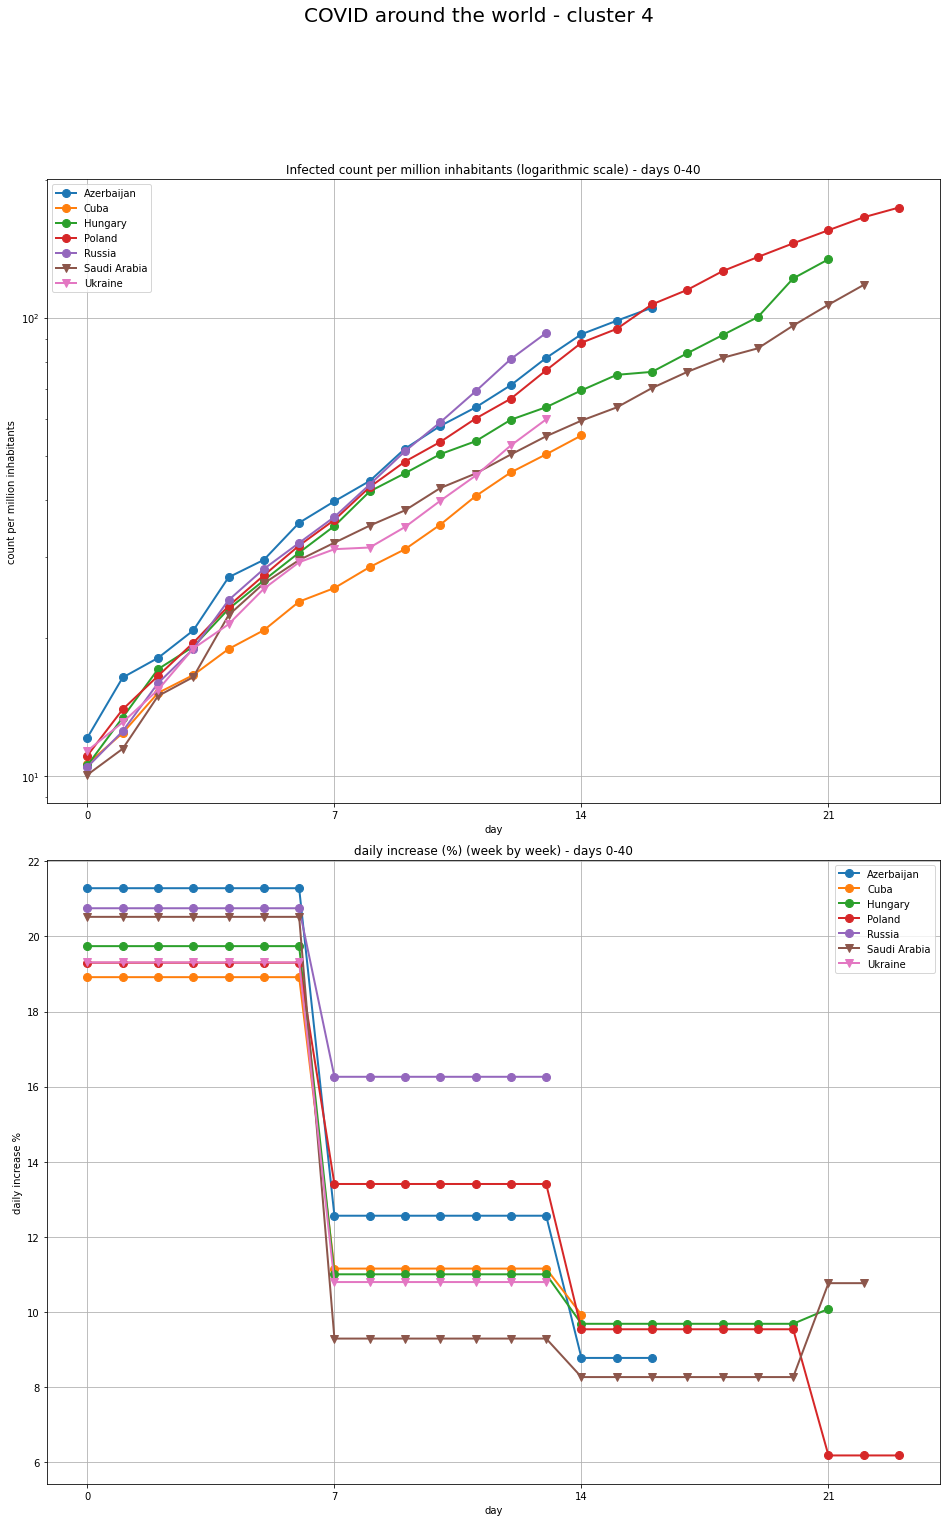

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_4/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


infected count  infected count per million current date  \
Albania                433                         150   2020-04-11   
Brazil               20727                          98   2020-04-11   
Lebanon                619                          90   2020-04-11   
Kyrgyzstan             339                          51   2020-04-11   

            daily increase % (smoothened over last 7 days)  \
Albania                                              0.046   
Brazil                                               0.117   
Lebanon                                              0.026   
Kyrgyzstan                                           0.126   

            doubles every ... days  \
Albania                      15.47   
Brazil                        6.27   
Lebanon                      26.76   
Kyrgyzstan                    5.85   

            days since at least 1 per million infected  \
Albania                                             29   
Brazil                                              18   
Lebanon                                             29   
Kyrgyzstan                                          13   

            days between 1st case and at least 10 per million infected  \
Albania                                                     4            
Brazil                                                     27            
Lebanon                                                    21            
Kyrgyzstan                                                 11            

            population (million)  density (people per km2)  \
Albania                      2.9                      98.0   
Brazil                     211.3                      25.0   
Lebanon                      6.8                     672.0   
Kyrgyzstan                   6.5                      32.0   

            GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Albania                      14866.0                        5372.0   
Brazil                       17106.0                        8796.0   
Lebanon                      15599.0                        9654.0   
Kyrgyzstan                    4193.0                        1292.0   

            average yearly temperature (degree Celsius)  \
Albania                                            11.4   
Brazil                                             25.0   
Lebanon                                            16.4   
Kyrgyzstan                                          1.6   

            daily increase % week_0  infected count per million week_0  \
Albania                       0.157                                 22   
Brazil                        0.132                                 21   
Lebanon                       0.145                                 23   
Kyrgyzstan                    0.139                                 22   

            daily increase % week_1  infected count per million week_1  \
Albania                       0.154                                 60   
Brazil                        0.150                                 57   
Lebanon                       0.129                                 53   
Kyrgyzstan                    0.130                                 51   

            daily increase % week_2  infected count per million week_2  \
Albania                       0.069                               96.0   
Brazil                          NaN                                NaN   
Lebanon                       0.043                               72.0   
Kyrgyzstan                      NaN                                NaN   

            daily increase % week_3  infected count per million week_3  
Albania                       0.057                              142.0  
Brazil                          NaN                                NaN  
Lebanon                       0.024                               85.0  
Kyrgyzstan                      NaN                                NaN

Saved analysis to: output/covid/clustering/cluster_5/countries_comparison.xlsx


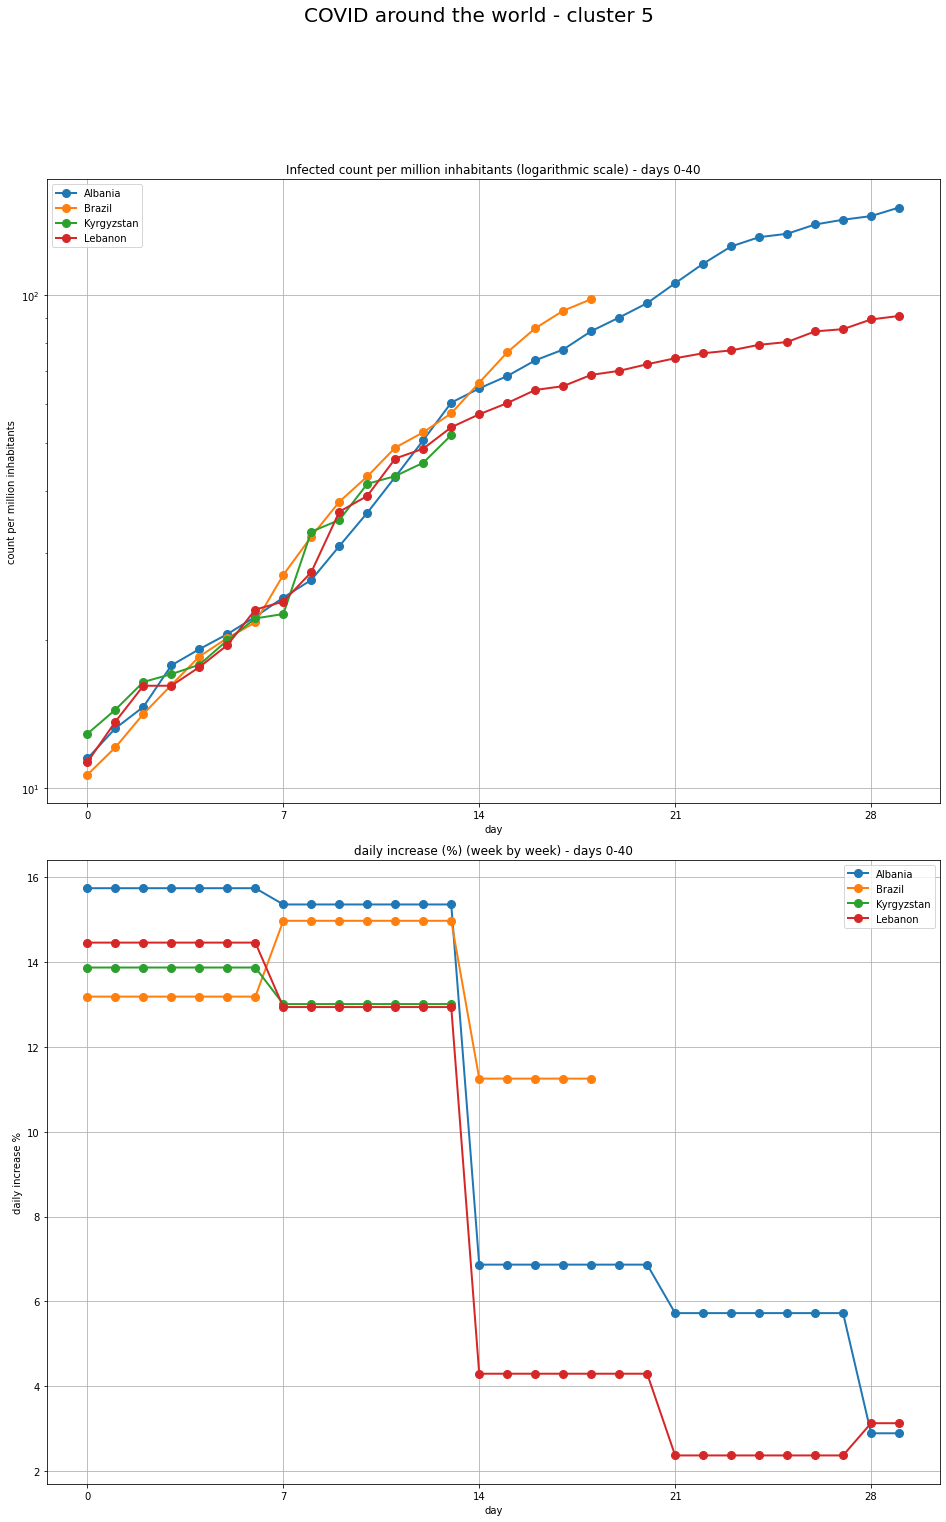

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Saved analysis to: output/covid/clustering/cluster_5/covid_plot.jpeg


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


infected count  infected count per million current date  \
Colombia                    2709                          54   2020-04-11   
Kazakhstan                   865                          46   2020-04-11   
Argentina                   1975                          43   2020-04-11   
Morocco                     1545                          43   2020-04-11   
Algeria                     1825                          42   2020-04-11   
Honduras                     392                          42   2020-04-11   
Congo (Kinshasa)             223                          40   2020-04-11   

                  daily increase % (smoothened over last 7 days)  \
Colombia                                                   0.100   
Kazakhstan                                                 0.083   
Argentina                                                  0.066   
Morocco                                                    0.090   
Algeria                                                    0.060   
Honduras                                                   0.081   
Congo (Kinshasa)                                           0.070   

                  doubles every ... days  \
Colombia                            7.25   
Kazakhstan                          8.67   
Argentina                          10.89   
Morocco                             8.02   
Algeria                            11.89   
Honduras                            8.94   
Congo (Kinshasa)                   10.26   

                  days since at least 1 per million infected  \
Colombia                                                  15   
Kazakhstan                                                14   
Argentina                                                 16   
Morocco                                                   14   
Algeria                                                   14   
Honduras                                                  14   
Congo (Kinshasa)                                          14   

                  days between 1st case and at least 10 per million infected  \
Colombia                                                         21            
Kazakhstan                                                       15            
Argentina                                                        23            
Morocco                                                          26            
Algeria                                                          32            
Honduras                                                         17            
Congo (Kinshasa)                                                 17            

                  population (million)  density (people per km2)  \
Colombia                          49.4                      40.0   
Kazakhstan                        18.7                       7.0   
Argentina                         44.9                      14.4   
Morocco                           35.9                      80.0   
Algeria                           43.0                      18.0   
Honduras                           9.2                      81.0   
Congo (Kinshasa)                   5.5                       2.4   

                  GDP per capita ($) (PPP)  GDP per capita ($) (nominal)  \
Colombia                           16265.0                        6508.0   
Kazakhstan                         30178.0                        9139.0   
Argentina                          19971.0                        9887.0   
Morocco                             9667.0                        3345.0   
Algeria                            16091.0                        3980.0   
Honduras                            5600.0                        2548.0   
Congo (Kinshasa)                     843.0                         500.0   

                  average yearly temperature (degree Celsius)  \
Colombia                                                 24.5   
Kazakhstan                                                6.4   


Saved analysis to: output/covid/clustering/cluster_6/countries_comparison.xlsx


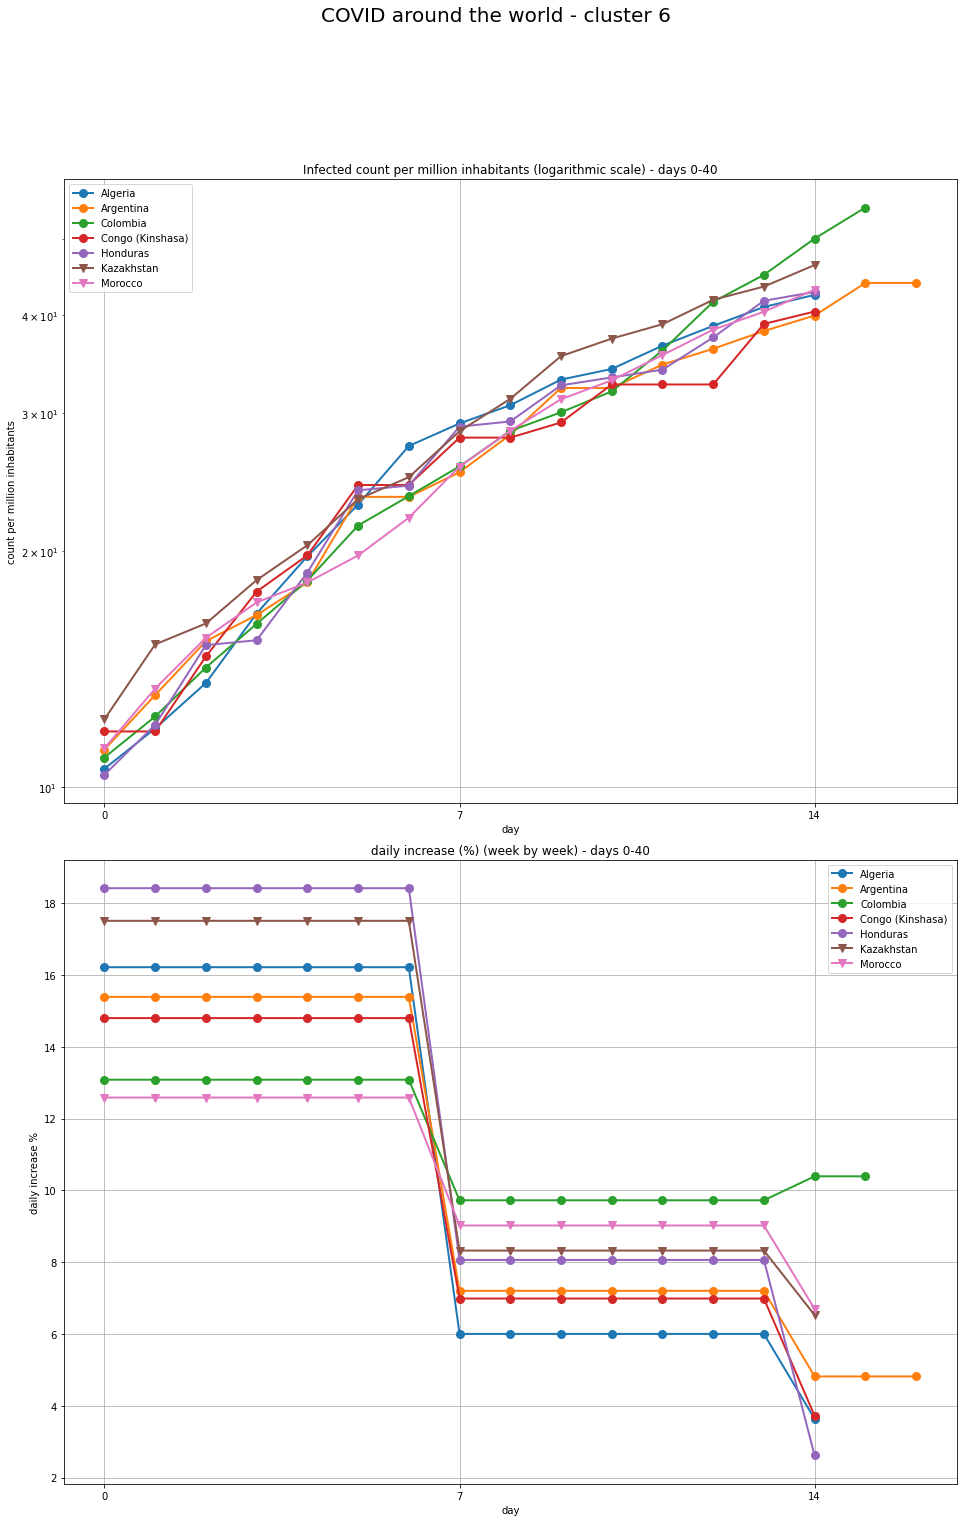

Saved analysis to: output/covid/clustering/cluster_6/covid_plot.jpeg


In [15]:
for cluster in sorted(clustering.unique()):
    if cluster == -1:
        continue
    cluster_countries = clustering[clustering == cluster]
    cluster_countries = [c for c in countries_for_clustering if c['country'] in cluster_countries.index]
    read_data_plot_countries(cluster_countries, 
                             output_folder=f'clustering/cluster_{cluster}/', 
                             min_count_per_million=10,
                             title=f'COVID around the world - cluster {cluster}'
                            )